<font color='#5a9bd4'>**Proyecto Telecom X - Etapa 2 - Machine Learning**</font>
---

# <font color='#5a9bd4'>**Previsión de Evasión (Churn) de clientes.**</font>

## <font color='#b0b0b0'>**Índice**</font>

1. Descripción del proyecto
2. Importación de librerías y configuraciones
   - Importación de librerías
   - Paths
   - Configuraciones
   - Funciones
4. Preprocesamiento de datos
   - Encoding de variables categóricas
   - Balance del dataset
   - Normalización de datos
   - Correlación entre variables
   - Análisis de multicolinealidad
   - Análisis dirigido
5. Modelado de datos
   - Baseline Model - Decision Tree Classifier
   - Random Forest Classifier
   - Logistic Regression
   - K-Nearest Neighbors
   - XGBoost Classifier
   - Support Vector Machine
6. Evaluación Best Models
   - Métricas Generales
   - Subajuste (Underfitting) y Sobreajuste (Overfitting)
   - Matrices de confusión
   - Importancias y Coeficientes
7. Champion Model
8. Pipeline de prueba en entorno productivo
   - Generación de datos artificiales
   - Pipeline de prueba

# <font color='#5a9bd4'>**1. Descripción del proyecto**</font>

En este proyecto se desarrollarán modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.

La empresa quiere anticiparse al problema de la cancelación explorado en la etapa anterior, por lo que en el presente notebook se construirá un pipeline robusto para esta etapa inicial de modelado, en el cual se llevarán a cabo las siguientes tareas:


* Preparar los datos para el modelado (tratamiento, codificación, normalización).
* Realizar análisis de correlación y selección de variables.
* Entrenar diferentes modelos de clasificación, evaluar el rendimiento de estos a través de distintas métricas e interpretar los resultados de cada uno de ellos.
* Finalmente, se creará un reporte con una conclusión estratégica señalando los principales factores que influyen en la cancelación.

# <font color='#5a9bd4'>**2. Importación de librerías y configuraciones**</font>

## <font color='#ebac3a'>**Importación de librerías**</font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

from pathlib import Path
from typing import Tuple, Callable, List

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

In [2]:
import matplotlib
import sklearn

In [3]:
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'imblearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

numpy==1.26.4
pandas==2.2.2
matplotlib==3.10.0
seaborn==0.13.2
scikit-learn==1.5.2
imblearn==1.5.2
xgboost==2.1.3


## <font color='#ebac3a'>**Paths**</font>

In [4]:
PROJECT_PATH = 'C:/Users/Ignacio/JupyterScripts/ONE/challenge_telecomX_parte_2'

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
IMG_PATH = PROJECT_PATH / img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('reports')
REPORTS_PATH = PROJECT_PATH / reports


champion = Path('champion')
CHAMPION_PATH = PROJECT_PATH / champion

champion_preduction = Path('production')
champion_monitor = Path('monitor')

PRODUCTION_PATH = CHAMPION_PATH / 'log' / champion_preduction
MONITOR_PATH = CHAMPION_PATH / 'log' / champion_monitor

dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH, CHAMPION_PATH, PRODUCTION_PATH, MONITOR_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directoryo creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\src

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\img

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\models

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\reports

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\champion

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\champion\log\production

El directorio ya existe:
C:\Users\Ignacio\JupyterScripts\ONE\challenge_telecomX_parte_2\champion\log\monitor



## <font color='#ebac3a'>**Configuraciones**</font>

### Paleta de Colores del Proyecto

**Azules**  
<span style="display:inline-block; width:20px; height:20px; background:#4682b4; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#5a9bd4; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#2e6eab; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#1f4e79; margin-right:5px;"></span>

**Naranjas**  
<span style="display:inline-block; width:20px; height:20px; background:#e9611d; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#f07c3e; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#cc4e0f; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#a53d0c; margin-right:5px;"></span>

**Púrpuras**  
<span style="display:inline-block; width:20px; height:20px; background:#6a3fa0; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#8b5fc4; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#4f2d84; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#381c66; margin-right:5px;"></span>

**Cremas / Mostazas**  
<span style="display:inline-block; width:20px; height:20px; background:#ebac3a; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#d99a2e; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#c48824; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#b0771b; margin-right:5px;"></span>


**Grises**  
<span style="display:inline-block; width:20px; height:20px; background:#4d4d4d; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#7a7a7a; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#b0b0b0; margin-right:5px;"></span>
<span style="display:inline-block; width:20px; height:20px; background:#dcdcdc; margin-right:5px;"></span>


In [5]:
# Estandarización de colores
sns.set_palette('colorblind')
churn_colors = ['#4682b4', '#e9611d']

In [6]:
# Colores del proyecto
AZUL_1, AZUL_2, AZUL_3, AZUL_4 = '#4682b4', '#5a9bd4', '#2e6eab', '#1f4e79'
NARANJA_1, NARANJA_2, NARANJA_3, NARANJA_4 = '#e9611d', '#f07c3e', '#cc4e0f', '#a53d0c'
PURPURA_1, PURPURA_2, PURPURA_3, PURPURA_4 = '#6a3fa0', '#8b5fc4', '#4f2d84', '#381c66'
CREMA_1, CREMA_2, CREMA_3, CREMA_4 = '#ebac3a', '#d99a2e', '#c48824', '#b0771b'
GRIS_1, GRIS_2, GRIS_3, GRIS_4 = '#4d4d4d', '#7a7a7a','#b0b0b0','#dcdcdc'

In [7]:
# Definir los colores personalizados
custom_colors = [
    '#4682b4', '#5a9bd4', '#2e6eab', '#1f4e79',  # Azules
    '#6a3fa0', '#8b5fc4', '#4f2d84', '#381c66',  # Púrpuras
    '#ebac3a', '#d99a2e', '#c48824', '#b0771b',  # Cremas
    '#e9611d', '#f07c3e', '#cc4e0f', '#a53d0c',  # Naranjas
]

# Creamos el colormap personalizado
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

## <font color='#ebac3a'>**Funciones**</font>

In [8]:
def boxplot_churn(df: pd.DataFrame,
                  ycol: str,
                  ylabel: str=None,
                  title_translate: str=None):
    
    """    
    Genera y guarda un boxplot que muestra la distribución de una variable numérica 
    (`ycol`) según la condición de churn de los clientes.
    --------------------------------------------------------------------------------------------------
    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame que contiene los datos a graficar. Debe incluir las columnas 'Churn' y `ycol`.
    ycol : str
        Nombre de la columna numérica cuya distribución se desea visualizar.
    ylabel : str, opcional
        Etiqueta personalizada para el eje Y. Si no se especifica, se usa `ycol`.
    title_translate : str, opcional
        Nombre personalizado para mostrar en el título del gráfico. Si no se especifica, se usa `ycol`.
    --------------------------------------------------------------------------------------------------
    Guardado
    --------
    Guarda el gráfico como imagen PNG en la ruta `IMG_PATH` con el nombre `boxplot_Churn_<ycol>.png`.
    --------------------------------------------------------------------------------------------------
    Retorna
    -------
    fig: matplotlib.figure.Figure
        Objeto de figura de Matplotlib con los gráficos generados.
    
    """

    if ylabel is None:
        ylabel = ycol
    if title_translate is None:
        title_translate = ycol
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax = sns.boxplot(data=df, x='Churn', y=ycol, hue='Churn', palette=churn_colors)
    plt.title(f'Distribución de {title_translate} según\nEvasión (Churn) de clientes', fontsize=18, pad=20)
    plt.xlabel('Churn', fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.grid(True)
    
    fig.savefig(IMG_PATH /f'boxplot_Churn_{ycol}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    plt.show()
    return fig

In [9]:
def metricas_generales(modelo, 
                       x_val: pd.core.frame.DataFrame,
                       y_val: pd.core.series.Series, 
                       nombre: str,
                       conjunto: str):
    """
    Funcion que calcula métricas de modelos clasificación
    ------------------------------------------------------------
    Parámetros:
        modelo:
            Modelo de Machine Learning Scikit-learn (debe contar con el método predict)
        x_val: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas utilizadas para validar el modelo
        y_val: pandas.core.series.Series
            Pandas Series con las etiquetas reales de los datos utilizados para validar el modelo
        nombre: str
            Nombre que identificará el modelo para comparaciones
    ------------------------------------------------------------
    Returns:
        Diccionario con nombre del modelo y metricas: Accuracy, Precision, Recall, F1-score
    """
    
    metricas = {}
    y_pred = modelo.predict(x_val)
    metricas['Model'] = nombre
    metricas['Accuracy'] = np.round(accuracy_score(y_val, y_pred), 4)
    metricas['Precision'] = np.round(precision_score(y_val, y_pred), 4)
    metricas['Recall'] = np.round(recall_score(y_val, y_pred), 4)
    metricas['F1-score'] = np.round(f1_score(y_val, y_pred), 4)
    metricas['Dataset'] = conjunto
    return metricas

In [10]:
def plot_conf_mat(model,
                  x: pd.core.frame.DataFrame, 
                  y: pd.core.series.Series, 
                  name: str,
                  save: str,
                  save_path: Path=IMG_PATH):

    """
    Función que grafíca la matriz de confusión de un modelo y guarda la figura en el Path indicado
    ----------------------------------------------------------------------------------------------
    Parámetros:
        model: Modelo sklearn
            Modelo de clasificación binaria que cuente con el método .predict()
        x: pandas.core.frame.DataFrame
            DataFrame con las variables explicativas
        y: pandas.core.series.Series
            Serie con el vector de etiquetas verdaderas (variable respuesta)
        name: str
            Nombre del modelo para el título de la figura
        save: str
            Nombre para guardar la figura como confmat_{nombre}.png
        save_path: Path
            Ruta donde debe guardarse la figura
    ---------------------------------------------------------------------------------------------
    Returns:
        Figura con matriz de confusion obtenida por el modelo seleccionado
    """
    
    
    y_pred = model.predict(x)
    confmat = confusion_matrix(y_true=y, y_pred=y_pred)

    confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

    fig, ax = plt.subplots(figsize=(10,6))
    confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

    plt.title(name, fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.tick_params(axis='both', labelsize=13)
    
    plt.subplots_adjust(right=0.88)
    plt.tight_layout(pad=3.0)
    
    fig.savefig(save_path / f'confmat_{save}.png',
                transparent=True,
                dpi=300,
                bbox_inches=None)

In [11]:
def plot_analisis_variables(df: pd.core.frame.DataFrame, 
                            analisis: str,
                            nombre_modelo: str, 
                            save: str,
                            n_vars: int= None,
                            save_path: Path=IMG_PATH):
    """
    Funcion que permite visualizar Importancias o Coeficientes de modelos, guardando la figura en la ruta correspondiente.
    -----------------------------------------------------------------------------------
    Parámetros:
        df: pandas.core.frame.DataFrame
            DataFrame con las variables del modelo y sus importancias o coeficientes.
        analisis: str
            Acepta solo 'Importancia' o 'Coeficiente' para determinar qué analizar.
        nombre_modelo: str
            Nombre que aparecerá en el título del gráfico.
        save: str
            Nombre que se utilizará para guardar el gráfico con: "{analisis}_variables_{save}.png"
        n_vars: int
            Cantidad de variables que se desean analizar. Para análisis de coeficientes toma (n_vars / 2) para head y tail.
        save_path: Path
            Ruta para guardar el gráfico. Default IMG_PATH
    -----------------------------------------------------------------------------------
    Returns:
        Gráfico de barras horizontales con Importancia o Coeficientes de variables determinadas por modelo.
    """
    
    if analisis != 'Coeficiente' and analisis != 'Importancia':
        raise ValueError('Esta función acepta solo los valores "Importancia" o "Coeficiente" para el parámetro <analisis>') 
        
    if n_vars:
        if analisis == 'Coeficiente':
            n_vars = int(n_vars / 2)
            df1 = df.head(n_vars)
            df1
            df2 = df.tail(n_vars)
            df2
            df = pd.concat([df1, df2])
        else:
            df = df.head(n_vars)
        
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(data=df, x=analisis, y='Feature', orient='h', hue=analisis, palette=custom_cmap)
    plt.title(f'{analisis}s de Variables - {nombre_modelo}', fontsize=18, loc='left')
    plt.xlabel(analisis, fontsize=16)
    plt.ylabel('Feature', fontsize=16)

    
    x_max = df[analisis].max()
    x_min = df[analisis].min()
    
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        if width != 0:
            if analisis == 'Coeficiente':                
                if width > 0:
                    ax.text(
                        (width + (x_max * 0.3)), y,
                        f'{width:.4f}',
                        ha='right', va='center',
                        fontsize=9, color='black', fontweight='bold')
                else:
                    ax.text(
                        (width - (x_max * 0.3)), y,
                        f'{width:.4f}',
                        ha='left', va='center',
                        fontsize=9, color='black', fontweight='bold')
            else:
                ax.text(
                    (width + (x_max * 0.05)), y,
                    f'{width*100:.2f}%',
                    ha='center', va='center',
                    fontsize=9, color='black', fontweight='bold'
                    )
        
    sns.despine()
    if analisis == 'Coeficiente':
        plt.xlim(x_min-1, x_max+1) 
    plt.tight_layout()

    fig.savefig(IMG_PATH / f'{analisis}_variables_{save}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
    
    plt.show()

In [12]:
def generar_tabla(df,
                 title: str,
                 save: str,
                 figsize: Tuple=(8,6),
                 path: Path=IMG_PATH):
    """
    Función que genera una tabla visual en formato imagen a partir de un DataFrame dado.
    ---------------------------------------------------------------------------------------------------------
    Parámetros:
        df: pandas.core.frame.DataFrame
            DataFrame con los datos que se desean visualizar en formato tabular.
        title: str
            Título que se mostrará en la parte superior de la tabla.
        save: str
            Nombre con el que se guardará la imagen de la tabla como archivo .png.
        figsize: Tuple
            Tamaño de la figura (ancho, alto). Default: (8, 6).
        path: Path
            Ruta donde se guardará la imagen. Default: IMG_PATH.
    ---------------------------------------------------------------------------------------------------------
    Returns:
        Imagen .png con la tabla renderizada y coloreada, útil para presentaciones ejecutivas o informes.
    """
    
    # Crear tabla para exportar como imagen
    fig, ax = plt.subplots(figsize=figsize)
    # Eliminar los ejes
    ax.axis('off')
    
    colors = [GRIS_3, GRIS_4]
    
    
    color_order = []
    for i in range(len(df)):
        if i % 2 == 0:
            color_order.append(colors[0])
        else:
            color_order.append(colors[1])
    max_rate = max(df, key=lambda x: x[1])
    idx_max = df[df == max_rate].index[0]
    
    cols_names = df.columns        
    cell_colors = [[color, color, color, color] for color in color_order]
    table = df.values.tolist()
    
    for row in table:
        row[1] = np.round(row[1], 4)
    tabla = ax.table(cellText=table,
                     colLabels=cols_names,
                     cellLoc='center',
                     loc='center',
                     colColours=[CREMA_1 for i in range(df.shape[0])],
                     cellColours=cell_colors)
    
    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)
        
    plt.title(f'{title}', fontsize=18, fontweight='bold')
    
    # Escalar la tabla para mayor legibilidad
    tabla.scale(1, 2)
    
    plt.tight_layout()
    
    fig.savefig(path / f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')
    
    
    plt.show()

# <font color='#5a9bd4'>**3. Preprocesamiento de datos**</font>

Para el análisis, incluiré los registros que fueron clasificados como **outliers** en la etapa anterior en la cual se desarrolló la exploración y análisis de la base de datos, ya que en este caso representan comportamientos reales e importantes, como el de clientes con gasto acumulado muy alto que igual abandonan la empresa.

In [13]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

datos = pd.read_json(URL)
datos.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,0002-ORFBO,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Mailed check,2.19,65.6,593.30,No
1,0003-MKNFE,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,2.00,59.9,542.40,No
2,0004-TLHLJ,Male,No,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,2.46,73.9,280.85,Yes
3,0011-IGKFF,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.27,98.0,1237.85,Yes
4,0013-EXCHZ,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.80,83.9,267.40,Yes


***Nota**: inicialmente, se eliminarán las varialbes `CustomerID` ya que esta no aporta poder predictivo debido a que es un simple identificador de cliente, y `ChargesDaily` ya que esta variable fue agregada simplemente al dividir `ChargesMonthly` en 30 días, lo cual resulta redundante y no aporta ningun valor agregado al análisis.*

In [14]:
try:
    URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    datos = pd.concat([datos, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [15]:
datos = datos.drop(['CustomerID', 'ChargesDaily'], axis=1)

In [16]:
datos.describe()

,Tenure,ChargesMonthly,ChargesTotal
count,7152.000000,7152.000000,7152.000000
mean,32.851370,65.361955,2346.648399
std,24.684639,30.258020,2314.453371
min,0.000000,18.250000,0.000000
25%,9.000000,36.250000,410.837500
50%,30.000000,70.700000,1424.450000
75%,56.000000,90.400000,3949.575000
max,72.000000,118.750000,8684.800000


In [17]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7152 entries, 0 to 7151
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7152 non-null   object 
 1   SeniorCitizen     7152 non-null   object 
 2   Partner           7152 non-null   object 
 3   Dependents        7152 non-null   object 
 4   Tenure            7152 non-null   int64  
 5   PhoneService      7152 non-null   object 
 6   MultipleLines     7152 non-null   object 
 7   InternetService   7152 non-null   object 
 8   OnlineSecurity    7152 non-null   object 
 9   OnlineBackup      7152 non-null   object 
 10  DeviceProtection  7152 non-null   object 
 11  TechSupport       7152 non-null   object 
 12  StreamingTV       7152 non-null   object 
 13  StreamingMovies   7152 non-null   object 
 14  Contract          7152 non-null   object 
 15  PaperlessBilling  7152 non-null   object 
 16  PaymentMethod     7152 non-null   object 


## <font color='#ebac3a'>**Encoding de variables categóricas**</font>

In [18]:
datos.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'Churn'],
      dtype='object')

In [19]:
X = datos.drop('Churn', axis=1)
y = datos['Churn']

In [20]:
X_linear = X.copy()
y_linear = y.copy()

In [ ]:
X_scaled = X.copy()
y_scaled = y.copy()

In [21]:
categoricas = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [22]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='if_binary'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

one_hot_linear = make_column_transformer(
                    (OneHotEncoder(drop='first'), categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [23]:
X = one_hot.fit_transform(X)
y = label_encoder.fit_transform(y)

In [24]:
X_linear = one_hot_linear.fit_transform(X_linear)
y_linear = label_encoder.fit_transform(y_linear)

In [25]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [27]:
df = pd.DataFrame(X, columns=columnas_encoded)
df

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,60.0,99.80,5985.75
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,63.0,79.85,4861.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,46.0,19.95,907.05
7148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.15,19.15
7149,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,23.90,97.50
7150,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.55,19.55


In [28]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [29]:
df_linear = pd.DataFrame(X_linear, columns=columnas_encoded)
df_linear

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80
1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05
2,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,60.0,99.80,5985.75
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,63.0,79.85,4861.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,46.0,19.95,907.05
7148,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.15,19.15
7149,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,23.90,97.50
7150,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,19.55,19.55


In [30]:
df_y = pd.DataFrame(y, columns=['Churn'])

In [31]:
df = pd.concat([df, df_y], axis=1)
df.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80,0
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05,0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,60.0,99.80,5985.75,0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10,0
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,63.0,79.85,4861.45,0


In [32]:
df_y_linear = pd.DataFrame(y_linear, columns=['Churn'])

In [33]:
df_linear = pd.concat([df_linear, df_y_linear], axis=1)
df_linear.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.80,19.80,0
1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,67.0,60.05,3994.05,0
2,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,60.0,99.80,5985.75,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,35.10,101.10,0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,63.0,79.85,4861.45,0


### **Nota:**
Se puede observar que la única columna en la cual `1 = No` es `InternetService`. Esto puede resultar confuso debido a quel el resto de variables tienen formato `1 = Yes`, por lo que, para mantener la consistencia semántica del análisis, transformaré el nombre de esta columna de:

`InternetService_No` -> `NoInternetService`


Otro posible acercamiento sería mantener solo las columnas `InternetService_DSL` e `InternetService_Fiberoptic`, ya que la ausencia de ambas, es decir, ambas con **valor = 0** indicaría la presencia de `InternetService_No`. Pero inicialmente mantendré todas las columnas hasta generar y evaluar el modelo base.

In [34]:
df.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df_linear.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df.sample(10)

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
719,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,70.0,44.60,3058.15,0
1943,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,32.0,86.10,2723.75,0
1857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,29.0,20.35,617.35,0
1880,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,58.0,94.30,5610.15,0
2335,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,71.0,95.15,6770.85,0
4874,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,70.0,45.25,3264.45,1
3381,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,17.0,101.80,1752.45,0
309,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,61.0,104.40,6405.00,1
5070,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,50.0,100.65,5189.75,0
4069,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,39.0,86.30,3266.00,1


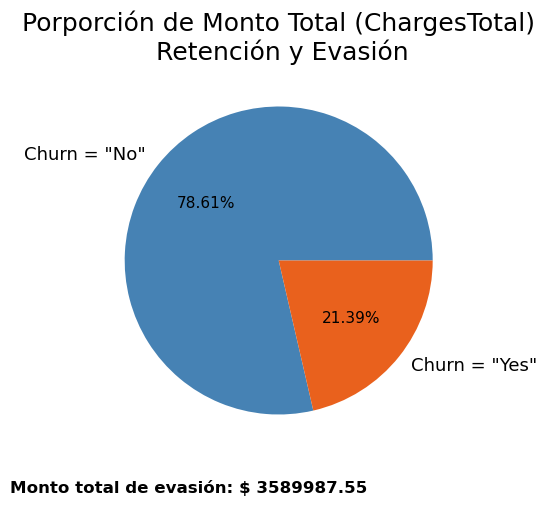

In [35]:
totales = datos.groupby('Churn')['ChargesTotal'].sum().reset_index()
churn_yes = totales[totales['Churn'] == 'Yes']

fig, ax = plt.subplots(figsize=(8,5))

wedges, texts, autotexts = ax.pie(data=totales, 
                                  x='ChargesTotal', 
                                  autopct='%1.2f%%', 
                                  labels=['Churn = "No"', 'Churn = "Yes"'], 
                                  colors=churn_colors,
                                  startangle=0
                                  )
for t in texts:
    t.set_fontsize(13)
for a in autotexts:
    a.set_fontsize(11)

plt.title('Porporción de Monto Total (ChargesTotal)\n Retención y Evasión', fontsize=18)
plt.figtext(0.4, 0.03, f'Monto total de evasión: $ {churn_yes["ChargesTotal"].values[0]}', ha='center', fontsize=12, fontweight='bold')

fig.savefig(IMG_PATH / 'monto_evasion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

## <font color='#ebac3a'>**Normalización de datos**</font>

Si bien algunos modelos como `Random Forest` no necesitan normalización (ya que este no se basa en distancias, sino en preguntas de comparación: < o > ), se analizarán las variables numéricas, ya que la idea del proyecto es probar distintos modelos y evaluarlos para así seleccionar el que tenga mejor desempeño para ponerlo en producción.

In [36]:
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25) 
    
    bin_width = 2 * (iqr / np.cbrt(n))
    return bin_width

<Axes: xlabel='Tenure', ylabel='Count'>

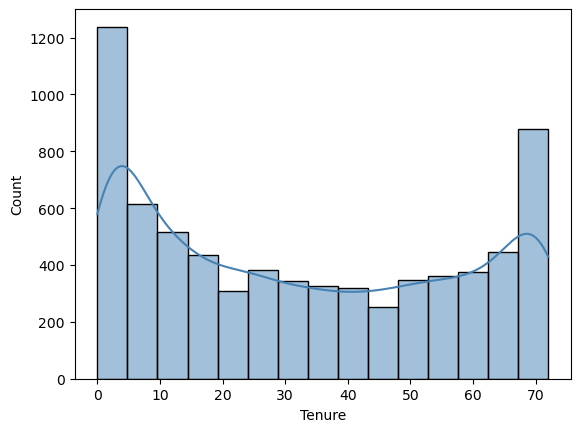

In [37]:
BIN_WIDTH = bin_width(df, 'Tenure')

sns.histplot(df['Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

<Axes: xlabel='ChargesMonthly', ylabel='Count'>

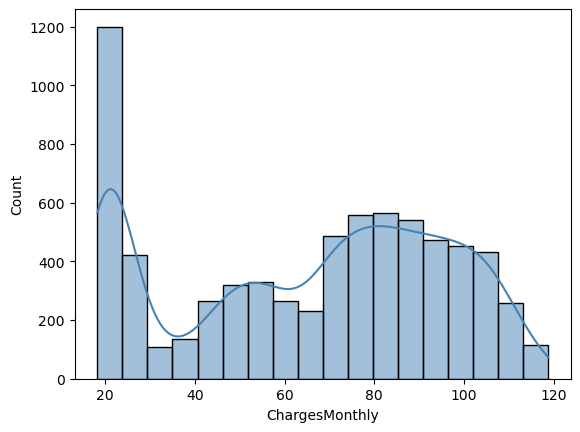

In [38]:
BIN_WIDTH = bin_width(df, 'ChargesMonthly')

sns.histplot(df['ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

<Axes: xlabel='ChargesTotal', ylabel='Count'>

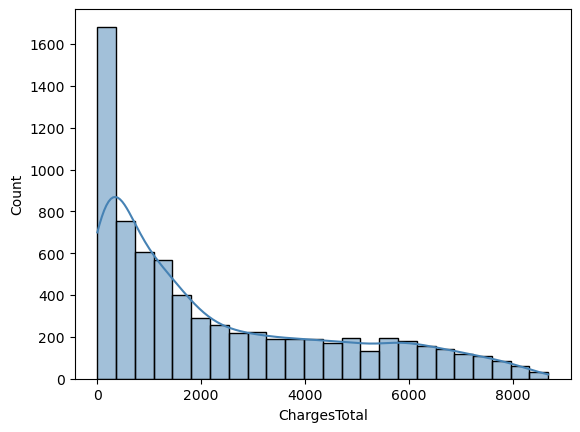

In [39]:
BIN_WIDTH = bin_width(df, 'ChargesTotal')

sns.histplot(df['ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

In [40]:
df['log_ChargesTotal'] = np.log(df['ChargesTotal'] + 1)

<Axes: xlabel='log_ChargesTotal', ylabel='Count'>

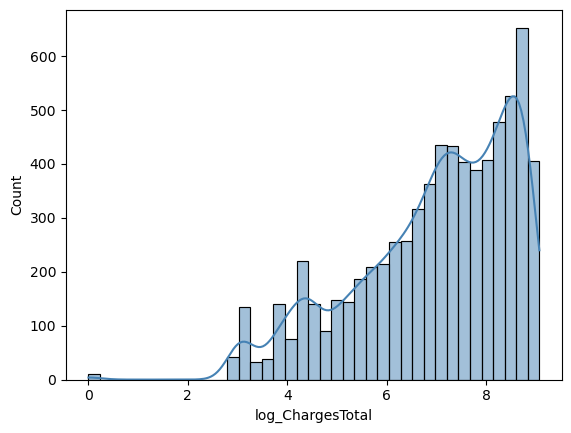

In [41]:
BIN_WIDTH = bin_width(df, 'log_ChargesTotal')

sns.histplot(df['log_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

In [42]:
df['sqrt_ChargesTotal'] = np.sqrt(df['ChargesTotal'] + 1)

<Axes: xlabel='sqrt_ChargesTotal', ylabel='Count'>

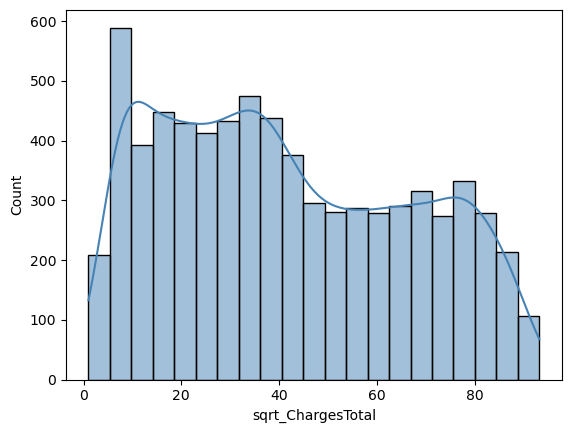

In [43]:
BIN_WIDTH = bin_width(df, 'sqrt_ChargesTotal')

sns.histplot(df['sqrt_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

In [44]:
scaler = StandardScaler()

In [45]:
df['Z_ChargesTotal'] = scaler.fit_transform(df[['ChargesTotal']])

<Axes: xlabel='Z_ChargesTotal', ylabel='Count'>

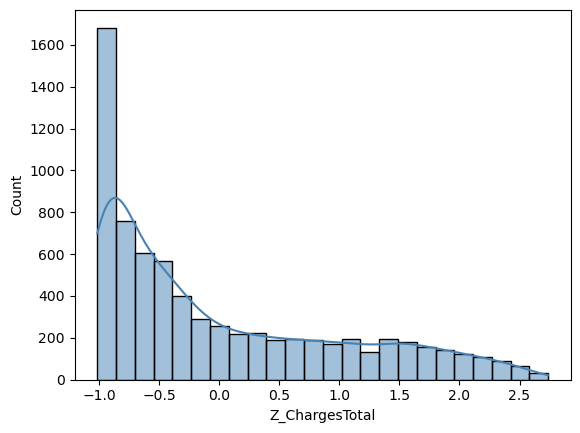

In [46]:
BIN_WIDTH = bin_width(df, 'Z_ChargesTotal')

sns.histplot(df['Z_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)

### <font color='#8b5fc4'>**Observaciones: Normalización de datos**</font>

Es posible observar que ninguna de las transformaciones aplicadas consigue corregir la asimetría positiva de ChargesTotal.
Debido a su naturaleza acumulativa, se puede esperar de este tipo de variables que la mayor concentración de observaciones se encuentre en valores pequeños, teniendo solo valores altos por ejemplo, para un grupo seleccionado de clientes.
En adición, fueron incluidos los registros considerados outliers (clientes de alto valor que abandonaron la empresa), ya que resulta importante conocer que características comparten estos con aquellos de "menor valor", lo que indicará **áreas críticas de mejora para reducir la tasa de Evación *(Churn)***.

Por lo tanto optaré por mantener las variables cuantitativas en su estado original y evaluar si los modelos son capaces de manejarlas correctamente. Caso contrario, aplicaré `RobustScaler`

In [47]:
df = df.drop(['log_ChargesTotal', 'sqrt_ChargesTotal', 'Z_ChargesTotal'], axis=1)

In [48]:
df.describe()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
count,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,...,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000,7152.000000
mean,0.505733,0.163451,0.486298,0.298518,0.904642,0.429251,0.338647,0.447987,0.213367,0.288171,...,0.240492,0.595358,0.219938,0.217002,0.337668,0.225391,32.851370,65.361955,2346.648399,0.276566
std,0.500002,0.369802,0.499847,0.457640,0.293729,0.495004,0.473283,0.497322,0.409713,0.452943,...,0.427412,0.490857,0.414234,0.412233,0.472948,0.417869,24.684639,30.258020,2314.453371,0.447331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,36.250000,410.837500,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000,70.700000,1424.450000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,56.000000,90.400000,3949.575000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,118.750000,8684.800000,1.000000


In [49]:
df.shape

(7152, 27)

## <font color='#ebac3a'>**Correlación entre variables**</font>

In [50]:
corr = df.corr()

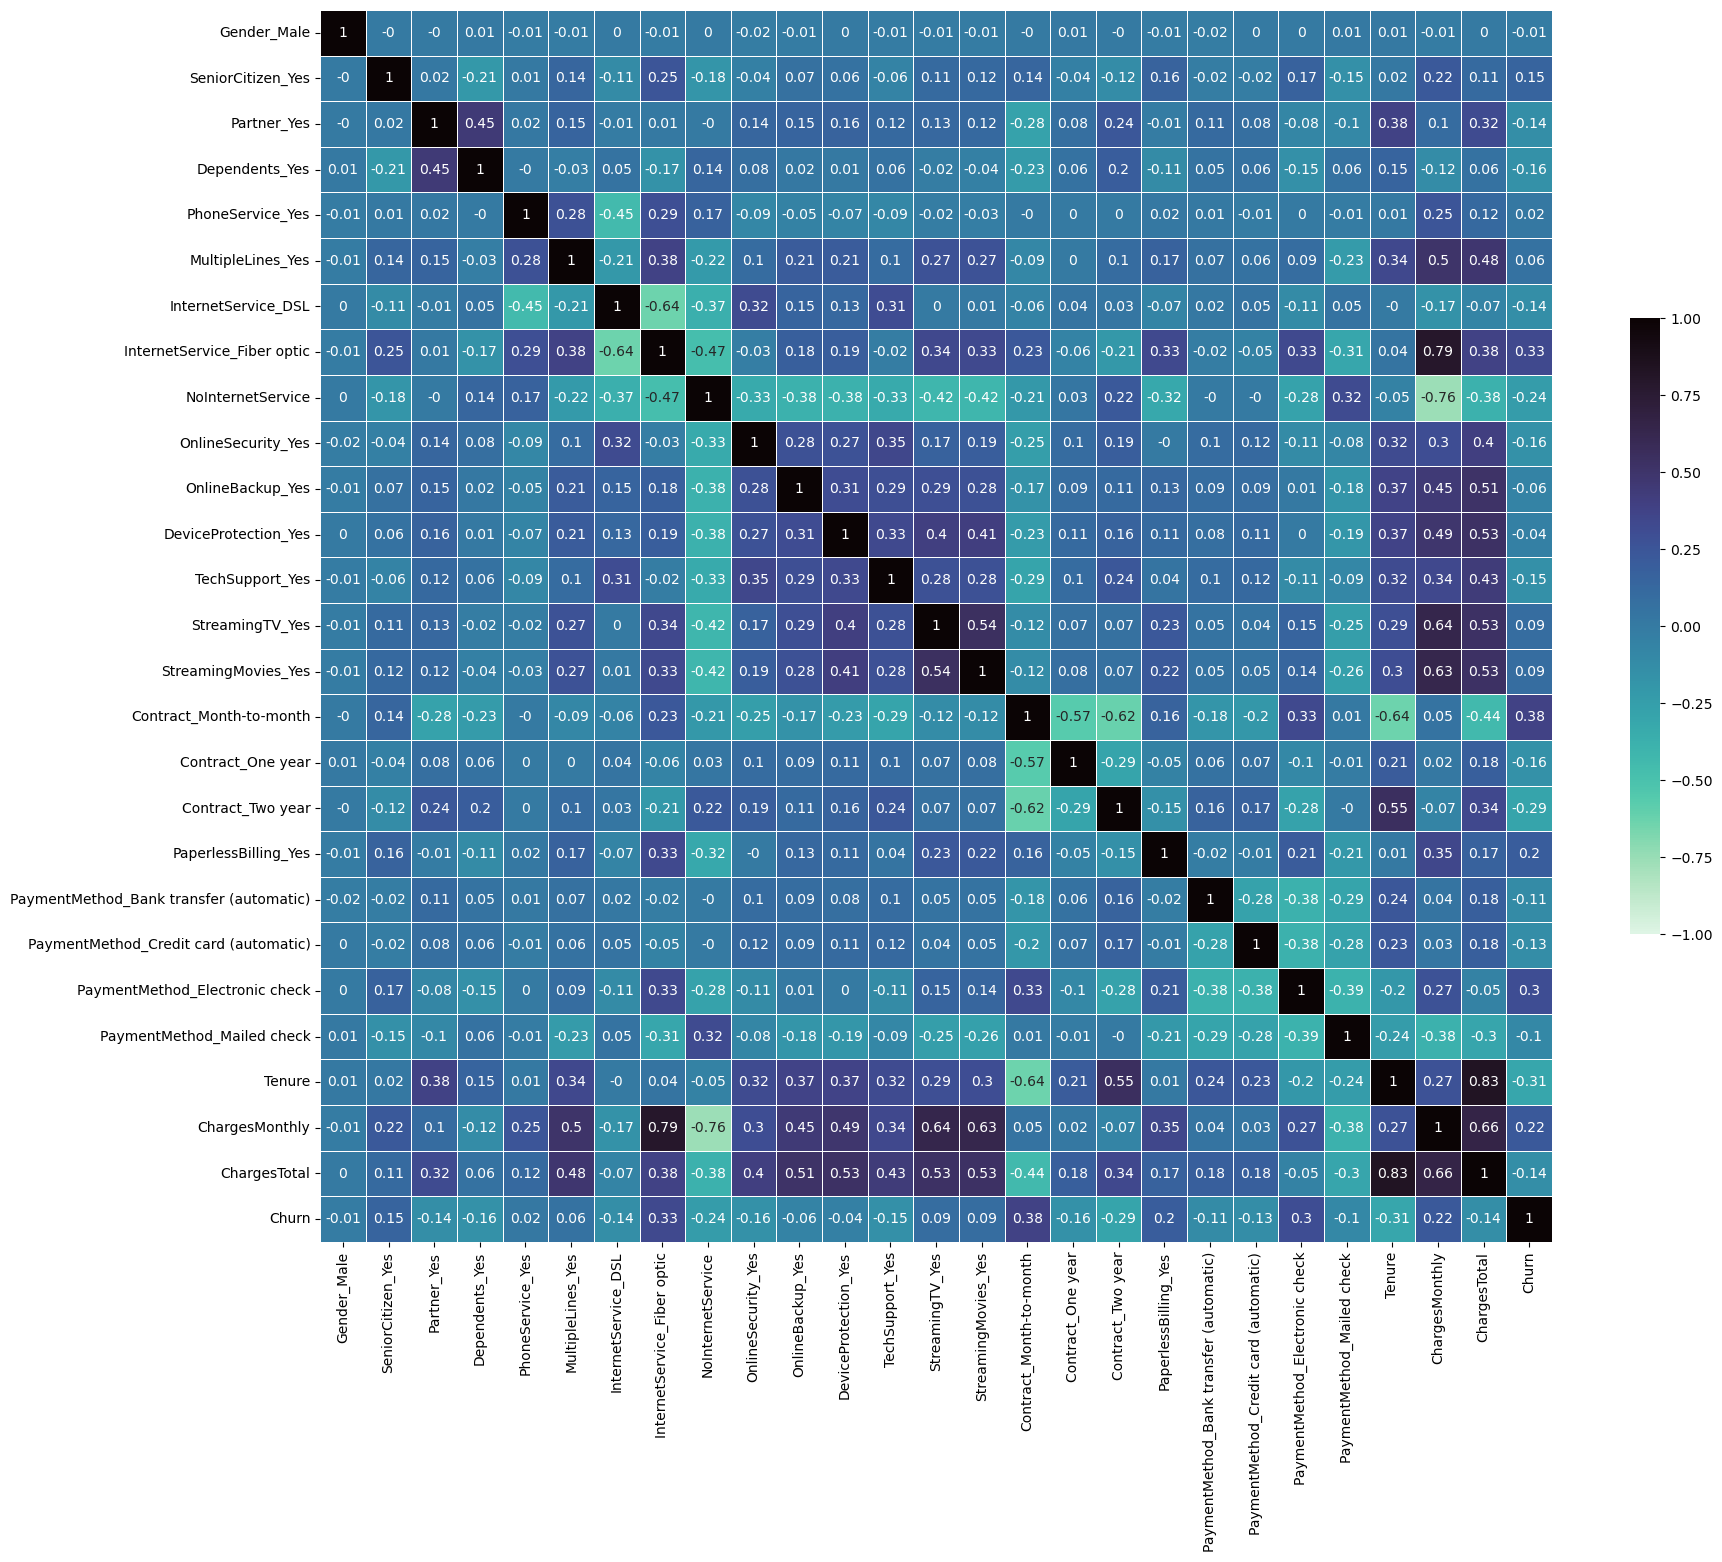

In [52]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
plt.show()

### ***Nota:***

Debido a que existe una cantidad considerable de variables, para una mejor visualización selecionaré aquellas que tiene una correlación absoluta con la Evasión mayor a 0.07

In [53]:
cols = corr.loc['Churn'].abs()[corr.loc['Churn'].abs() > 0.07].index
corr_selected = corr[cols].loc[cols]  # Subset del DataFrame completo

In [54]:
# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

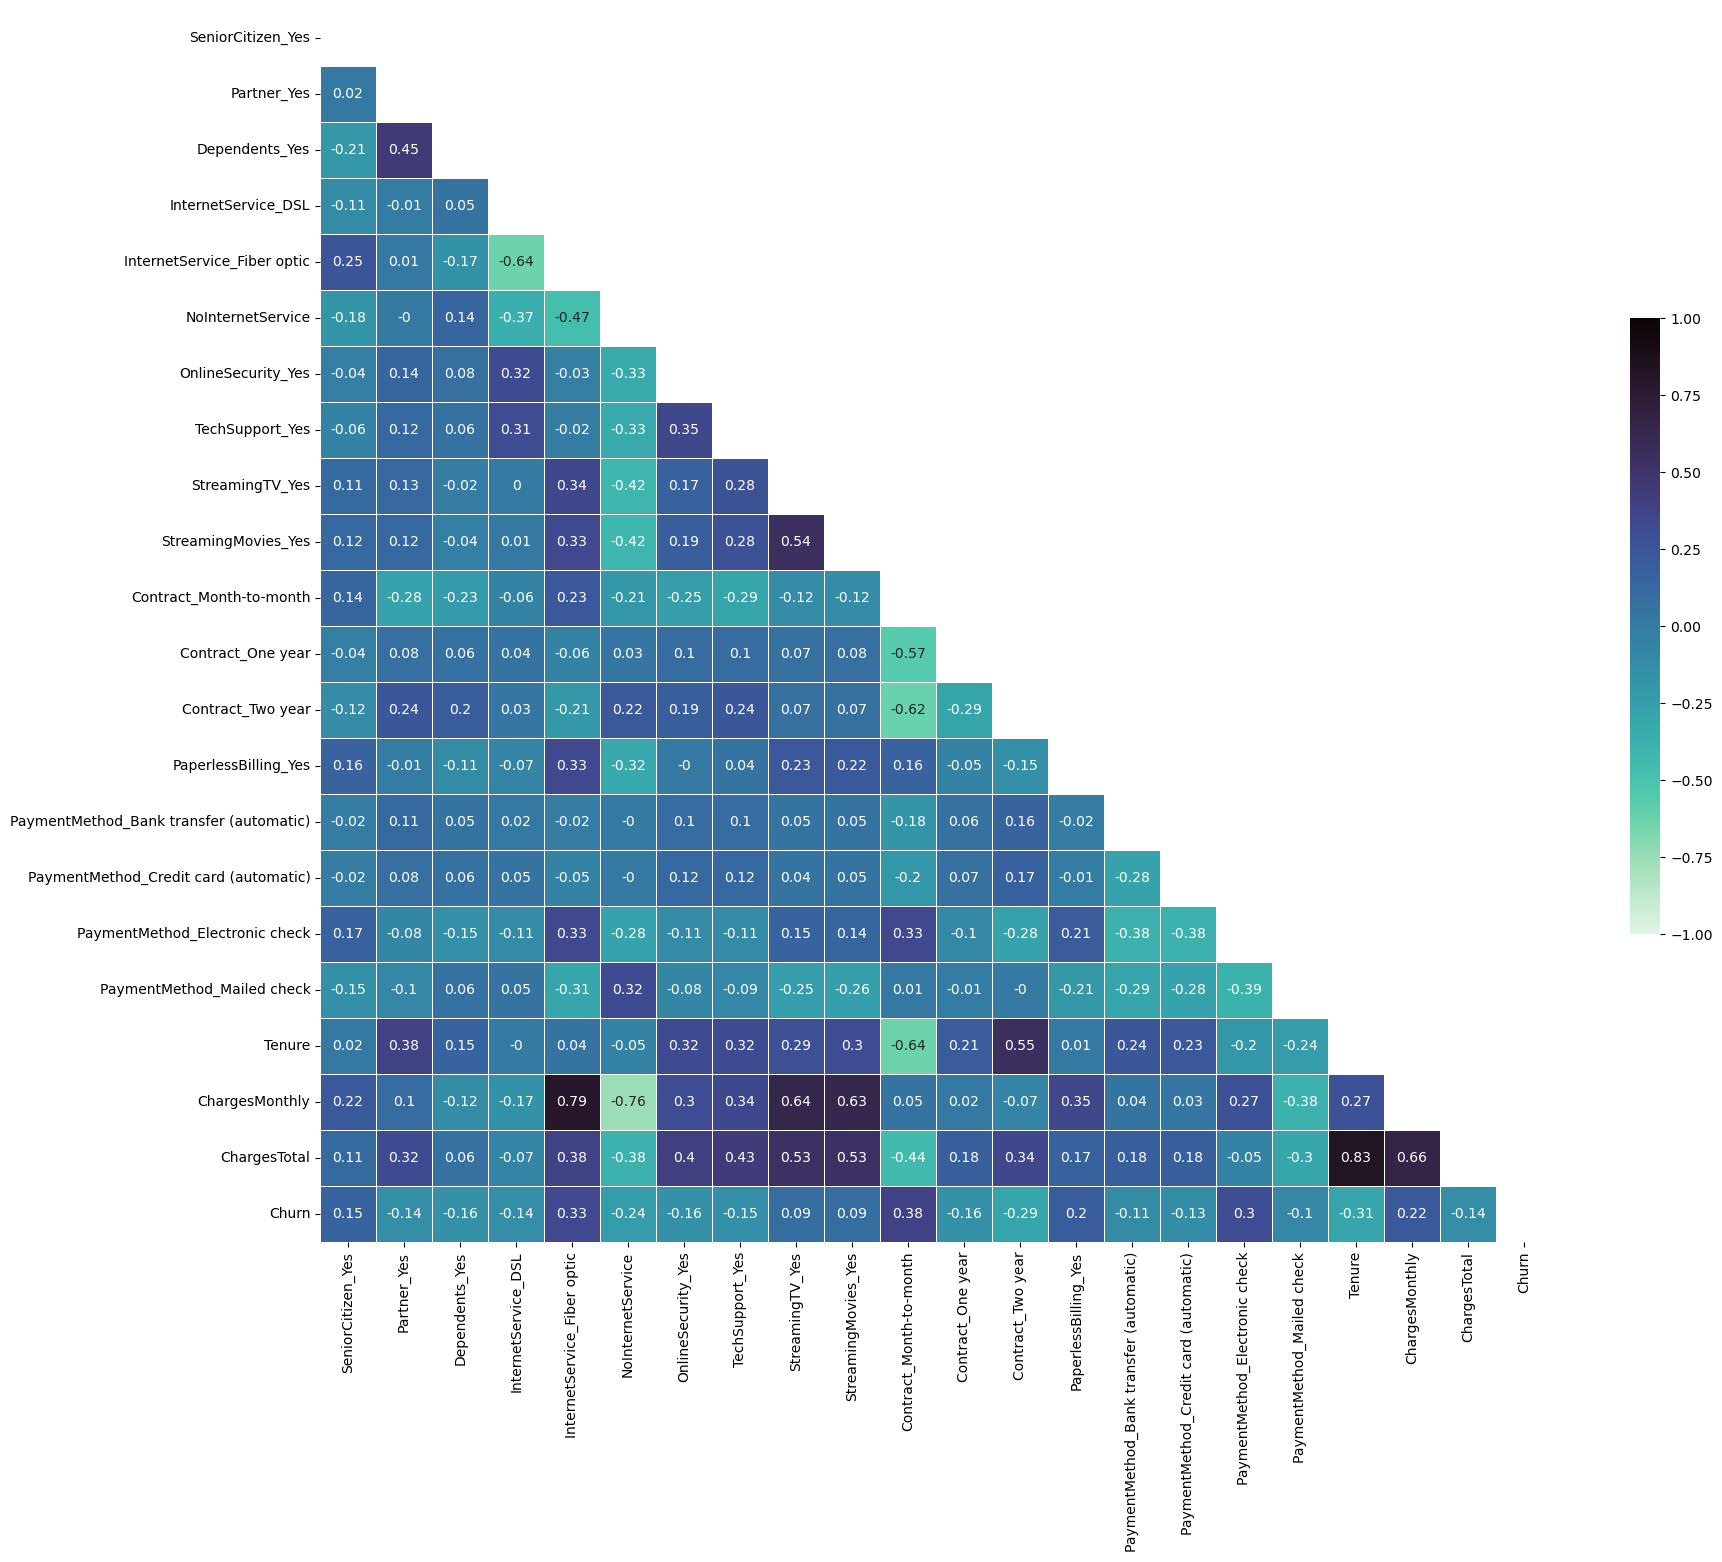

In [55]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
fig.savefig(IMG_PATH / 'corr_matrix.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

### <font color='#8b5fc4'>**Observaciones: Correlación entre variables**</font>

Particularmente destaca una fuerte relación positiva entre `ChargesTotal` y `Tenure`. Esto probablemente se debe a la naturaleza acumulativa de `ChargesTotal`, por lo que, es posible que esta variable sea ya explicada entre `Tenure` y ChargesMonthly. Para verificar este fenómeno, se llevará a cabo un análisis de colinealidad, a través de **Variance Inflation Factor**.

## <font color='#ebac3a'>**Análisis de multicolinealidad**</font>

### <font color='#f07c3e'>**VIF 1**</font>

Variance Inflation Factor, en esencia, realiza una regresión lineal tomando cada variable explicativa como variable respuesta, y busca explicarla a través del resto de variables explicativas. Los valores aceptables suelen ser:

* 1 < VIF < 5 = **Aceptable**
* 5 < VIF < 10 = **La variable puede conservarse si se considera necesario**
* 10 < VIF = **Existe colinealidad fuerte entre dicha variable y alguna de las otras variables explicativas**

En los casos que exista colinealidad, la eliminación de dichas variables se descarta para no perjudicar al modelo.

Se utilizará la variable X_linear que fue codificada con `OneHotEncoder(drop='first')`, esto asegura que se descarte la primera categoría de cada feature al codificar las variables, evitando que se introduzca multicolinealidad manualmente al modelo.

Además, se escalarán las variables numéricas ya que dicho algoritmo, al realizar regresiones lineales, es sensible a la escala de los datos.

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import RobustScaler

In [57]:
robust_scaler = RobustScaler()

In [58]:
x_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']

X_linear_num = df_linear[x_num]

X_linear_num = robust_scaler.fit_transform(X_linear_num)

df_linear[['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_linear_num

df_linear = df_linear.drop(['Tenure', 'ChargesMonthly', 'ChargesTotal'], axis=1)

In [59]:
X_vif = df_linear.drop('Churn', axis=1)

In [60]:
features = X_vif.columns

In [61]:
df_vif = pd.DataFrame()
df_vif['Feature'] = features
df_vif['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

X

In [62]:
df_vif.sort_values('VIF', ascending=False)

,Feature,VIF
22,ChargesTotal_scaled,12.902310
21,ChargesMonthly_scaled,11.696381
4,PhoneService_Yes,10.048787
20,Tenure_scaled,7.750051
6,InternetService_Fiber optic,6.817227
7,NoInternetService,5.937551
15,Contract_Two year,3.436684
12,StreamingTV_Yes,3.055135
13,StreamingMovies_Yes,3.029339
16,PaperlessBilling_Yes,2.989310


### <font color='#8b5fc4'>**Observaciones: VIF 1**</font>

Como se observó en el **Análisis de Correlación** de variables, `ChargesTotal` y `Tenure` son las variables que presentan mayor valor de **VIF**, la primera superando el umbral crítico por más del doble.

|Feature	            |VIF      |
|-----------------------|---------|
|ChargesTotal_scaled	|21.714752|
|Tenure_scaled	        |16.386025|

Como se mencionó anteriormente, ChargesTotal es la acumulación de `ChargesMonthly` a lo largo de la cantidad de meses de `Tenure`. Por lo tanto, se descartará la primera para evaluar el resultado de **Variance Inflation Factor**.

### <font color='#f07c3e'>**VIF 2**</font>

In [63]:
X_vif = df_linear.copy()

In [64]:
X_vif = X_vif.drop(['ChargesTotal_scaled', 'Churn'], axis=1)

In [65]:
features = X_vif.columns
features

Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled'],
      dtype='object')

In [66]:
df_vif_2 = pd.DataFrame()
df_vif_2['Feature'] = features
df_vif_2['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [67]:
df_vif_2.sort_values('VIF', ascending=False)

,Feature,VIF
21,ChargesMonthly_scaled,10.568394
4,PhoneService_Yes,10.015450
6,InternetService_Fiber optic,6.736119
7,NoInternetService,5.918196
15,Contract_Two year,3.408953
12,StreamingTV_Yes,3.017488
16,PaperlessBilling_Yes,2.989275
13,StreamingMovies_Yes,2.987107
18,PaymentMethod_Electronic check,2.964332
2,Partner_Yes,2.845660


### <font color='#8b5fc4'>**Observaciones: VIF 2**</font>

Como se observa en la tabla anterior, al eliminar la variable con mayor VIF (`ChargesTotal_scaled`), el puntaje de VIF de `Tenure_scaled` descendió de **16.386 a 2.780**. Esto representa una evidencia empírica de que `ChargesTotal_scaled` estaba fuertemente explicada por las otras dos variables numéricas (`Tenure_scaled` y `ChargesMonthly_scaled`), lo que confirma una fuerte colinealidad entre ellas.

Los **modelos lineales**, como `LogisticRegression` (a menos que se use **regularización Lasso**, que penaliza la complejidad del modelo), `LinearRegression`, o `SVM` con `kernel='linear'`, **son sensibles a la multicolinealidad**, ya que esta distorsiona la interpretación de los coeficientes y puede inflar su varianza.

Por el contrario, **modelos no lineales** como `RandomForest`, `XGBoost` o `KNN`, **son mucho más robustos** frente a este fenómeno, e incluso pueden beneficiarse de contar con variables redundantes, ya que su arquitectura puede determinar cuáles resultan más útiles para la clasificación sin sufrir distorsión en los parámetros.

Por esta razón, **se conservarán todas las variables** para los modelos no lineales, y se aplicarán los **tratamientos adecuados** (como la eliminación de variables con VIF elevado o la regularización) **únicamente en los modelos lineales**, con el objetivo de maximizar la interpretabilidad y estabilidad de los mismos.

## <font color='#ebac3a'>**Análisis Dirigido**</font>

### <font color='#f07c3e'>**Evasión (Churn) según Antigüedad (Tenure)**</font>

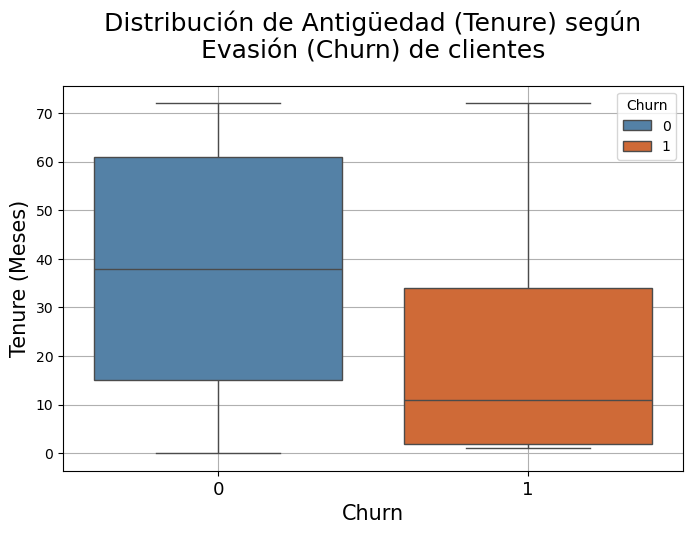

In [68]:
tenure_boxplot = boxplot_churn(df, ycol='Tenure', ylabel='Tenure (Meses)', title_translate='Antigüedad (Tenure)')

In [69]:
df[df['Churn'] == 1].describe()['Tenure']

count    1978.000000
mean       20.508595
std        21.721863
min         1.000000
25%         2.000000
50%        11.000000
75%        34.000000
max        72.000000
Name: Tenure, dtype: float64

### <font color='#8b5fc4'>**Observaciones: Evasión (Churn) según Antigüedad (Tenure)**</font>

Como se pudo observar en la etapa anterior del proyecto, es posible observar la frecuencia de abandono es mayor en las etapas tempranas de la relación del cliente con la empresa, con una **concentración del 50% de abandono** antes del primer año de contrato.

### <font color='#f07c3e'>**Evasión (Churn) según Gasto Total (ChargesTotal)**</font>

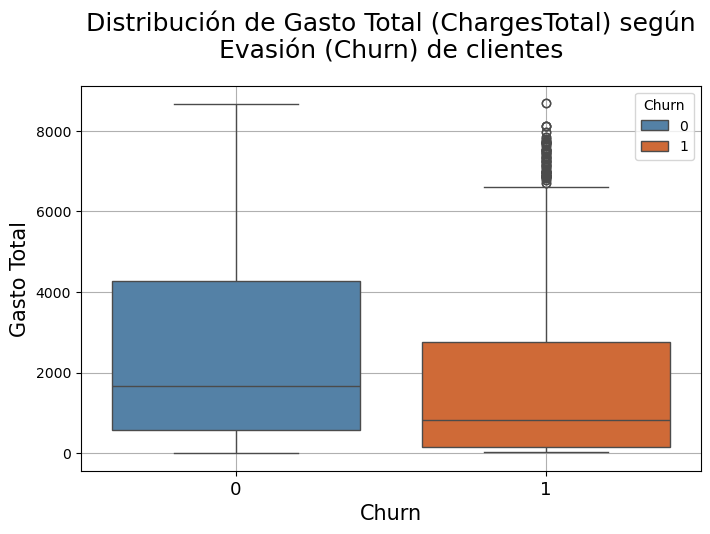

In [70]:
tenure_boxplot = boxplot_churn(df, ycol='ChargesTotal', ylabel='Gasto Total', title_translate='Gasto Total (ChargesTotal)')

### <font color='#8b5fc4'>**Observaciones: Evasión (Churn) según Gasto Total (ChargesTotal)**</font>

Debido a que ChargesTotal es una variable de naturaleza acumulativa, esta fuertemente relacionada con la antigüedad del cliente. Esto se puede observar en el análisis de correlación donde en índice de Pearson entre ambas variables es **0.94**. Esto puede generar redundancia en el modelo, por lo que, se experimentará primero considerando ambas variables, y luego se mantendrá Tenure y ChargesMonthly, ya que la combinación de estas dos variables explican ChargesTotal.

# <font color='#5a9bd4'>**4. Modelado de datos**</font>

In [71]:
df_scale = df.copy()

In [72]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [73]:
X, X_test, y, y_test = tts(X, y, test_size=0.1, stratify=y, random_state=42)

In [74]:
X_train, X_val, y_train, y_val = tts(X, y, test_size=0.135, stratify=y, random_state=42)

In [75]:
X_linear = df_linear.drop('Churn', axis=1)
y_linear = df_linear['Churn']

In [76]:
X_linear.shape, y_linear.shape

((7152, 23), (7152,))

In [77]:
X_linear, X_linear_test, y_linear, y_linear_test = tts(X_linear, y_linear, test_size=0.1, stratify=y_linear, random_state=42)

In [78]:
X_linear_train, X_linear_val, y_linear_train, y_linear_val = tts(X_linear, y_linear, test_size=0.135, stratify=y_linear, random_state=42)

## <font color='#ebac3a'>**Balance del Dataset**</font>

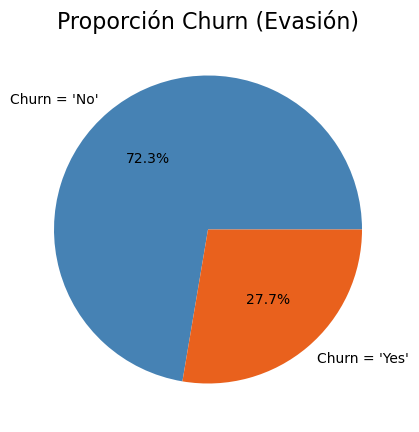

In [79]:
# Visualizar la proporción de registros en relación a la evasión (Churn)
churns = df.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors=churn_colors)

plt.title('Proporción Churn (Evasión)', fontsize=16)

fig.savefig(IMG_PATH/'pie_Churn_proportion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

### <font color='#8b5fc4'>**Observaciones: Balance del Dataset**</font>

Como puede verse en el gráfico, la proporción de las clases está desbalanceada, con aproximadamente 3/4 de los datos correspondiente a clientes que no han abandonado la empresa. Por lo tanto, para que el modelo pueda generalizar correctamente el patrón presente en los datos, será necesario balancear la cantidad de registros para equiparar las observaciones de cada clase en los datos de entrenamiento.

Debido a que lo que se busca es detectar el patrón presente en la realidad de la empresa. Optaré por utilizar *undersampling (reducción de la clase mayoritaria)*. Si bien la generación de datos artificiales con técnicas como `SMOTE` tienen fundamento matemático al realizar el *oversampling (ampliación de la clase minoritaria)*, estas observaciones, por más justificación matemática que tengan, no existen, y esto puede alterar el patrón a aprender por el modelo.

Por esta razón, se utilizará la técnica `NearMiss` para el entrenamiento, y luego, se utilizará `SMOTE` para generar una base de datos mayor, balanceada, que permita evaluar el desempeño de modelos en producción.

In [80]:
columnas = df.columns
columnas, len(columnas)

(Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'NoInternetService',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
       dtype='object'),
 27)

In [81]:
undersampler = NearMiss(version=3)

X_train, y_train = undersampler.fit_resample(X_train,y_train)

In [82]:
y_train.value_counts()

Churn
0    1540
1    1540
Name: count, dtype: int64

In [83]:
columnas_linear = df_linear.columns

In [84]:
X_linear_train, y_linear_train = undersampler.fit_resample(X_linear_train, y_linear_train)

In [85]:
X_train.shape, y_train.shape, X_linear_train.shape, y_linear_train.shape

((3080, 26), (3080,), (3080, 23), (3080,))

In [86]:
X_val.shape, y_val.shape, X_linear_val.shape, y_linear_val.shape

((869, 26), (869,), (869, 23), (869,))

In [87]:
X_test.shape, y_test.shape, X_linear_test.shape, y_linear_test.shape

((716, 26), (716,), (716, 23), (716,))

In [88]:
y_train.value_counts()

Churn
0    1540
1    1540
Name: count, dtype: int64

In [89]:
y_linear_train.value_counts()

Churn
0    1540
1    1540
Name: count, dtype: int64

In [90]:
y_val.value_counts()

Churn
0    629
1    240
Name: count, dtype: int64

In [91]:
y_linear_val.value_counts()

Churn
0    629
1    240
Name: count, dtype: int64

In [92]:
y_test.value_counts()

Churn
0    518
1    198
Name: count, dtype: int64

In [93]:
y_linear_test.value_counts()

Churn
0    518
1    198
Name: count, dtype: int64

In [94]:
df1 = pd.DataFrame(X_train, columns=columnas[:-1])
df2 = pd.DataFrame(y_train, columns=[columnas[-1]])
df = pd.concat([df1, df2], axis=1)
df

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,116.40,8543.25,0
1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,72.0,116.95,8594.40,0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,72.0,117.50,8670.10,0
3,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,72.0,110.45,7982.50,0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,56.0,25.95,1444.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,63.0,107.50,6873.75,1
3076,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,55.70,55.70,1
3077,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,70.15,70.15,1
3078,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,26.0,91.25,2351.80,1


In [95]:
df1 = pd.DataFrame(X_linear_train, columns=columnas_linear[:-1])
df2 = pd.DataFrame(y_linear_train, columns=[columnas_linear[-1]])
df_linear = pd.concat([df1, df2], axis=1)
df_linear

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,OnlineBackup_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,Tenure_scaled,ChargesMonthly_scaled,ChargesTotal_scaled
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.851064,-0.411819,NaN
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.085106,-0.421976,NaN
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0.638298,-0.182825,NaN
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0.425532,-0.510619,NaN
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.702128,-0.224377,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,NaN,0.702128,0.679594,NaN
3076,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,NaN,-0.617021,-0.277008,NaN
3077,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,NaN,-0.617021,-0.010157,NaN
3078,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,NaN,-0.085106,0.379501,NaN


In [96]:
df.describe()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure,ChargesMonthly,ChargesTotal,Churn
count,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,...,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000
mean,0.501299,0.217208,0.437662,0.237338,0.918182,0.476299,0.294805,0.636688,0.068506,0.260065,...,0.101948,0.687013,0.184091,0.176299,0.459416,0.180195,26.128247,75.546429,2217.984188,0.500000
std,0.500080,0.412412,0.496179,0.425520,0.274132,0.499519,0.456029,0.481032,0.252654,0.438741,...,0.302629,0.463784,0.387621,0.381136,0.498431,0.384412,22.325359,25.084642,2230.599358,0.500081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.950000,19.100000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,59.087500,335.725000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000,80.175000,1348.925000,0.500000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,44.000000,95.000000,3528.700000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,118.350000,8684.800000,1.000000


In [97]:
df_linear.describe()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,Tenure_scaled,ChargesMonthly_scaled
count,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,...,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,3080.000000,0.0,3080.000000,3080.000000
mean,0.499026,0.216234,0.419481,0.214286,0.904545,0.463961,0.643831,0.076948,0.219156,0.332792,...,0.450649,0.156169,0.058117,0.702922,0.166234,0.486039,0.168506,NaN,-0.112144,0.061533
std,0.500080,0.411742,0.493554,0.410393,0.293889,0.498780,0.478944,0.266552,0.413742,0.471289,...,0.497639,0.363074,0.234002,0.457045,0.372351,0.499886,0.374376,NaN,0.481237,0.487276
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-0.617021,-0.959372
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-0.553191,-0.298476
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,-0.276596,0.164358
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,NaN,0.260638,0.448753
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.893617,0.885503


## <font color='#ebac3a'>**Baseline model - Decision Tree Classifier**</font>

In [98]:
X.shape

(6436, 26)

In [99]:
kf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [100]:
baseline_model = DecisionTreeClassifier(random_state=42)

In [101]:
baseline_results = cross_validate(baseline_model, X, y, cv=kf)
baseline_results

{'fit_time': array([0.06441879, 0.06451869, 0.06115961, 0.06370425, 0.06154466,
        0.06295919]),
 'score_time': array([0.00453329, 0.00398684, 0.00406742, 0.00476575, 0.00448322,
        0.00443721]),
 'test_score': array([0.73252563, 0.74277726, 0.74464119, 0.722274  , 0.73600746,
        0.71641791])}

In [102]:
baseline_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [103]:
baseline_pred = baseline_model.predict(X_val)

In [104]:
print(classification_report(y_val, baseline_pred))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76       629
           1       0.46      0.71      0.56       240

    accuracy                           0.69       869
   macro avg       0.66      0.70      0.66       869
weighted avg       0.75      0.69      0.71       869



In [105]:
X_test.shape, X_linear_test.shape

((716, 26), (716, 23))

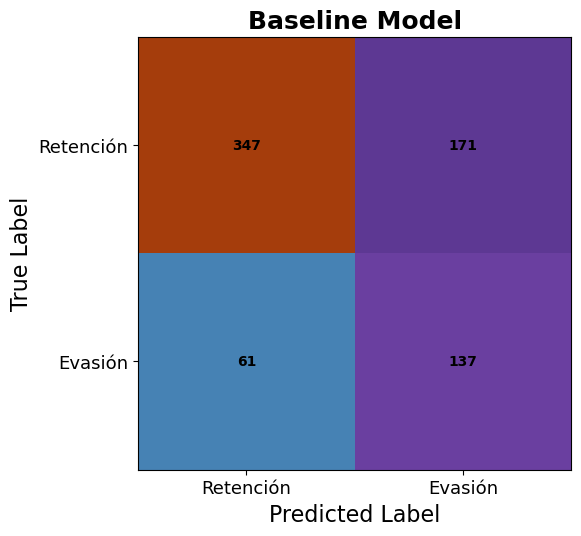

In [106]:
plot_conf_mat(baseline_model, X_test, y_test, 'Baseline Model', 'baseline')

In [107]:
# Crear una lista para almacenar los resultados de los modelos y poder realizar comparaciones.
results_tracking = []

In [108]:
baseline_results = metricas_generales(baseline_model, X_val, y_val, 'Baseline Model', 'X_train')

In [109]:
baseline_results

{'Model': 'Baseline Model',
 'Accuracy': 0.6916,
 'Precision': 0.462,
 'Recall': 0.7083,
 'F1-score': 0.5592}

## <font color='#ebac3a'>**Conclusiones: Baseline Model**</font>

El **modelo base** fue entrenado sin ajuste de hiperparámetros ni técnicas de preprocesamiento avanzadas, con el objetivo de servir como punto de comparación para modelos posteriores.

| Modelo         | Accuracy  |Precision | Recall    | F1-score | 
|----------------|-----------|----------|-----------|----------|
| Baseline Model |  69.16%   |46.20%    | 70.83%    |55.92%    |

* **Exactitud (Accuracy)** del modelo: **69.16%**
  
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

* **Recall (Sensibilidad):** el modelo es capaz de identificar correctamente al **70.83%** de los clientes que efectivamente abandonan:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

* **Precisión (Precision):** el **46.20%** de las veces que el modelo predice que un cliente abandonará, está en lo correcto:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

* **F1-score:** dado que la precisión y la sensibilidad tienen el mismo valor, el F1-score también es **55.92%**:

$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

**Objetivo**: A partir de este modelo base, se buscará **mejorar principalmente la sensibilidad (Recall)** —clave para detectar clientes en riesgo de abandono—, sin sacrificar excesivamente la precisión, la cual es importante mejorar ya que demasiados errores de Precisión pueden llevar a campañas de retención ineficientes en costos, evitando intervenciones innecesarias sobre clientes que continuarían utilizando el servicio.

In [110]:
results_tracking.append(baseline_results)

In [111]:
# Para comprobar el ajuste del entrenamiento del modelo base:
train_preds = baseline_model.predict(X_train)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1540
           1       1.00      1.00      1.00      1540

    accuracy                           1.00      3080
   macro avg       1.00      1.00      1.00      3080
weighted avg       1.00      1.00      1.00      3080



Es posible ver que el modelo memorizó el patrón en los datos de entrenamiento, devolviendo 100% en todas las métricas. Sin embargo, al generalizar en datos de validación, alcanzo aproximadamente 65% de Exactitud.

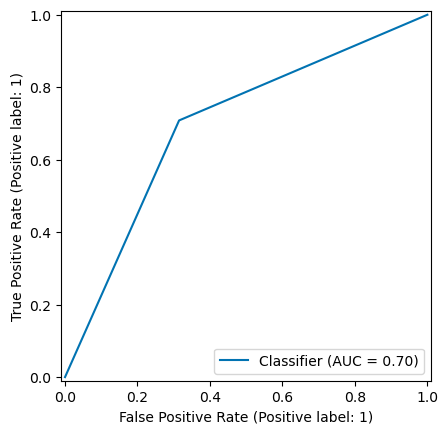

In [112]:
RocCurveDisplay.from_predictions(y_val, baseline_pred);

In [113]:
baseline_model.feature_importances_

array([0.03081924, 0.02248259, 0.01855711, 0.02133337, 0.0089492 ,
       0.0165933 , 0.00151515, 0.01493905, 0.0012987 , 0.02216568,
       0.01413218, 0.01705684, 0.01511649, 0.0144627 , 0.01452516,
       0.05174777, 0.00574237, 0.0008658 , 0.01613505, 0.01352238,
       0.00733888, 0.02153022, 0.01318513, 0.22484314, 0.23074098,
       0.18040151])

In [114]:
baseline_imporatences = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.round(baseline_model.feature_importances_, 4)}).sort_values('Importance', ascending=False)
baseline_imporatences

,Feature,Importance
24,ChargesMonthly,0.2307
23,Tenure,0.2248
25,ChargesTotal,0.1804
15,Contract_Month-to-month,0.0517
0,Gender_Male,0.0308
1,SeniorCitizen_Yes,0.0225
9,OnlineSecurity_Yes,0.0222
21,PaymentMethod_Electronic check,0.0215
3,Dependents_Yes,0.0213
2,Partner_Yes,0.0186


## <font color='#ebac3a'>**Random Forest Classifier**</font>

### <font color='#f07c3e'>**RandomForest 1 - MaxDepth = 10**</font>

In [115]:
rf_1 = RandomForestClassifier(max_depth=10, random_state=42) 

In [116]:
y_train.value_counts()

Churn
0    1540
1    1540
Name: count, dtype: int64

In [117]:
rf_1.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [118]:
rf_1_preds = rf_1.predict(X_val)
print(classification_report(y_val, rf_1_preds))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       629
           1       0.58      0.74      0.65       240

    accuracy                           0.78       869
   macro avg       0.74      0.77      0.75       869
weighted avg       0.80      0.78      0.79       869



In [119]:
rf_1_results = metricas_generales(rf_1, X_val, y_val, 'RandomForest 1', 'X_train')
rf_1_results

{'Model': 'RandomForest 1',
 'Accuracy': 0.7814,
 'Precision': 0.5817,
 'Recall': 0.7417,
 'F1-score': 0.652}

In [120]:
results_tracking.append(rf_1_results)

In [121]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520


### <font color='#8b5fc4'>**Observaciones: RandomForest - Max Depth = 10**</font>

Este modelo de ensamble consigue mejorar de forma significativa el Recall (Sensibilidad), con un aumento de aproximadamente **3.3%** respecto al modelo base.

- La **exactitud** del modelo mejora aproximadamente **9%**  
- La **precisión** mejora en torno a **12%**  
- El **F1-score**, que combina Recall y Precisión, también presenta una mejora de **9.28%**.

Si bien la mejora en **Recall** es moderada, el modelo presenta un desempeño notablemente superior en el resto de métricas.

Esto refuerza la idea de que el ensamble de múltiples árboles permite una mejor generalización de los patrones contenidos en los datos. Por esta razón, se buscará optimizar este modelo a través del ajuste de hiperparámetros.

In [122]:
columnas = X_train.columns

In [123]:
importances = np.round(rf_1.feature_importances_, 4)

In [124]:
len(columnas), len(importances)

(26, 26)

In [125]:
rf_1_importances = pd.DataFrame({'Feature': columnas, 'Importance': importances}).sort_values('Importance', ascending=False)
rf_1_importances

,Feature,Importance
23,Tenure,0.1965
25,ChargesTotal,0.1887
24,ChargesMonthly,0.1311
15,Contract_Month-to-month,0.0641
12,TechSupport_Yes,0.0358
21,PaymentMethod_Electronic check,0.0285
17,Contract_Two year,0.0285
9,OnlineSecurity_Yes,0.0280
18,PaperlessBilling_Yes,0.0261
7,InternetService_Fiber optic,0.0237


Como se ve en el análisis de importancia de características, el modelo determina que la Antigüedad (Tenure) es la principal razón para determinar la Evasión (Churn) del cliente.
Sin embargo, en el análisis de correlación, SeniorCitizen, por ejemplo, tiene un índice de correlación con la Evasión de 0.09, mientras que Gender apenas de 0.01. En la etapa previa, se observó en el análisis de datos que Género presentaba una distribución simétrica en cuanto a la Evasión, lo cual sugería que esta característica no era relevante a la hora de preveer la variable objetivo.
Si bien el objetivo de Machine Learning es dejar que el modelo encuentre las reglas apropiadas para resolver el problema en cuestión, analizaré el desempeño de un nuevo modelo con las variables seleccionadas en el segundo análisis de correlación, agregando a estas la variable ChargesMonthly.

### <font color='#f07c3e'>**Random Forest 2 - Max Depth 10 - Corr_selected Features + ChargesMonthly**</font>

In [126]:
corr_selected.columns

Index(['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
      dtype='object')

In [127]:
rf2_cols = ['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly', 'ChargesTotal']

In [128]:
rf_2 = RandomForestClassifier(max_depth=10, random_state=42)

In [129]:
rf_2.fit(X_train[rf2_cols], y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [130]:
rf_2_preds = rf_2.predict(X_val[rf2_cols])
print(classification_report(y_val, rf_2_preds))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       629
           1       0.59      0.72      0.65       240

    accuracy                           0.78       869
   macro avg       0.73      0.76      0.74       869
weighted avg       0.80      0.78      0.79       869



In [131]:
print(classification_report(y_val, rf_1_preds))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       629
           1       0.58      0.74      0.65       240

    accuracy                           0.78       869
   macro avg       0.74      0.77      0.75       869
weighted avg       0.80      0.78      0.79       869



In [132]:
importances = np.round(rf_2.feature_importances_, 4)
rf_2_importances = pd.DataFrame({'Feature': rf2_cols, 'Importance': importances}).sort_values('Importance', ascending=False)
rf_2_importances

,Feature,Importance
17,Tenure,0.2197
19,ChargesTotal,0.2112
18,ChargesMonthly,0.1534
9,Contract_Month-to-month,0.0553
8,TechSupport_Yes,0.0331
15,PaymentMethod_Electronic check,0.0324
5,OnlineSecurity_Yes,0.0321
4,InternetService_Fiber optic,0.0301
12,PaperlessBilling_Yes,0.0295
11,Contract_Two year,0.0284


In [133]:
rf_2_results = metricas_generales(rf_2, X_val[rf2_cols], y_val, 'RandomForest 2', 'X_train')

results_tracking.append(rf_2_results)

In [134]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454


### <font color='#8b5fc4'>**Observaciones: Random Forest 2 - Max Depth 10 - Corr_selected Features + ChargesMonthly**</font>

No se produjo ninguna mejora al utilizar solo las variables determinadas por el análisis de correlación. De hecho, se observa una leve caída en todas las métricas respecto a `RandomForest 1`.

### <font color='#f07c3e'>**Random Forest 3 - Max Depth = 10 - Corr_selected features (reemplazar ChargesTotal por ChargesMonthly)**</font>

`RandomForest 3` se enfocará en comprobar si al descartar la variable que mostró un alto nivel de multicolinealidad (`ChargesTotal`), el modelo se beneficia. Aunque cabe mencionar que ya se aclaró que modelos como RandomForest son robustos frente a dicho fenómeno.

In [135]:
rf3_cols = ['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly']

In [136]:
rf_3 = RandomForestClassifier(max_depth=10, random_state=42)

In [137]:
rf_3.fit(X_train[rf3_cols], y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [138]:
rf_3_preds = rf_3.predict(X_val[rf3_cols])
print(classification_report(y_val, rf_3_preds))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       629
           1       0.56      0.73      0.63       240

    accuracy                           0.77       869
   macro avg       0.72      0.76      0.73       869
weighted avg       0.79      0.77      0.78       869



In [139]:
rf_3_results = metricas_generales(rf_3, X_val[rf3_cols], y_val, 'RandomForest 3')

results_tracking.append(rf_3_results)

In [140]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341


### <font color='#8b5fc4'>**Observaciones: Random Forest 3 - Max Depth = 10 - Corr_selected features (reemplazar ChargesTotal por ChargesMonthly)**</font>

El reemplazo de `ChargesTotal` por `ChargesMonthly` produce un rendimiento inferior al mejor modelo hasta el momento (`RandomForest 1`), con una diferencia marginal en las métricas. Esto sugiere que ambas variables aportan información relevante de forma parecida. Aun así, se continuará afinando la selección de variables para mejorar la eficiencia del modelo.

### <font color='#f07c3e'>**Feature Selection**</font>

In [141]:
resultados = []

ct_features = [i if i != 0 else 1 for i in range(0, 26, 5)]

for i in ct_features:
    model_features = RandomForestClassifier(max_depth=10, random_state=42)
    selected_features = rf_1_importances['Feature'].values[:i]
    X_train_sel = X_train[selected_features]
    X_val_sel = X_val[selected_features]
    model_features.fit(X_train_sel, y_train)
    metricas = metricas_generales(model_features, X_val_sel, y_val, f'Features: {i}', 'X_train')
    resultados.append(metricas)

pd.DataFrame(resultados)

,Model,Accuracy,Precision,Recall,F1-score
0,Features: 1,0.6697,0.4259,0.5625,0.4847
1,Features: 5,0.7687,0.5670,0.6875,0.6215
2,Features: 10,0.7768,0.5799,0.6958,0.6326
3,Features: 15,0.7779,0.5786,0.7208,0.6419
4,Features: 20,0.7825,0.5876,0.7125,0.6441
5,Features: 25,0.7722,0.5673,0.7375,0.6413


Teniendo en cuenta que estamos priorizando el Recall, ya que el objetivo es identificar aquellos clientes potenciales a cancelar sus servicios, el modelo que mejor se desempeña utiliza las 25 características más importantes (solo se descarta una).
Sin embargo, estas métricas no logran superar al modelo `RandomForest 1`

Esto sugiere que este algoritmo se beneficia al tener mayor información. Por lo que a continuación, se ejecutará un GridSearch para determinar los mejores hiperparámetros para el modelo.

### <font color='#f07c3e'>**Random Forest 4 - Grid SearchCV**</font>

Se ejecutará un Grid Search para definir los hiperparámetros que mejor se ajusten al modelo, una vez obtenidos, se entrenará el mejor modelo posible para evaluar sus resultados.

In [142]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 150, 200, 250]
}

rf_4 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=kf)

rf_4.fit(X_train, y_train)

C:\Users\Ignacio\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5, 7],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='recall')

In [143]:
rf_4.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 150}

In [144]:
rf_4_results = metricas_generales(rf_4, X_val, y_val, 'RandomForest 4', 'X_train')
results_tracking.append(rf_4_results)

Se conservará codigo en caso de necesitar reejecutar el script con los mejores hiperparámetros para evitar la necesidad de correr el GridSearch ya que toma cierto tiempo para su ejecución.

#### **Hiperparámetros encontrados por GridSearchCV**

{'max_depth': 5,<br>
 'min_samples_leaf': 1,<br>
 'min_samples_split': 3,<br>
 'n_estimators': 150}

#### **Nota**:

Se conservará codigo entrenando el modelo con los hiperparámetros encontrados por GridSearch en caso de necesitar correr el script nuevamente, para no consumir recursos ni tiempo.

In [145]:
#rf_4 = RandomForestClassifier(max_depth=5, min_samples_split=3, min_samples_leaf=1, n_estimators=150, random_state=42)
#rf_4.fit(X_train, y_train)
#rf_4_results = metricas_generales(rf_4, X_val, y_val, 'RandomForest 4', 'X_train')
#results_tracking.append(rf_4_results)
#pd.DataFrame(results_tracking)

In [146]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283


### <font color='#8b5fc4'>**Observaciones: Random Forest 4 - GridSearchCV**</font>

A pesar de utilizar `GridSearchCV` para la exploración de hiperparámetros, el modelo muestra una performance muy baja, se puede observar que su desempeño se encuentra cercano al `Baseline Model`.
Esto puede indicar que el espacio del GirdSearch no fue el adecuado, se llevará a cabo nuevamente con con hiperparámetros más flexibles para evitar subajuste

### <font color='#f07c3e'>**Random Forest 5 - GridSearchCV**</font>

Por último, ya que al utilizar 25 variables en vez de las 26 totales no pordujo mejoras, se entrenará un último RandomForest utilizando un grid reducido para GridSearch con el objetivo de mejorar las métricas obtenidas.

In [147]:
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 150, 200]
}

rf_5 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=kf)

rf_5.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 150, 200]},
             scoring='recall')

In [148]:
rf_5.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 150}

In [149]:
#rf_5 = RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, n_estimators=150, random_state=42)
#rf_5.fit(X_train, y_train)
#rf_5_results = metricas_generales(rf_5, X_val, y_val, 'RandomForest 5', 'X_train')
#results_tracking.append(rf_5_results)
#pd.DataFrame(results_tracking)

In [150]:
rf_5_results = metricas_generales(rf_5, X_val, y_val, 'RandomForest 5', 'X_train')
results_tracking.append(rf_5_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283


In [151]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'wb') as f:
    pickle.dump(rf_1, f)

## <font color='#ebac3a'>**Conclusiones Random Forest Classifier**</font>

Luego de entrenar 5 modelos distintos, el que demostró **mejor desempeño general** fue `RandomForest 1`, el cual utilizó **todas las variables sin filtrado previo**, y solo con el hiperparámetro `max_depth=10`. Esto sugiere que, en este caso, el modelo más simple, con más información, fue el que mejor logró capturar el patrón de evasión de clientes. 

Sin embargo, es posible que esto signifique un sobreajuste en los datos de entrenamiento, debido a la menor cantidad de restricciones en la separación de nodos.

El algoritmo de **Random Forest Classifier** fue capaz de superar en todos los experimentos al modelo base (`Decision Tree Classifier`).

El mejor modelo fue `RandomForest 1`, con una mejora de **Recall** sobre el modelo base más de **3.34%**, y una performance general al evaluar **F1-score** de **9.28%**.

Esto prueba la capacidad de dicha arquitectura de manejar variables en distintas escalas y llegar a una clasificación correcta general de **78.14%** (**Accuracy**)

## <font color='#ebac3a'>**Logistic Regresion**</font>

A diferencia del modelo RandomForest, la Regresión Logística es sensible a outliers y a la escala de los datos. Además, a menos que se utilice la regularización Lasso que penaliza la complejidad del modelo, este, también es sensible a la multicolinealidad.

Por esta razón, se iniciará entrenando una **Regresión Logística** básica, utilizando los datos de entrenamiento `X_linear`, el cual fue codificado con `OneHotEncoder(drop='first')`. 

Además, se creará un nuevo conjunto para la regularización Lasso, con el encoding `OneHotEncoder(drop='if_binary')` pero con las variables numéricas escaladas ya que este modelo es sensible a la escala de los datos.

In [152]:
X_scaled = df_scale.drop('Churn', axis=1)
y_scaled = df_scale['Churn']

x_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']

X_lr_num = X_scaled[x_num]

X_lr_num = robust_scaler.fit_transform(X_lr_num)

X_scaled[['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_lr_num

In [153]:
X_scaled = X_scaled.drop(['Tenure', 'ChargesMonthly', 'ChargesTotal'], axis=1)

In [154]:
X_scaled.head()

,Gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,NoInternetService,OnlineSecurity_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_scaled,ChargesMonthly_scaled,ChargesTotal_scaled
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.617021,-0.939982,-0.396935
1,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.787234,-0.196676,0.726135
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.638298,0.537396,1.288963
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.574468,-0.657433,-0.373961
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.702128,0.168975,0.971250


In [155]:
X_scaled, X_scaled_test, y_scaled, y_scaled_test = tts(X_scaled, y_scaled, test_size=0.1, stratify=y_scaled, random_state=42)

In [156]:
X_scaled_train, X_scaled_val, y_scaled_train, y_scaled_val = tts(X_scaled, y_scaled, test_size=0.135, stratify=y_scaled, random_state=42)

In [157]:
X_scaled_train, y_scaled_train = undersampler.fit_resample(X_scaled_train, y_scaled_train)

In [158]:
X_scaled_train.shape, y_scaled_train.shape

((3080, 26), (3080,))

In [159]:
X_scaled_val.shape, y_scaled_val.shape

((869, 26), (869,))

In [160]:
X_scaled_test.shape, y_scaled_test.shape

((716, 26), (716,))

In [161]:
y_scaled_train.value_counts()

Churn
0    1540
1    1540
Name: count, dtype: int64

In [162]:
y_scaled_val.value_counts()

Churn
0    629
1    240
Name: count, dtype: int64

In [163]:
y_scaled_test.value_counts()

Churn
0    518
1    198
Name: count, dtype: int64

### <font color='#f07c3e'>**LogisticRegression 1**</font>

In [164]:
from sklearn.linear_model import LogisticRegression

In [165]:
lr_1 = LogisticRegression(random_state=42)

In [166]:
lr_1.fit(X_linear_train, y_linear_train)

LogisticRegression(random_state=42)

In [167]:
lr_1_results = metricas_generales(lr_1, X_linear_val, y_linear_val, 'LogisticRegression 1')
results_tracking.append(lr_1_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089


### <font color='#8b5fc4'>**Observaciones: Resultados LogisticRegression 1**</font>

* El modelo `LogisticRegression 1` logró un **Recall = 0.6292**, el cual no supera a siquiera al modelo base (`Baseline Model`).

* A su vez, la **Precisión = 0.5898** cayó considerablemente respecto a los modelos de `Random Forest`, siendo esta aproximadamente **11%** más baja que en `RandomForest 1`. Esto se traduce en un **F1-score = 0.6089**, lo que muesta un rendimiento general **4.4%** más bajo.

Se explorará a continuación la reducción de dimensionalidad evaluando los coeficientes del modelo, con el objetivo de explorar si es posible mejorar la capacidad predictiva al simplificar el modelo.

In [168]:
features = X_linear.columns

In [169]:
coeficients = lr_1.coef_
coeficients

array([[ 0.03928646,  0.26413841, -0.02367499, -0.06855762, -0.30415302,
         0.22595909,  0.54606565,  0.02273474, -0.14439842,  0.0157389 ,
        -0.02590842, -0.15906767,  0.21369557,  0.24650399, -0.09457467,
         0.05567536,  0.24728725,  0.05749977,  0.26907694,  0.10729621,
        -1.6898608 , -0.04453168,  0.46869679]])

In [170]:
lr_1_coeficients = pd.DataFrame({'Feature': features, 'Coeficiente': coeficients[0]}).sort_values('Coeficiente', ascending=False)
intercept = pd.DataFrame({'Feature': ['Intercept'], 'Coeficiente': [lr_1.intercept_[0]]})
lr_1_coeficients = pd.concat([lr_1_coeficients, intercept], ignore_index=True)
lr_1_coeficients

,Feature,Coeficiente
0,InternetService_Fiber optic,0.546066
1,ChargesTotal_scaled,0.468697
2,PaymentMethod_Electronic check,0.269077
3,SeniorCitizen_Yes,0.264138
4,PaperlessBilling_Yes,0.247287
5,StreamingMovies_Yes,0.246504
6,MultipleLines_Yes,0.225959
7,StreamingTV_Yes,0.213696
8,PaymentMethod_Mailed check,0.107296
9,PaymentMethod_Credit card (automatic),0.057500


### <font color='#8b5fc4'>**Observaciones: Coeficientes LogisticRegression 1**</font>

#### Variables Numéricas

Ha de tenerse en cuenta que las variables numéricas han sido escaladas, por lo que su interpretación es por cambio en unidades escaladas *(RobustScaler)*. Aun así, la dirección e importancia relativa son claras:

* **Tenure_scaled = -1.68:**

Es el coeficiente más fuerte en valor absoluto, y negativo, lo que indica que a **mayor antigüedad (tenure), menor probabilidad de churn**.
Tiene más peso que ninguna otra variable, lo cual es coherente: clientes más fieles abandonan menos.
O visto desde otro punto, los clientes tienden a abandonar en las etapas tempranas de la relación con la empresa.

* **ChargesMonthly_scaled = -0.04:**

Cuanto mayor es el pago mensual, ligeramente menor es la probabilidad de churn. Esto puede parecer contraintuitivo, pero **podría reflejar que los clientes con servicios más caros están más comprometidos.**

**ChargesTotal_scaled = +0.46:**

Aquí surge una contradicción: el coeficiente positivo indica que los clientes que han pagado mucho tienen mayor probabilidad de churn. Pero dada la naturaleza acumulativa de esta variable, los clientes que han pagado mucho tienen por ende mayor antigüedad.
Esto posiblemente esté relacionado a los outliers observados anteriormente, que corresponden a clientes de alto valor que están abandonando.

Esto, como se observó en la etapa anterior, es un dato clave para acciones comerciales: clientes que ya generaron muchos ingresos, pero están por irse requieren especial atención.

#### Variables Categóricas

* **InternetService_FiberOptic** = **0.54**

Mayor factor de riesgo de abandono segun la regresión logisica entrenada (`LogisticRegression 1`). Se ajusta a lo observado en la etapa de exploración donde se descubrió que este servicio presentaba la mayor tasa de evasión en relación a `DSL` o `No Internet Service`

* **Contract_One year = -0.09** y **Contract_Two year = +0.05:**

Aquí los coeficientes estan en relación a la variable descartada por `OneHotEncoder(drop='first')`, que en este caso es `Contract_Month-to-month`.
Comparado con tener un contrato "Month-to-month", tener un contrato de un año (One year) reduce los log-odds de churn en 0.09 unidades, y tener un contrato de dos años (Two year) los reduce aumenta los log-odds en 0.05. Esto, en relación al análisis de la etapa anterior, contradice lo hallado donde se observó que clientes con contrato de 2 años tenían la menor tasa de abandono en relación a los otros tipos de contrato.

* **PaperlessBilling_Yes = +0.34:**

Menos fidelidad de los clientes digitalizados

* **InternetService_Fiber optic = +0.39:**

Tener fibra óptica se asocia a más churn, lo cual es consistente con lo observado en la etapa anterior del proyecto donde se concluyó que existía insatisfacción con este servicio.

* **PaymentMethod_Electronic check = +0.31:**

Posible problema con el servicio de factura electrónica.


* **TechSupport_Yes = -0.40, OnlineSecurity_Yes = -0.40:**

Tener servicios de soporte o seguridad reduce el churn. Esto confirma también uno de los análisis de la etapa anterior donde se determinó que servicios extra contribuían a mayor retención.

* **PhoneService_Yes = -0.64:**

Clientes que cuentan con servicio telefónico tienden a quedarse.

* **Dependents_Yes = -0.27:**

Esto resulta interesante, ya que a diferencia de lo analizado en la etapa anterior, indica que los clientes que tienen personas a cargo tienen menor probabilidad de abandono.

* **PaymentMethod_Mailed check = -0.06:**

Los clientes con facturación por correo tienden a ser más fieles, lo que resalta la posibilidad de que exista insatisfacción con los servicios digitales.

* **Gender_Male = -0.03**

A diferencia de los arboles de decisión que dieron cierta importancia a esta variable, en el caso de la Regresión Logística, esta variable es despreciable ya que su coeficiente resulta cercano a 0, lo cual esta en armonía con lo analizado en la etapa anterior del proyeco donde se observó que el género no parecía ser un determinante de Evasión (Churn)

### <font color='#f07c3e'>**LogisticRegression 2 - Feature Selection**</font>

Se seleccionarán las variables que tengan un coeficiente mayor a 0.2 en valor absoluto, para reducir la dimensionalidad del modelo y evaluar sus resultados.

In [171]:
lr_1_coeficients = pd.DataFrame({'Feature': features, 'Coeficiente': coeficients[0]}).sort_values('Coeficiente', ascending=False)
lr_1_principales_coeficientes = lr_1_coeficients[lr_1_coeficients['Coeficiente'].abs() > 0.2]
lr_1_principales_coeficientes

,Feature,Coeficiente
6,InternetService_Fiber optic,0.546066
22,ChargesTotal_scaled,0.468697
18,PaymentMethod_Electronic check,0.269077
1,SeniorCitizen_Yes,0.264138
16,PaperlessBilling_Yes,0.247287
13,StreamingMovies_Yes,0.246504
5,MultipleLines_Yes,0.225959
12,StreamingTV_Yes,0.213696
4,PhoneService_Yes,-0.304153
20,Tenure_scaled,-1.689861


In [172]:
selected_features = lr_1_principales_coeficientes['Feature'].values
selected_features

array(['InternetService_Fiber optic', 'ChargesTotal_scaled',
       'PaymentMethod_Electronic check', 'SeniorCitizen_Yes',
       'PaperlessBilling_Yes', 'StreamingMovies_Yes', 'MultipleLines_Yes',
       'StreamingTV_Yes', 'PhoneService_Yes', 'Tenure_scaled'],
      dtype=object)

In [173]:
cv_results = cross_validate(LogisticRegression(random_state=42), X_linear[selected_features], y_scaled, scoring='recall', cv=kf)
cv_results

{'fit_time': array([0.03293514, 0.03472662, 0.03050303, 0.03255725, 0.02965856,
        0.03217554]),
 'score_time': array([0.00824594, 0.00836325, 0.00742149, 0.00762844, 0.00748825,
        0.0072577 ]),
 'test_score': array([0.47811448, 0.45117845, 0.51515152, 0.53198653, 0.52364865,
        0.43918919])}

In [174]:
cv_results['test_score'].mean()

0.489878135711469

In [175]:
lr_2 = LogisticRegression(random_state=42)

lr_2.fit(X_linear_train[selected_features], y_linear_train)

lr_2_results = metricas_generales(lr_2, X_linear_val[selected_features], y_linear_val, 'LogisticRegression 2')
results_tracking.append(lr_2_results)

In [176]:
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885


### <font color='#8b5fc4'>**Observaciones: Resultados LogisticRegression 2 - Selected Features**</font>

Al establecer un umbral para el valor de los coeficientes del primer modelo de Regresión Logistica, se seleccionaron los siguientes features:

* `InternetService_Fiber optic`
* `ChargesTotal_scaled`
* `PaymentMethod_Electronic check`
*  `SeniorCitizen_Yes`
* `PaperlessBilling_Yes`
* `StreamingMovies_Yes`
* `MultipleLines_Yes`
* `StreamingTV_Yes`
* `PhoneService_Yes`
* `Tenure_scaled`

Esta selección permitió una reducción de dimensionalidad, que se tradujo en una mejora en todas las métricas evaluadas con respecto al modelo completo:

* **Accuracy, Recall y F1-score caen levemente, lo que indica que el modelo no se beneficia de tanta reducción de la información.**

* **El nuevo modelo (`LogisticRegression 2`) es más simple, pero no consigue un desempeño óptimo.**

En resumen, la selección arbitraria de variables a partir de los coeficientes obtenidos en `LogistcRegression 1` no trajo mejoras al modelo.

### <font color='#f07c3e'>**LogisticRegression 3 - Penalty Lasso (L1)**</font>

Ya que la selección de variables ha sido realizada manualmente, al seleccionar un umbral arbitrario para los coeficientes de un valor absoluto de 0.2, se llevará a cabo el entrenamiento de otro modelo de Regresión Logística utilizando la regularización Lasso (L1), que penaliza aquellas variables que no aportan poder predictivo al modelo, teniendo la capacidad de llevar dichos coeficientes a 0.

Esta regularización, permite manejar la multicolinealidad, por lo que el siguiente experimento se llevará a cabo con el conjunto de datos `X_scaled`, que presenta la misma codificación que el conjunto utilizado para **RandomForest**, pero con las variables numéricas escaladas.

In [177]:
cv_results = cross_validate(LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42),X_scaled, y_scaled, scoring='recall', cv=kf)
cv_results

{'fit_time': array([0.29598475, 0.35684896, 0.28640079, 0.36377668, 0.22320986,
        0.13137984]),
 'score_time': array([0.00636077, 0.0085566 , 0.00896406, 0.0085628 , 0.00572681,
        0.00674081]),
 'test_score': array([0.51178451, 0.50505051, 0.55892256, 0.55892256, 0.5472973 ,
        0.51013514])}

In [178]:
cv_results['test_score'].mean()

0.5320187611854278

In [179]:
lr_3 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

lr_3.fit(X_scaled_train, y_scaled_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [180]:
features = X_scaled_train.columns

In [181]:
coeficientes_lr3 = lr_3.coef_[0]
coeficientes_lr3 = pd.DataFrame({'Feature': features, 'Coeficiente': coeficientes_lr3}).sort_values('Coeficiente', ascending=False)
coeficientes_lr3

,Feature,Coeficiente
24,ChargesMonthly_scaled,0.637699
1,SeniorCitizen_Yes,0.294384
5,MultipleLines_Yes,0.219525
25,ChargesTotal_scaled,0.209662
18,PaperlessBilling_Yes,0.191609
21,PaymentMethod_Electronic check,0.190870
17,Contract_Two year,0.112961
13,StreamingTV_Yes,0.110037
14,StreamingMovies_Yes,0.099353
0,Gender_Male,0.033434


In [182]:
lr_3_results = metricas_generales(lr_3, X_scaled_val, y_scaled_val, 'LogisticRegression 3')
results_tracking.append(lr_3_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935


### <font color='#8b5fc4'>**Observaciones: Resultados LogisticRegression 3 - Penalty Lasso (L1)**</font>

Al comparar el modelo con selección manual de variables mediante un umbral arbitrario (`LogisticRegression 2`) con el modelo entrenado utilizando penalización Lasso (`LogisticRegression 3`), se observa que **este último no mejora ninguna de las métricas evaluadas**.

La regularización L1 **automatizó la selección de variables**, reduciendo a cero los coeficientes de aquellas consideradas poco relevantes por el modelo:

- **PaymentMethod_Credit card (automatic)**
- **Contract_One year**
- **NoInternetService**


Su desempeño global es levemente mejor, sin embargo, no supera ni a `LogisticRegression 1` ni a `RandomForest 1` (modelo con mejor performance hasta el momento).

La métrica prioritaria (**Recall**) se mantuvo constante entre ambos modelos, pero tanto **Precision como F1-score** fueron inferiores en el modelo con penalización L1.

### <font color='#f07c3e'>**LogisticRegression 4 - Penalty Lasso - conjunto X_linear**</font>

Se entrenará ahora sobre el conjunto de datos utilizado inicialmente en Regresión Logística.

In [183]:
lr_4 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

lr_4.fit(X_linear_train, y_linear_train)

lr_4_results = metricas_generales(lr_4, X_linear_val, y_linear_val, 'LogisticRegression 4')
results_tracking.append(lr_4_results)

pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: Resultados LogisticRegression 4**</font>

Es posible observar que este modelo mantiene una métrica de **Recall** identica al primer experimento dentro de esta familia, pero consigue mejorar el resto de métricas, lo que implica que a pesar de ser capaz de manejar la multicolinealidad a través de la regularización, el modelo se sigue viendo afectado por este fenómeno.

### <font color='#f07c3e'>**LogisticRegression 5 - GridSearchCV**</font>

Para finalizar este tipo de modelado, se realizara un GridSearch para determinar el mejor C (parámetro que controla la intensidad de la regularización) para hallar el mejor modelo posible.

In [184]:
param_grid = {'C': [0.7, 1.0, 1.2, 2.0],
             'max_iter': [100, 150, 200]}


lr_5 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=42), 
                     param_grid=param_grid,
                     scoring='recall',
                     cv=kf)

lr_5.fit(X_linear_train, y_linear_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.7, 1.0, 1.2, 2.0],
                         'max_iter': [100, 150, 200]},
             scoring='recall')

In [185]:
lr_5.best_params_

{'C': 2.0, 'max_iter': 100}

In [186]:
#lr_5 = LogisticRegression(penalty='l1', solver='liblinear', C=0.7, random_state=42)

#lr_5.fit(X_linear_train, y_linear_train)

#lr_5_results = metricas_generales(lr_5, X_linear_val, y_linear_val, 'LogisticRegression 5')
#results_tracking.append(lr_5_results)

#pd.DataFrame(results_tracking)

In [187]:
lr_5_results = metricas_generales(lr_5, X_linear_val, y_linear_val, 'LogisticRegression 5')
results_tracking.append(lr_5_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: Resultados LogisticRegression 5 - GridSearch**</font>

Aunque el **GridSearchCV determinó que el mejor valor del hiperparámetro C era 1.2** (lo que implica una penalización más leve y por ende menos coeficientes reducidos a cero), esto permite superar levemente las métricas producidas por los experimentos anteriores.

### <font color='#f07c3e'>**LogisticRegression 6 - Descartando ChargesTotal**</font>

In [188]:
Xn_linear_train = X_linear_train.drop('ChargesTotal_scaled', axis=1)
Xn_linear_val = X_linear_val.drop('ChargesTotal_scaled', axis=1)
Xn_linear_test = X_linear_test.drop('ChargesTotal_scaled', axis=1)

In [189]:
Xn_linear_test.columns

Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled'],
      dtype='object')

In [190]:
lr_6 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)

lr_6.fit(Xn_linear_train, y_scaled_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [191]:
lr_6_results = metricas_generales(lr_6, Xn_linear_val, y_linear_val, 'LogisticRegression 6')
results_tracking.append(lr_6_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: Resultados LogisticRegression 6 - Descartando ChargesTotal**</font>

Se observa que al descartar `ChargesTotal_scaled` resulta en una depreciación en el desempeño del modelo, a pesar de que esta mostraba un alto índice de multicolinealidad. 

Esto demuestra que la regularización **Lasso (L1)** es capaz de manejar dicho fenómeno, permitiendo al modelo **generalizar el patrón presente en los datos** al contar con mayor información, y descartando matemáticamente aquellas variables que **no aportan poder predictivo**.

En consecuencia, aunque `ChargesTotal_scaled` está altamente correlacionada con otras variables como `Tenure_scaled`, su exclusión puede **empobrecer el rendimiento predictivo del modelo**, lo que refuerza la idea de que es preferible **confiar en la regularización** antes que eliminar variables por multicolinealidad en modelos penalizados.

In [321]:
param_grid = {'C': [0.7, 1.0, 1.2, 2.0],
             'max_iter': [100, 150, 200]}


lr_6 = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', random_state=42), 
                     param_grid=param_grid,
                     scoring='recall',
                     cv=kf)

lr_6.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.7, 1.0, 1.2, 2.0],
                         'max_iter': [100, 150, 200]},
             scoring='recall')

In [322]:
lr_6_results = metricas_generales(lr_6, X_val, y_val, 'LinearRegression 6')
results_tracking.append(lr_6_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


In [323]:
lr_6_results = metricas_generales(lr_6, X_test, y_test, 'LinearRegression 6 - Eval')
results_tracking.append(lr_6_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


## <font color='#ebac3a'>**Conclusiones Logistic Regression**</font>

Dentro de los modelos de regresión logística evaluados, el mejor desempeño en términos de F1-score fue alcanzado por `LogisticRegression 5`. Utilizando el conjunto X_linear (`one_hot_encoder(drop='first)`) y utilizando **regularización L1 (Lasso)**, que permite una **selección automática de variables** mediante la penalización de coeficientes irrelevantes.

| Modelo               | Accuracy | Precision | Recall | F1-score |
|----------------------|----------|-----------|--------|----------|
| LogisticRegression 5 |0.7814	  |0.5984	  |0.6333  |0.6154    |

Dado que el objetivo principal es **maximizar la sensibilidad (Recall)** y al mismo tiempo obtener un modelo interpretable y justificable, se selecciona<br>`LogisticRegression 5` como el **mejor modelo de su familia**.


**Resumen:**
* `LogisticRegression 5` es seleccionado por su robustez teórica, buena capacidad predictiva y automatización de la selección de variables.
* A pesar de su buen rendimiento, **ninguno de los modelos de regresión logística logró superar a los modelos de Random Forest**, los cuales alcanzaron mejores métricas generales, especialmente en Recall y F1-score.

In [192]:
with open(MODELS_PATH / 'best_log_regression.pkl', 'wb') as f:
    pickle.dump(lr_5, f)

In [193]:
best_models = []
best_models.append(rf_1_results)
best_models.append(lr_5_results)

pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 1,0.7814,0.5817,0.7417,0.6520
1,LogisticRegression 5,0.7814,0.5984,0.6333,0.6154


## <font color='#ebac3a'>**K-Nearest Neighbors (KNN)**</font>

El modelo K-Nearest Neighbors (KNN) es un clasificador basado en la proximidad entre observaciones, utilizando por defecto la distancia euclídea como métrica.
Esto lo hace particularmente sensible a la escala de las variables y a la presencia de outliers, ya que estos pueden influir fuertemente en el cálculo de las distancias.

Además, el desempeño del modelo depende fuertemente del parámetro k, que define cuántos "vecinos" se consideran para determinar la clase de una nueva observación. Valores de k muy bajos pueden llevar a sobreajuste, mientras que valores demasiado altos pueden suavizar excesivamente las fronteras de decisión.

Debido a que KNN no aprende una función explícita durante el entrenamiento, sino que realiza los cálculos de distancia durante la predicción, se considera un modelo perezoso y relativamente costoso computacionalmente en grandes conjuntos de datos (si bien no es el caso ya que el conjunto de datos balanceado cuenta con aproximadamente 4000 observaciones).

Por estas razones, se realizará inicialmente una búsqueda de hiperparámetros mediante GridSearch para determinar el valor óptimo de k.

En cuanto al preprocesamiento, se reutilizarán las variables numéricas escaladas con RobustScaler del apartado anterior (Logistic Regression), ya que esto ayuda a mitigar la influencia de outliers y mejora la comparabilidad entre variables.

### <font color='#f07c3e'>**KNN 1 - GridSearch**</font>

In [194]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [20, 25, 30, 35, 40]}

knn_1 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=kf)

knn_1.fit(X_scaled_train, y_scaled_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [20, 25, 30, 35, 40],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [195]:
knn_1.best_params_

{'leaf_size': 20, 'n_neighbors': 5}

In [196]:
knn_1_results = metricas_generales(knn_1, X_scaled_val, y_scaled_val, 'KNN 1')
knn_1_results

{'Model': 'KNN 1',
 'Accuracy': 0.7066,
 'Precision': 0.4747,
 'Recall': 0.5875,
 'F1-score': 0.5251}

In [197]:
results_tracking.append(knn_1_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: KNN 1 - GridSearch**</font>

El GridSearch determinó que los hiperparámetros óptimos para el modelo son:

* `leaf_size = 20`
* `n_neighbors = 5`

Sin embargo, las metricas obtenidas por este son de muy bajo rendimiento, sin siquiera superar al `Baseline Model`.

Esto refleja un **trade-off desfavorable**, ya que si bien se logra identificar más clientes que efectivamente abandonan (TP), la Precisión del modelo es **6.4%** más baja, lo que significa que se incurre en una mayor cantidad de **falsos positivos**, lo que podría implicar **destinar recursos innecesarios** a retener clientes que en realidad no se irían.

Además, dado que **KNN realiza los cálculos de distancia en tiempo de predicción,** no es el modelo más adecuado para un entorno de producción donde se requiera velocidad de respuesta. Por lo que se realizará un último experimento con `K-Nearest Neighbors`, utilizando los hiperparámetros encontrados con `GridSearchCV`, esta vez utilizando **solo las variables seleccionadas por** `LogisticRegression 5`, que fueron determinadas como relevantes por medio de la penalización L1. Esto permitirá evaluar si un conjunto reducido de variables mejora el desempeño general y reduce el sobreajuste.

### <font color='#f07c3e'>**KNN 2 - Selected Features**</font>

In [ ]:
lr_5_coef = lr_5.best_estimator.coef_
lr_5_features = X_linear_train.columns

coeficientes_lr_5 = pd.DataFrame({'Feature': lr_5_features, 'Coeficiente': lr_5_coef})

In [198]:
selected_features

array(['InternetService_Fiber optic', 'ChargesTotal_scaled',
       'PaymentMethod_Electronic check', 'SeniorCitizen_Yes',
       'PaperlessBilling_Yes', 'StreamingMovies_Yes', 'MultipleLines_Yes',
       'StreamingTV_Yes', 'PhoneService_Yes', 'Tenure_scaled'],
      dtype=object)

In [199]:
X_scaled.columns

Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'NoInternetService',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled'],
      dtype='object')

In [200]:
knn_2 = knn(n_neighbors=7, leaf_size=20)

knn_2.fit(X_scaled_train[selected_features], y_scaled_train)

knn_2_results = metricas_generales(knn_2, X_scaled_val[selected_features], y_scaled_val, 'KNN 2')
knn_2_results

{'Model': 'KNN 2',
 'Accuracy': 0.702,
 'Precision': 0.468,
 'Recall': 0.5792,
 'F1-score': 0.5177}

In [201]:
results_tracking.append(knn_2_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: KNN 2 - Selected Features**</font>

El modelo `KNN 2`, entrenado únicamente con las variables seleccionadas por LogisticRegression 3, presentó un desempeño inferior al anterior.

Esto indica que reducir la dimensionalidad en el caso de KNN perjudica significativamente su desempeño, probablemente porque este tipo de modelo se beneficia de tener más dimensiones para calcular la distancia entre observaciones.

Sin embargo, `K-Nearest Neighbors` no logró un **Recall competitivo (0.5875)**, pero aún así se lo conservará como el modelo representativo de esta familia para las comparaciones finales.

In [202]:
with open(MODELS_PATH / 'best_knn.pkl', 'wb') as f:
    pickle.dump(knn_1, f)

In [203]:
best_models.append(knn_1_results)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 1,0.7814,0.5817,0.7417,0.6520
1,LogisticRegression 5,0.7814,0.5984,0.6333,0.6154
2,KNN 1,0.7066,0.4747,0.5875,0.5251


## <font color='#ebac3a'>**Conclusiones K-Nearest Neighbors (KNN)**</font>

Si bien el modelo `K-Nearest Neighbors` no consigue mejorar en las métricas de las familias anteriores. Especialmente en **Recall**, con aproximadamente **4%** menor a la Regresión Logística seleccionada y casi **16%** menor que el modelo con mejor desempeño hasta el momento (`RandomForest 1`)

Se observó una reducción de más del **10%** en la `Precisión (Precision)` y casi un **8%** en la `Exactitud (Accuracy)`, lo que afectó negativamente al `F1-score`, que disminuyó en aproximadamente **12%** en relación a `RandomForest 1`.

Dado que este modelo no consigue un buen desempeño y que también presenta desventajas computacionales para su implementación en producción, se concluye que **no resulta ser una alternativa superadora** frente a otras arquitecturas evaluadas.

## <font color='#ebac3a'>**XGBoost Classifier**</font>

**XGBoost** es un algoritmo de machine learning basado en **árboles de decisión**. Construye múltiples árboles simples de forma **secuencial**, donde cada nuevo árbol intenta **corregir los errores** cometidos por los anteriores. De esta manera, cada iteración mejora progresivamente el desempeño del modelo.

Una de las razones por las que XGBoost es tan utilizado es que es **rápido**, **eficiente**, **maneja distintos tipos de datos** (incluyendo transformaciones automáticas mediante hiperparámetros), y suele lograr **muy buenos resultados**. Además, incluye múltiples mecanismos para **controlar el sobreajuste**, entre los cuales se destacan:

* **`max_depth`**: Limita la profundidad de los árboles, ayudando a evitar modelos demasiado complejos.
* **`min_child_weight`**: Controla la cantidad mínima de observaciones necesarias para dividir una hoja; al aumentarlo, se evita que el modelo haga divisiones poco significativas.
* **`reg_alpha` (L1 regularization)**: Penaliza el uso excesivo de variables, ayudando a simplificar el modelo.
* **`early_stopping`**: Detiene el entrenamiento si la métrica de evaluación (como **binary log loss**) no mejora luego de un número determinado de iteraciones.
* **`learning_rate`** (también `eta`): Controla el tamaño del paso de actualización. Un valor más bajo hace que el modelo aprenda más lentamente, pero reduce el riesgo de sobreajuste.

Además, este modelo es robusto frente al manejo de escalas y outliers, por lo que no es necesario reescalar las variables.

### ***Nota:***  
*Dado que XGBoost ofrece una gran cantidad de hiperparámetros que pueden ajustarse, se comenzará con un modelo base utilizando algunos valores por defecto (exceptuando `max_depth`, que se establece en 10). Luego, se aplicará `GridSearchCV` para optimizar algunos de los hiperparámetros más relevantes en función del problema y la métrica prioritaria (`recall`).*

### <font color='#f07c3e'>**XGB Classifier 1 - Max Depth = 10**</font>

In [204]:
xgb_1 = XGBClassifier(max_depth=10, random_state=42, early_stopping_rounds=5, eval_metric='logloss')

xgb_1.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [205]:
xgb_1_results = metricas_generales(xgb_1, X_val, y_val, 'XGB Classifier 1')
xgb_1_results

{'Model': 'XGB Classifier 1',
 'Accuracy': 0.748,
 'Precision': 0.5323,
 'Recall': 0.7208,
 'F1-score': 0.6124}

In [206]:
results_tracking.append(xgb_1_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


In [207]:
best_models

[{'Model': 'RandomForest 1',
  'Accuracy': 0.7814,
  'Precision': 0.5817,
  'Recall': 0.7417,
  'F1-score': 0.652},
 {'Model': 'LogisticRegression 5',
  'Accuracy': 0.7814,
  'Precision': 0.5984,
  'Recall': 0.6333,
  'F1-score': 0.6154},
 {'Model': 'KNN 1',
  'Accuracy': 0.7066,
  'Precision': 0.4747,
  'Recall': 0.5875,
  'F1-score': 0.5251}]

### <font color='#8b5fc4'>**Observaciones: Resultados XGB Classifier 1 - Max Depth = 10**</font>

XGB Classifier 1 no logró superar a `Random Forest 1`:

| Modelo               | Recall | F1-score |
|----------------------|--------|----------|
| RandomForest 1       | 0.7417 | 0.6520   |
| XGB Classifier 1     | 0.7208 | 0.6124   |
<br>

Sin embargo este modelo supera tanto a `LogisticRegression 5` y `KNN 1`. Dado que fue entrenado con sus valores por defecto, se buscarán los mejores hiperparámetros con el objetivo de superar las métricas iniciales de esta familia.

### <font color='#f07c3e'>**XGB Classifier 2 - GridSearchCV - n_estimators = 1000**</font>

Se llevará a cabo el GridSearch utilizando un número elevado de estimadores (cantidad de árboles que creará el modelo) para que dicha cantidad no limite el entrenamiento. 

Se contará además con el mecanismo de `early_stopping_rounds = 5`, que detendrá el entrenamiento si la métrica de evaluación (`logloss`) no mejora durante 5 rondas consecutivas.

In [208]:
param_grid = {
    'max_depth': [10, 15, 20],
    'min_child_weight': [2, 5],
    'reg_alpha': [0.8, 1.0, 1.2],
    'gamma': [0, 0.1, 0.2, 0.5],
    'learning_rate': [0.001, 0.01, 0.1]
}


xgb_gs = XGBClassifier(random_state=42, early_stopping_rounds=5, eval_metric='logloss', n_estimators=1000)

xgb_2 = GridSearchCV(xgb_gs, param_grid=param_grid, scoring='recall', cv=kf)

fit_params =  {'eval_set': [(X_val, y_val)], 'verbose': False}

xgb_2.fit(X_train, y_train, **fit_params)

C:\Users\Ignacio\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=5,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_t...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 0.1, 0.2, 0.5],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [10, 15, 20], 'min_child_weight': [2, 5],
                         'reg_alpha': [0.8, 1.0, 1.2]},
             scoring='recall')

In [209]:
xgb_2_results = metricas_generales(xgb_2, X_val, y_val, 'XGB Classifier 2')
xgb_2_results

{'Model': 'XGB Classifier 2',
 'Accuracy': 0.7583,
 'Precision': 0.5475,
 'Recall': 0.7208,
 'F1-score': 0.6223}

In [210]:
xgb_2.best_params_

{'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 2,
 'reg_alpha': 0.8}

#### **Hiperparámetros encontrados por GridSearch**

'gamma': 0.5,
 'learning_rate': 0.001,
 'max_depth': 10,
 'min_child_weight': 2,
 'reg_alpha': 1.0}

Se conservará código en caso de tener que reiniciar el kernel, con la creación del modelo utilizando los hiperparámetros encontrados por GridSearchCV, para no tener que esperar dicha búsqueda nuevamente.

In [211]:
#xgb_2 = XGBClassifier(random_state=42, early_stopping_rounds=5, eval_metric='logloss', n_estimators=1000,
#                        gamma=0.5, learning_rate=0.001, max_depth=10, min_child_weight=2, reg_alpha=1.0)

#xgb_2.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

#xgb_2_results = metricas_generales(xgb_2, X_val, y_val, 'XGB Classifier 2')
#results_tracking.append(xgb_2_results)
#pd.DataFrame(results_tracking)

In [212]:
results_tracking.append(xgb_2_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: XGB Classifier 2 - GridSearchCV - n_estimators = 1000**</font>

Los resultados del modelo con los hiperparámetros determinados por `GridSearchCV` consiguen superar levemente las métricas del modelo anterior.

Una causa posible para unas mejoras tan marginales, puede ser el bajo learning_rate (0.001) que requiere muchos estimadores (árboles) para converger, lo que puede haber limitado su capacidad de mejora, incluso con 1000 árboles.

Si bien XGBoost suele ser un modelo con buen rendimiento, es posible que la complejidad del dataset no alcance la complejidad del modelo. Al tener un dataset de aproximadamente 3000 registros, con su mayoría de variables categóricas, este no consigue dividir las clases mejor que **Random Forest**.

Esto es una prueba de que si podemos resolver un problema de forma simple, siempre será preferible. La complejidad debe ser agregada solo cuando es necesaria.

Aún así, el learning_rate implementado por GridSearchCV como óptimo, es de 0.001, lo cual es un valor bajo que puede requerir muchas iteraciones para conseguir mejoras significativas, por lo que es posible que n_estimators=1000 resulten pocos para este ratio de aprendizaje.

### <font color='#f07c3e'>**XGB Classifier 3 - GridSearchCV - n_estimators=2000 - early_stopping_rounds = 10**</font>

Ya que el modelo `XGBClassifier 2` no logró superar a los modelos más simples, se decidió realizar un nuevo experimento. Este modelo (`XGBClassifier 3`) será entrenado a traves de un GridSearch más flexible, que permita generalizar mejor las características presentes en el dataset.

Además, se aumenta el número de árboles (`n_estimators`) a 2000 y aumentando la tolerancia de rondas permitidas sin mejora (`early_stopping_rounds=10`), considerando que el `learning_rate` bajo encontrado en el GridSearch anterior podría haber limitado la capacidad del modelo de aprender patrones útiles.

In [213]:
param_grid = {
    'max_depth': [10, 15, 20],
    'min_child_weight': [3, 5],
    'reg_alpha': [0, 0.5, 1.0],
    'gamma': [0, 0.1, 0.3],
    'learning_rate': [0.01, 0.02, 0.05],
}



xgb_gs = XGBClassifier(n_estimators=2000, early_stopping_rounds=10, eval_metric='logloss', random_state=42)

fit_params = {"eval_set": [(X_val, y_val)], "verbose": False}

xgb_3 = GridSearchCV(estimator=xgb_gs, param_grid=param_grid, scoring='recall', cv=kf)

xgb_3.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=10,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=2000,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.02, 0.05],
                         'max_depth': [10, 15, 20], 'min_child_weight': [3, 5],
                         'reg_alpha': [0, 0.5, 1.0]},
             scoring='recall')

In [214]:
xgb_3_results = metricas_generales(xgb_3, X_val, y_val, 'XGB Classifier 3')
xgb_3_results

{'Model': 'XGB Classifier 3',
 'Accuracy': 0.7537,
 'Precision': 0.5419,
 'Recall': 0.7,
 'F1-score': 0.6109}

In [215]:
xgb_3.best_params_

{'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 3,
 'reg_alpha': 0}

In [216]:
#xgb_3 = XGBClassifier(random_state=42, early_stopping_rounds=10, eval_metric='logloss', n_estimators=2000,
#                        gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, reg_alpha=0)

#xgb_3.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

#xgb_3_results = metricas_generales(xgb_3, X_val, y_val, 'XGB Classifier 3')
#results_tracking.append(xgb_3_results)
#pd.DataFrame(results_tracking)

In [217]:
results_tracking.append(xgb_3_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


In [218]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 1,0.7814,0.5817,0.7417,0.6520
1,LogisticRegression 5,0.7814,0.5984,0.6333,0.6154
2,KNN 1,0.7066,0.4747,0.5875,0.5251


### <font color='#8b5fc4'>**Observaciones: XGB Classifier 3 - GridSearchCV - Selected Features - early_stopping_rounds = 10**</font>

Los resultados de `GridSearchCV` con un `param_grid` más flexible, no consiguieron superar el **Recall** de `XGB Classifier 2`.
Sin embargo, se puede observar un modelo más estable en relación a los otros dos de esta familia.

|Modelo             |Accuracy|Precision|Recall|F1-score|
|-------------------|-------|-------|-------|------|
|XGB Classifier 1	|0.7480	|0.5323	|0.7208	|0.6124|
|XGB Classifier 2	|0.7583	|0.5475	|0.7208	|0.6223|
|XGB Classifier 3	|0.7537	|0.5419	|0.7000	|0.6109|

Por lo que `XGB Classifier 2` será el modelo a conservar para las evaluaciones finales.

Aún así, este no consigue superar al mejores obtenidos hasta el momento:

|Modelo               |Accuracy|Precision|Recall|F1-score|
|---------------------|-------|-------|-------|----------|
|RandomForest 1	      |0.7814 |0.5817 |0.7417 | 0.6520   |
|LogisticRegression 5 |0.7814 |0.5992 |0.6292 | 0.6138   |
|KNN 1	              |0.6653 |0.6416 |0.7458 |	0.6898   |
|XGB Classifier 2	  |0.7583 |0.5475 |0.7208 | 0.6223   |



Esto sugiere que los modelos más complejos, como XGBoost, **no se adaptan tan bien al dataset** como aquellos más simples como **Random Forest**, pero consigue mejorar el desempeño de los modelos lineales como **Logistic Regression**

## <font color='#ebac3a'>**Conclsuiones XGBoost Classifier**</font>

A pesar de su complejidad y buen rendimiento en otros contextos, el modelo `XGBoost Classifier` **no demostró un desempeño superior** frente al problema en cuestión en relación a los otros modelos.

Si bien en esencia opera mediante **árboles de decisión**, por lo que su comportamiento fue similar al de `Random Forest Classifier`, se observó que la **complejidad agregada perjudicó la capacidad del modelo para separar las clases** de manera efectiva.

Como se mencionó anteriormente: cuando no es necesario agregar complejidad, **no debemos hacerlo**.  
**Keep it simple.**

In [219]:
best_models.append(xgb_2_results)

In [220]:
with open(MODELS_PATH / 'best_xgb.pkl', 'wb') as f:
    pickle.dump(xgb_2, f)

In [221]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 1,0.7814,0.5817,0.7417,0.6520
1,LogisticRegression 5,0.7814,0.5984,0.6333,0.6154
2,KNN 1,0.7066,0.4747,0.5875,0.5251
3,XGB Classifier 2,0.7583,0.5475,0.7208,0.6223


## <font color='#ebac3a'>**Support Vector Machine**</font>

**Support Vector Machine (SVM)** es un algoritmo supervisado que busca encontrar la **frontera de decisión óptima** que **separe las clases** de un conjunto de datos, maximizando la **distancia (margen)** entre dicha frontera y los puntos más cercanos de cada clase, llamados **vectores de soporte**.

Aunque se basa en distancias, **la frontera de decisión no depende de todos los puntos**, sino **solo de aquellos vectores de soporte**. Cuanto **más amplio sea el margen**, mejor será la capacidad de **generalización** del modelo; sin embargo, esto puede generar **errores de clasificación**. Por el contrario, **márgenes más estrechos** pueden sobreajustarse al conjunto de entrenamiento.

El **parámetro `C`** controla este equilibrio:
* Un `C` **alto** penaliza fuertemente los errores → modelo más estricto, menor margen, mayor riesgo de sobreajuste.
* Un `C` **bajo** permite más errores → modelo más permisivo, mayor margen, posible subajuste.

Además, **SVM permite transformar los datos automáticamente** mediante el uso de **funciones kernel**, con el objetivo de encontrar **una frontera lineal en un espacio transformado**, incluso si los datos no son separables linealmente en su espacio original.

### <font color='#f07c3e'>**SVM 1 - kernel = sigmoid**</font>

Para un modelo base de esta familia se implementará la función Sigmoid, con un valor de C=1.0 debido a que existen valores atípicos.

In [222]:
svm_1 = SVC(kernel='sigmoid', gamma='auto', C=1.0, random_state=42)

svm_1.fit(X_scaled_train, y_scaled_train)

SVC(gamma='auto', kernel='sigmoid', random_state=42)

In [223]:
svm_1_results = metricas_generales(svm_1, X_scaled_val, y_scaled_val, 'SVM 1')
svm_1_results

{'Model': 'SVM 1',
 'Accuracy': 0.7687,
 'Precision': 0.5867,
 'Recall': 0.55,
 'F1-score': 0.5677}

In [224]:
results_tracking.append(svm_1_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: SVM 1 - Kernel = sigmoid**</font>

El primer modelo `Support Vector Machine` fue entrenado utilizando el **kernel de tipo `sigmoid`**, obteniendo los siguientes resultados: 


| Modelo     | Accuracy | Precision  | Recall   |F1-score   | 
|------------|----------|------------|----------|-----------|
| SVM 1      | 0.7687	| 0.5867	 | 0.5500	|   0.5677  |

El modelo **no consigue superar siquiera al Baseline Model, especialmente en la métrica prioritaria (Recall)**, el resto de las métricas a excepción de la **Exactitud (Accuracy)** se mantienen en un nivel bajo, y el desempeño general **no consigue mejorar de forma significativa** respecto a dicho baseline.


A continuación se llevará a cabo una búsqueda de hiperparámetros (`GridSearchCV`) para encontrar una **combinación óptima de `kernel`, `C` y `gamma`**, con el objetivo de mejorar tanto la sensibilidad como el equilibrio general del modelo.

### <font color='#f07c3e'>**SVM 2 - GridSearchCV**</font>

In [225]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_2 = GridSearchCV(SVC(random_state=42), param_grid=param_grid, scoring='recall', cv=kf)


svm_2.fit(X_scaled_train, y_scaled_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=SVC(random_state=42),
             param_grid={'C': [0.7, 1.0, 1.5, 2.0], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='recall')

#### **Hiperparámetros encontrados por GridSearchCV**

In [226]:
svm_2.best_params_

{'C': 2.0, 'gamma': 'scale', 'kernel': 'poly'}

In [227]:
#svm_2 = SVC(kernel='poly', gamma='scale', C=2.0, random_state=42)
#svm_2.fit(X_scaled_train, y_scaled_train)

In [228]:
svm_2_results = metricas_generales(svm_2, X_scaled_val, y_scaled_val, 'SVM 2')
results_tracking.append(svm_2_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: SVM 2 - GridSearchCV**</font>

El modelo `SVM 2` fue entrenado utilizando una búsqueda de hiperparámetros (`GridSearchCV`) priorizando la **maximización del Recall**, obteniendo como combinación óptima:

- `C = 2.0`
- `gamma = 'scale'`
- `kernel = 'poly'`

Este modelo **no consigue superar el mayor Recall obtenido hasta el momento**.

| Modelo         | Accuracy | Precision | Recall | F1-score |
|----------------|----------|-----------|--------|----------|
| RandomForest 1 | 0.7814	| 0.5817	|0.7417	 | 0.6520   |
| SVM 2          | 0.7560	| 0.5500	|0.6417	 | 0.5923   |

SVM 2 presenta una reducción de:
* **10% en Recall**
* **-2.54% en Accuracy**
* **-3.17% en Precision**

Se llevará a cabo un `GridSearcCV` utilizando el conjunto `X_linear`, para observar si este modelo responde mejor a las variables condificadas con `one_hot_encoder(drop='first')`

### <font color='#f07c3e'>**SVM 3 - conjunto X_linear**</font>

In [229]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_3 = GridSearchCV(SVC(random_state=42), param_grid=param_grid, scoring='recall', cv=kf)


svm_3.fit(X_linear_train, y_linear_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=SVC(random_state=42),
             param_grid={'C': [0.7, 1.0, 1.5, 2.0], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='recall')

In [230]:
svm_3_results = metricas_generales(svm_3, X_linear_val, y_linear_val, 'SVM 3')
results_tracking.append(svm_3_results)
pd.DataFrame(results_tracking)

,Model,Accuracy,Precision,Recall,F1-score
0,Baseline Model,0.6916,0.4620,0.7083,0.5592
1,RandomForest 1,0.7814,0.5817,0.7417,0.6520
2,RandomForest 2,0.7825,0.5870,0.7167,0.6454
3,RandomForest 3,0.7675,0.5609,0.7292,0.6341
4,RandomForest 4,0.7699,0.5671,0.7042,0.6283
5,RandomForest 5,0.7699,0.5671,0.7042,0.6283
6,LogisticRegression 1,0.7768,0.5898,0.6292,0.6089
7,LogisticRegression 2,0.7618,0.5627,0.6167,0.5885
8,LogisticRegression 3,0.7699,0.5794,0.6083,0.5935
9,LogisticRegression 4,0.7814,0.5992,0.6292,0.6138


### <font color='#8b5fc4'>**Observaciones: SVM 3 - conjunto X_linear**</font>

Al utilizar el conjunto X_linear, el cual cuenta con variables categóricas codificadas con `OneHotEncoder(drop='first')`, se observan mejoras contundentes entodas las métricas del modelo.

Con respecto a `SVM 2` donde se optimizaron los hiperparámetros, `SVM 3` muestra:

* **Acuracy**: 0.6570 -> 0.6778 = Mejora del **2.08%**
* **Precision**: 0.6289 -> 0.6481 = Mejora del **1.92%**
* **Recall**: 0.7625 -> 0.7750 = Mejora del **1.25%**
* **F1-score**: 0.6893 -> 0.7059 = Mejora del **1.66**

El hecho de que absolutamente todas las métricas hayan mejorado, indica que el modelo es capaz de generalizar el patrón de los datos al haber solucionado la multicolinealidad presente en estos, y utilizando datos normalizados, ya que al ser sensible a escalas, este trabajó con las variables numéricas escaladas con `RobustScaler`.

Por lo que este modelo, no solo se postula como el mejor de su familia, sino que al compararlo con `RandomForest 1`:

| Modelo         | Accuracy | Precision | Recall | F1-score |
|----------------|----------|-----------|--------|----------|
|RandomForest 1	 |0.7131	|0.7056	    |0.7292	 |0.7172    |
|SVM 3	         |0.6778	|0.6481	    |0.7750	 |0.7059    |


Si bien SVM 3 presenta solo mejoras 
Ya que para el problema de negocio, se prioriza la capacidad del modelo de identificar correctamente a aquellos clientes con alta probabilidad de abandonar la empresa, una mejora de **4.58%** en términos de **Recall**, justifica el trade off en **Precisión** de **5.75%**, lo que puede verse reflejado al observar el **F1-score** de ambos modelos, el cual es mejor para el caso de `SVM 3` en un **1.13%**.

## <font color='#ebac3a'>**Conclsuiones Support Vector Machine**</font>

El algoritmo de **Support Vector Machine** consiguió alcanzar el **Recall** más alto entre todos los modelos entrenados. Utilizando los hiperparámetros adecuados, y un conjunto de datos preprocesado apropiadamente para dicho modelo, este logra maximizar la métrica prioritaria para el problema de negocios, aún manteniendo una buena estabilidad en términos generales.

Por lo que, dentro de la etapa de modelado y entranamiento, este se postula como el **Modelo Champion** para su uso en entorno productivo.

Sin embargo, para poder evaluar la capacidad de generalización y explorar si los modelos seleccionados de cada familia estan sobreajustados a los datos de entrenamiento, antes de seleccionar alguno como **champion**, se llevarán a cabo predicciones con cada modelo sobre los datos apartados para evaluación (`X_test`, `X_scaled_test`, `X_linear_test`), con el objetivo de calcular sus métricas en datos nunca antes vistos.

In [231]:
with open(MODELS_PATH / 'best_svm.pkl', 'wb') as f:
    pickle.dump(svm_2, f)

In [232]:
best_models.append(svm_2_results)
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 1,0.7814,0.5817,0.7417,0.6520
1,LogisticRegression 5,0.7814,0.5984,0.6333,0.6154
2,KNN 1,0.7066,0.4747,0.5875,0.5251
3,XGB Classifier 2,0.7583,0.5475,0.7208,0.6223
4,SVM 2,0.7560,0.5500,0.6417,0.5923


# <font color='#5a9bd4'>**5. Evaluación Best Models**</font>

A continuación se evaluarán los modelos con el conjunto de datos apartado para dicha tarea **(test datasets)**.
El objetivo es analizar el desempeño de los mejores modelos seleccionados de cada familia en un conjunto de datos nunca visto por los mismos. Esto ofrece una aproximación real de los resultados esperables al ser puestos en producción, dando cuenta de si los modelos se sobreajustaron a los datos de entrenamiento.

In [233]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'rb') as f:
    random_forest = pickle.load(f)

with open(MODELS_PATH / 'best_log_regression.pkl', 'rb') as f:
    log_reg = pickle.load(f)

with open(MODELS_PATH / 'best_knn.pkl', 'rb') as f:
    knn = pickle.load(f)

with open(MODELS_PATH / 'best_xgb.pkl', 'rb') as f:
    xgb = pickle.load(f)

with open(MODELS_PATH / 'best_svm.pkl', 'rb') as f:
    svm = pickle.load(f)

## <font color='#ebac3a'>**Métricas Generales**</font>

In [235]:
random_forest_eval = metricas_generales(random_forest, X_test, y_test, 'Best Random Forest')
log_reg_eval = metricas_generales(log_reg, X_linear_test, y_linear_test, 'Best Logistic Regression')
knn_eval = metricas_generales(knn, X_scaled_test, y_scaled_test, 'Best K-Nearest Neighbors')
xgb_eval = metricas_generales(xgb, X_test, y_test, 'Best XGBoost Classifier')
svm_eval = metricas_generales(svm, X_scaled_test, y_scaled_test, 'Best Support Vector Machine')
metricas_eval = [random_forest_eval, log_reg_eval, knn_eval, xgb_eval, svm_eval]

pd.DataFrame(metricas_eval)

,Model,Accuracy,Precision,Recall,F1-score
0,Best Random Forest,0.7612,0.5521,0.7222,0.6258
1,Best Logistic Regression,0.7542,0.5505,0.6061,0.5769
2,Best K-Nearest Neighbors,0.7053,0.4755,0.6364,0.5443
3,Best XGBoost Classifier,0.7556,0.5466,0.6818,0.6067
4,Best Support Vector Machine,0.7402,0.5261,0.6111,0.5654


In [238]:
random_forest_val = metricas_generales(random_forest, X_val, y_val, 'Best Random Forest')
log_reg_val = metricas_generales(log_reg, X_linear_val, y_linear_val, 'Best Logistic Regression')
knn_val = metricas_generales(knn, X_scaled_val, y_scaled_val, 'Best K-Nearest Neighbors')
xgb_val = metricas_generales(xgb, X_val, y_val, 'Best XGBoost Classifier')
svm_val = metricas_generales(svm, X_scaled_val, y_scaled_val, 'Best Support Vector Machine')
metricas_val = [random_forest_val, log_reg_val, knn_val, xgb_val, svm_val]

pd.DataFrame(metricas_val)

,Model,Accuracy,Precision,Recall,F1-score
0,Best Random Forest,0.7814,0.5817,0.7417,0.6520
1,Best Logistic Regression,0.7814,0.5984,0.6333,0.6154
2,Best K-Nearest Neighbors,0.7066,0.4747,0.5875,0.5251
3,Best XGBoost Classifier,0.7583,0.5475,0.7208,0.6223
4,Best Support Vector Machine,0.7560,0.5500,0.6417,0.5923


In [239]:
pd.DataFrame(best_models)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForest 1,0.7814,0.5817,0.7417,0.6520
1,LogisticRegression 5,0.7814,0.5984,0.6333,0.6154
2,KNN 1,0.7066,0.4747,0.5875,0.5251
3,XGB Classifier 2,0.7583,0.5475,0.7208,0.6223
4,SVM 2,0.7560,0.5500,0.6417,0.5923


In [240]:
#metricas_diff = [metricas_val, metricas_eval]
recall = []
f1 = []

for metrica in metricas_val:
    modelo_rec = {}
    modelo_f1 = {}
    for key, value in metrica.items():
        
        if key == 'Model':
            modelo_rec[key] = value
            modelo_f1[key] = value
        if key == 'Recall':
            modelo_rec['Recall Validación'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Validación'] = value

    recall.append(modelo_rec)
    f1.append(modelo_f1)

for i, metrica in enumerate(metricas_eval):
    modelo_rec = recall[i]
    modelo_f1 = f1[i]
    for key, value in metrica.items():
        if key == 'Recall':
            modelo_rec['Recall Evaluación'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Evaluación'] = value

In [241]:
for modelo in recall:
    diff = np.round(modelo['Recall Evaluación'] - modelo['Recall Validación'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

for modelo in f1:
    diff = np.round(modelo['F1-score Evaluación'] - modelo['F1-score Validación'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

df_recall_diff = pd.DataFrame(recall)
df_f1_diff = pd.DataFrame(f1)

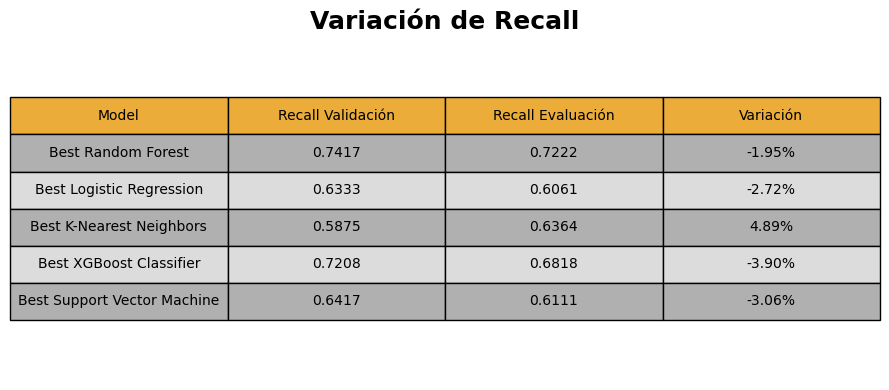

In [242]:
generar_tabla(df_recall_diff,
              title='Variación de Recall',
              save='recall_diff',
              figsize=(9,4))

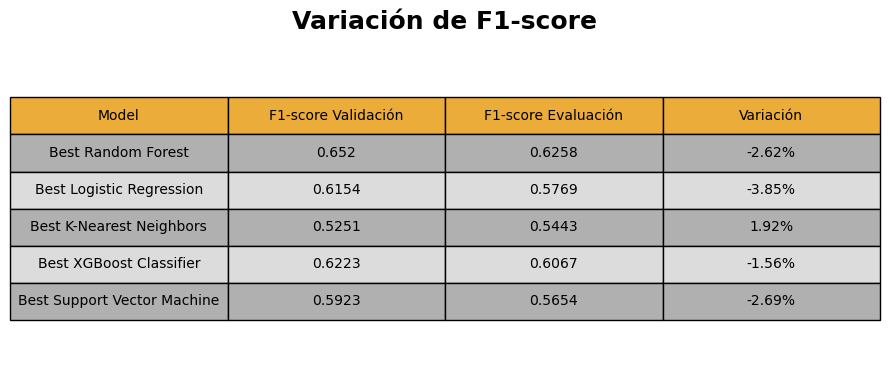

In [243]:
generar_tabla(df_f1_diff,
              title='Variación de F1-score',
              save='f1_diff',
              figsize=(9,4))

## <font color='#ebac3a'>**Conclusiones: Métricas Generales**</font>

Se destacan algunos puntos interesantes frente a la evaluación realizada:

### <font color='#f07c3e'>Recall</font>

Se seleccionó esta métrica como prioritaria, ya que el objetivo del negocio es **detectar clientes propensos a cancelar el servicio** (`Churn = 1`) y actuar preventivamente.

Al evaluar los modelos seleccionados, es posible observar que el Recall de todos decrece, pero el que menos se ve afectado es el del modelo de Logistic Regression:

|Model	                     |Recall Validation| Recall Testing |Variación|
|----------------------------|-----------------|----------------|---------|
|Best Random Forest	         |0.7292           |0.6010          |-12.82%  |
|Best Logistic Regression    |0.7167	       |0.6919          |-2.48%   |
|Best K-Nearest Neighbors    |0.7458           |0.7071	        |-3.87%   |
|Best XGBoost Classifier     |0.7000           |0.5909          |-10.91%  |
|Best Support Vector Machine |0.7750		   |0.7273	        |-4.77%   |

* **Best Random Forest:** Presenta una caida de más del 12.82% en Recall en los datos de prueba (test), lo que sugiere un fuerte sobreajuste a los datos de entrenamiento.
* **Best K-Nearest Neighbors:** Su caida respecto a los datos de entrenamiento es más leve, un **3.87%**.
* **Best XGBoost Classifier:** La métrica Recall disminuye un **9.21%** en los datos de prueba, lo que sugiere, al igual que en `Best Random Forest`, un sobreajuste a los datos de entrenamiento (un poco menor al mencionado anteriormente).
* **Best Support Vector Machine**: Sigue manteniendo el **Recall** más alto, pero su variación es de **-4.47%**, lo que sugiere menos robustez frente a datos nunca antes visto.

### <font color='#f07c3e'>F1-score</font>

Esta métrica permite evaluar el desempeño general del modelo al considerar tanto Recall (capacidad de identificar verdaderos positivos) como Precisión (capacidad de acertar cuando el modelo predice un cliente que se dará de baja) de manera conjunta. Ya que estas métricas suelen comportarse de manera inversa, es decir, priorizar una disminuye la otra.
Aquí, es posible observar una vez más, que en los datos de prueba (test), el modelo `Best Logistic Regression` es el que mejor se desempeña en términos generales. Si bien no fue el que alcanzó el mejor F1-score durante el entrenamiento, al evaluar los modelos con nuevos datos, este mantiene la mejor generalización de los mismos:

|Model                       |F1-score Validation| F1-score Testing|Variación|
|----------------------------|-------------------|-----------------|---------|
|Best Random Forest          |0.7172             | 0.6364          |-8.08%   |
|Best Logistic Regression    |0.6853             | 0.6765          |-0.88%   |
|Best K-Nearest Neighbors    |0.6898             | 0.6683          |-2.15%   |
|Best XGBoost Classifier     |0.7029             | 0.6207          |-8.22%   |
|Best Support Vector Machine |0.7059     	     | 0.6713          |-3.46%   |

Mientras que esta métrica disminuye **0.88%** en la Regresión Logística, podemos ver que el resto de modelos pierde entre **2%** y **8%**, demostrando un rendimientos generales subóptimos comparados con `Best Logistic Regression`.

## <font color='#ebac3a'>**Subajuste (Underfitting) y Subajuste (Overfitting)**</font>

### <font color='#f07c3e'>**Best Random Forest**</font>

In [244]:
rf_test_preds = random_forest.predict(X_test)
print(classification_report(y_test, rf_test_preds))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82       518
           1       0.55      0.72      0.63       198

    accuracy                           0.76       716
   macro avg       0.72      0.75      0.73       716
weighted avg       0.79      0.76      0.77       716



### <font color='#f07c3e'>**Best Logistic Regression**</font>

In [245]:
lr_test_preds = log_reg.predict(X_linear_test)
print(classification_report(y_linear_test, lr_test_preds))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       518
           1       0.55      0.61      0.58       198

    accuracy                           0.75       716
   macro avg       0.70      0.71      0.70       716
weighted avg       0.76      0.75      0.76       716



### <font color='#f07c3e'>**Best K-Nearest Neighbors**</font>

In [246]:
knn_test_preds = knn.predict(X_scaled_test)
print(classification_report(y_scaled_test, knn_test_preds))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       518
           1       0.48      0.64      0.54       198

    accuracy                           0.71       716
   macro avg       0.66      0.68      0.66       716
weighted avg       0.74      0.71      0.72       716



### <font color='#f07c3e'>**Best XGBoost Classifier**</font>

In [247]:
xgb_test_preds = xgb.predict(X_test)
print(classification_report(y_test, xgb_test_preds))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       518
           1       0.55      0.68      0.61       198

    accuracy                           0.76       716
   macro avg       0.71      0.73      0.71       716
weighted avg       0.78      0.76      0.76       716



### <font color='#f07c3e'>**Best Support Vector Machine**</font>

In [249]:
svm_test_preds = svm.predict(X_scaled_test)
print(classification_report(y_scaled_test, svm_test_preds))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       518
           1       0.53      0.61      0.57       198

    accuracy                           0.74       716
   macro avg       0.68      0.70      0.69       716
weighted avg       0.75      0.74      0.75       716



## <font color='#ebac3a'>**Conclusiones: Subajuste (Underfitting) y Sobreajuste (Overfitting)**</font>

En cuanto a este aspecto, ninguno de los modelos mostró un subajuste (underfitting), ya que todos alcanzan un desempeño aceptable en sus métricas generales (macro avg), superando un umbral del **64%**.

Sin embargo, del análisis de **métricas generales** anterior, se puede observar que los modelos de decision tipo **(if ->, else ->)** presentan un sobreajuste (overfitting) mayor a los datos de entrenamiento. A pesar de que los modelos basados en árboles son robustos frente a variables no escaladas, el desempeño de `Random Forest` y `XGBoost Classifier` muestran mayor variación frente a los datos de prueba. En contraste, `Logistic Regression` —el modelo con desempeño más estable— se basa en coeficientes, mientras que `K-Nearest Neighbors` utiliza la medición de distancias entre observaciones. `Support Vector Machine` muestra el **Recall** más alto, pero a su vez, su rendimiento general es el más bajo, obteniendo **macro avg = 0.64** junto con `XGBoost Classifier`

`Logistic Regression` presenta mayor estabilidad y mejor generalización del patrón presente en los datos, con una variación de **-2.48%** en la métrica prioritaria (**Recall**) y **-0.88%** en la métrica de monitoreo general (**F1-score**).


En resumen, **la Regresión Logística no solocuenta con la mejor capacidad de generalización**, lo que la convierte en una opción sólida y confiable para su implementación en un entorno productivo, sino que además al trabajar con coeficientes ofrece interpretabilidad del modelo, lo que permite evaluar la dirección y magnitud del impacto de cada variable para el desarrollo de medidas preventivas y campañas de retención.

## <font color='#ebac3a'>**Best Models Confusion Matrices**</font>

### <font color='#f07c3e'>**Best Random Forest**</font>

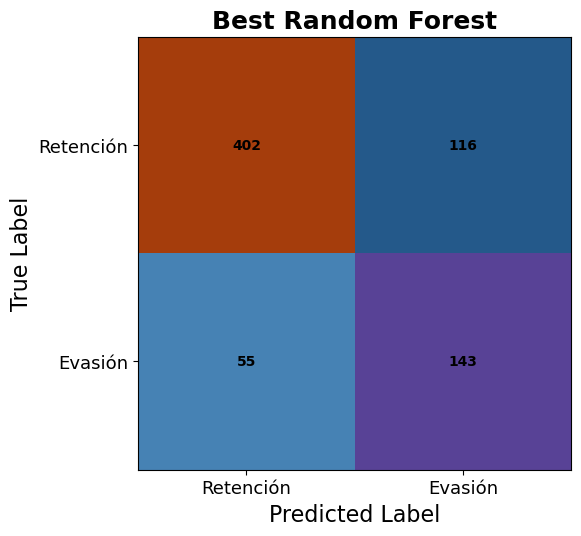

In [250]:
plot_conf_mat(random_forest, X_test, y_test, 'Best Random Forest', 'randomforest')

### <font color='#f07c3e'>**Best Logistic Regression**</font>

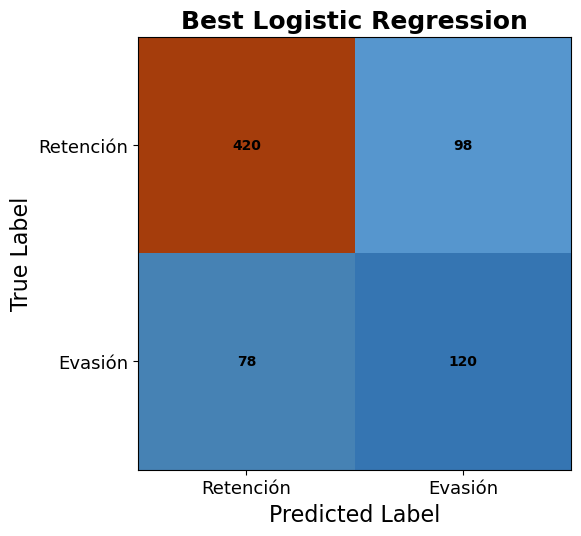

In [251]:
plot_conf_mat(log_reg, X_linear_test, y_linear_test, 'Best Logistic Regression', 'log_reg')

### <font color='#f07c3e'>**Best K-Nearest Neighbors**</font>

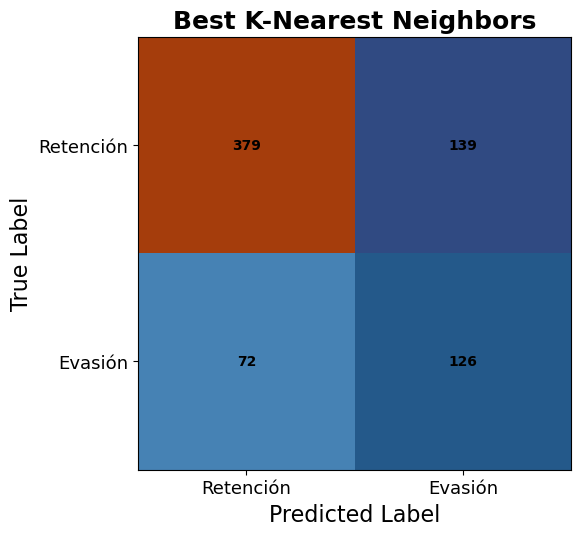

In [252]:
plot_conf_mat(knn, X_scaled_test, y_scaled_test, 'Best K-Nearest Neighbors', 'knn')

### <font color='#f07c3e'>**Best XGBoost Classifier**</font>

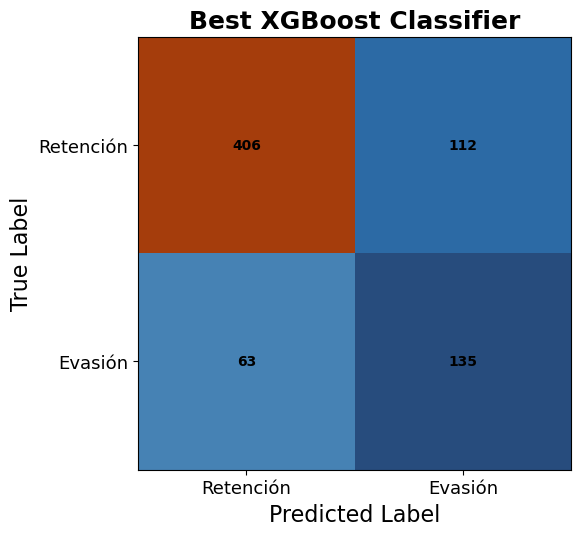

In [253]:
plot_conf_mat(xgb, X_test, y_test, 'Best XGBoost Classifier', 'xgb')

### <font color='#f07c3e'>**Best Support Vector Machine**</font>

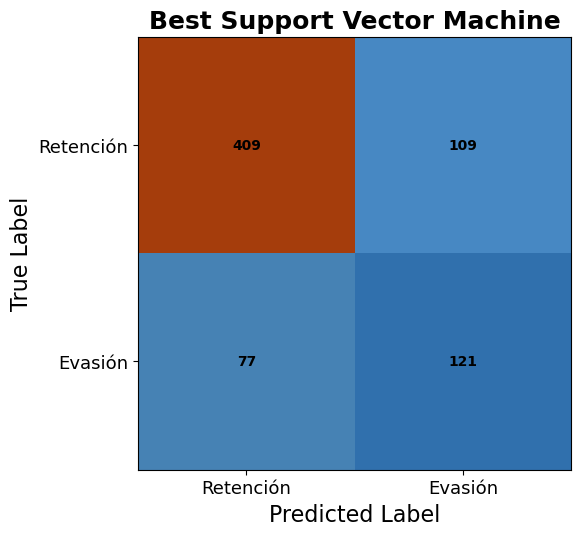

In [255]:
plot_conf_mat(svm, X_scaled_test, y_scaled_test, 'Best Support Vector Machine', 'svm')

## <font color='#ebac3a'>**Conclusiones: Matrices de Confusión**</font>

Los resultados visualizados en las matrices de confusión reafirman lo observado en las métricas generales. El modelo con **mayor capacidad para identificar correctamente a los clientes que abandonan** fue **Support Vector Machine (SVM)**, con un total de **145 verdaderos positivos**, seguido por **Logistic Regression** con **141 acciertos** y por último **K-Nearest Neighbors (KNN)**, con **140 aciertos**.

Aunque los tres modelos obtienen un **Recall** cercanos entre sí, la diferencia radica en la **Precisión**. Los modelo **SVM** y **KNN** tienden a clasificar como evasión a un mayor número de clientes que, en realidad, no tienen intención de abandonar. Esto implica una **mayor tasa de falsos positivos**, lo cual podría derivar en **costos operativos innecesarios** al implementar estrategias de retención sobre un grupo de bajo riesgo.

En contraste, los modelos basados en árboles (**Random Forest** y **XGBoost Classifier**) mostraron un mejor desempeño a la hora de identificar correctamente a los clientes que **no** abandonan (verdaderos negativos). Sin embargo, este comportamiento no responde al objetivo principal del modelo, que es **maximizar la detección de potenciales bajas** para poder **anticipar y reducir la evasión (churn)**.

En resumen:
- **Logistic Regression** ofrece el mejor balance entre Recall y Precisión, con una **mayor capacidad de generalización**.
- **K-Nearest Neighbors** y **Support Vector Machine** alcanza un Recall competitivo, pero a costa de una caída singificativa en la Precisión.
- **Random Forest** y **XGBoost** se destacan más por su capacidad de detectar retención que por anticipar evasión, lo cual los hace menos alineados con el propósito del negocio.

## <font color='#ebac3a'>**Importancias y Coeficientes**</font>

### <font color='#f07c3e'>**Best Random Forest - Importancias**</font>

In [256]:
rf_importancias = random_forest.feature_importances_
features = X_test.columns

df_importancias_rf = pd.DataFrame({'Feature': features,
                                   'Importancia': rf_importancias}).sort_values('Importancia', ascending=False)
df_importancias_rf

,Feature,Importancia
23,Tenure,0.196516
25,ChargesTotal,0.188662
24,ChargesMonthly,0.131077
15,Contract_Month-to-month,0.064132
12,TechSupport_Yes,0.035794
21,PaymentMethod_Electronic check,0.028529
17,Contract_Two year,0.028473
9,OnlineSecurity_Yes,0.028030
18,PaperlessBilling_Yes,0.026143
7,InternetService_Fiber optic,0.023733


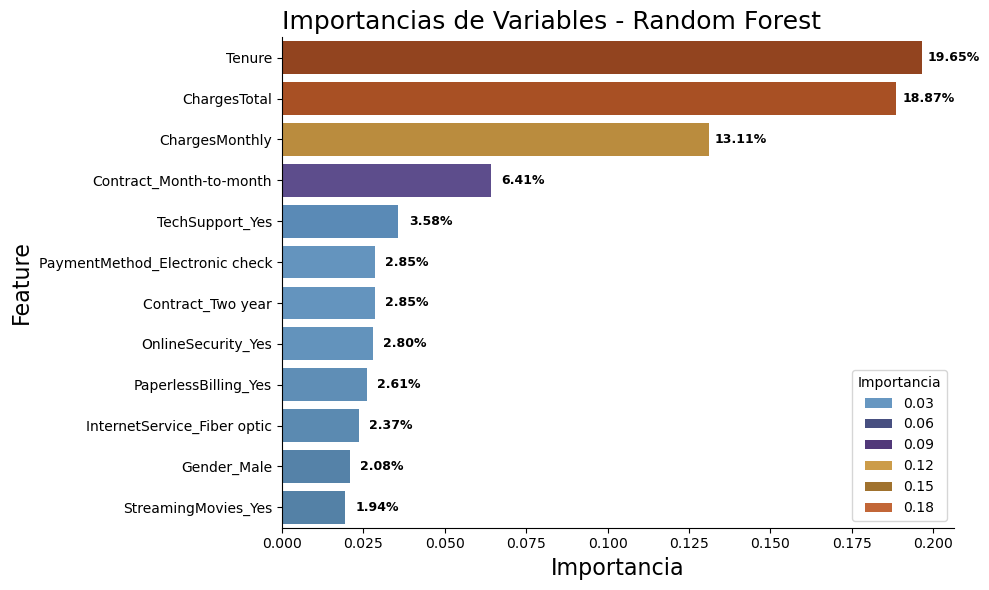

In [257]:
plot_analisis_variables(df=df_importancias_rf, 
                        analisis='Importancia',
                        nombre_modelo='Random Forest',
                        n_vars=12,
                        save='RandomForest')

In [258]:
df_importancias_rf['Feature'].head(12)

23                            Tenure
25                      ChargesTotal
24                    ChargesMonthly
15           Contract_Month-to-month
12                   TechSupport_Yes
21    PaymentMethod_Electronic check
17                 Contract_Two year
9                 OnlineSecurity_Yes
18              PaperlessBilling_Yes
7        InternetService_Fiber optic
0                        Gender_Male
14               StreamingMovies_Yes
Name: Feature, dtype: object

In [259]:
importancia_12 = np.round(df_importancias_rf['Importancia'].head(12).sum(), 4)
print(f'Importancia de las 12 variables más relevantes: {importancia_12}')

Importancia de las 12 variables más relevantes: 0.7913


### <font color='#8b5fc4'>**Observaciones: Best Random Forest - Importancias**</font>

A partir de las importancias determinadas por el mejor modelo de Random Forest, se seleccionaron las 12 variables con una importancia superior a **0.02**:

* Tenure
* ChargesTotal
* ChargesMonthly
* Contract_Month-to-month
* PaymentMethod_Electronic check
* Contract_Two year
* TechSupport_Yes
* InternetService_Fiber optic
* OnlineSecurity_Yes
* Dependents_Yes
* PaperlessBilling_Yes
* Gender_Male

La suma de sus importancias alcanza un **79.23%**, lo que indica que estas variables explican la mayor parte de las decisiones del modelo. En otras palabras, contribuyen en casi un **80%** a reducir la impureza de los nodos de los árboles de decisión.

En particular, las tres variables numéricas —`Tenure` (**20.12%**), `ChargesTotal` (**18.42%**) y `ChargesMonthly` (**13.48%**)— representan juntas el **52.02%** de la importancia total. Esto sugiere que el modelo empieza a dividir los datos principalmente en función de estas variables, logrando más de la mitad de la reducción de impureza con ellas solas.

Sin embargo, este tipo de modelo no permite evaluar **cuánto** impacta cada variable en la probabilidad de Evasión (Churn). La importancia asignada a cada variable refleja **qué tan útil** resulta para reducir la impureza entre clases durante la construcción de los árboles, pero **no permite interpretar ni la magnitud ni la dirección** de su efecto sobre el resultado, ya que **no se basa en coeficientes** como lo hacen los modelos lineales.

### <font color='#f07c3e'>**Best Logistic Regression - Coeficientes**</font>

In [260]:
coeficientes = log_reg.best_estimator_.coef_
features = X_linear_test.columns

df_coeficientes_logreg = pd.DataFrame({'Feature': features,
                                       'Coeficiente': coeficientes[0]}).sort_values('Coeficiente', ascending=False)

df_coeficientes_logreg

,Feature,Coeficiente
22,ChargesTotal_scaled,0.565458
6,InternetService_Fiber optic,0.511846
1,SeniorCitizen_Yes,0.261071
18,PaymentMethod_Electronic check,0.253774
16,PaperlessBilling_Yes,0.241873
13,StreamingMovies_Yes,0.229005
5,MultipleLines_Yes,0.220675
12,StreamingTV_Yes,0.196547
19,PaymentMethod_Mailed check,0.082127
17,PaymentMethod_Credit card (automatic),0.042703


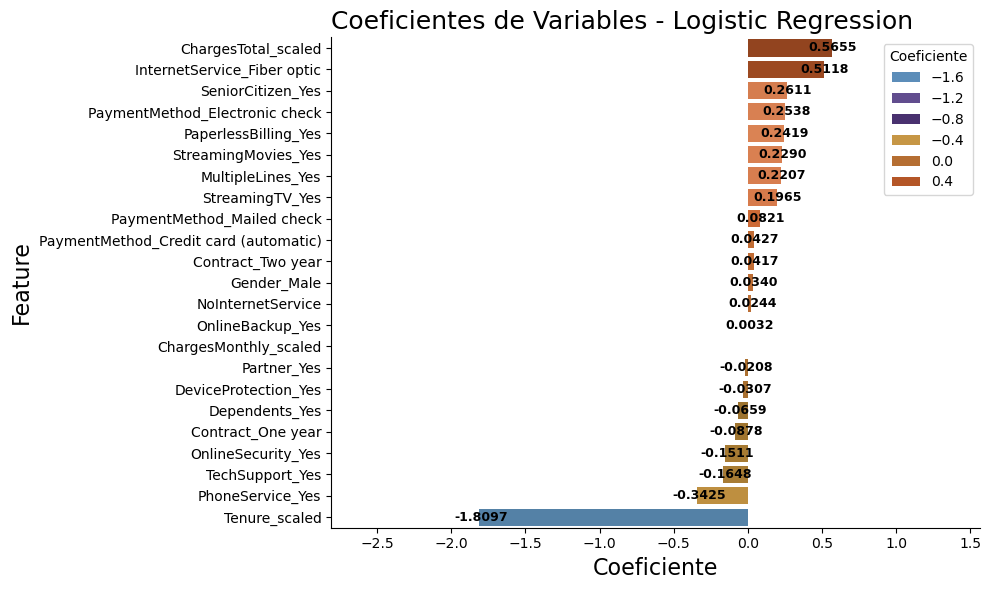

In [261]:
plot_analisis_variables(df=df_coeficientes_logreg, 
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression',
                        save='LogReg')

### <font color='#8b5fc4'>**Observaciones: Best Logistic Regression - Coeficientes**</font>

Los modelos lineales como **Regresión Logística** ofrecen una ventaja significativa frente a los modelos de árboles: permiten interpretar tanto la **dirección** como la **magnitud** del impacto de cada variable sobre la **probabilidad de Evasión (Churn)**.

Este análisis se basa en un modelo entrenado utilizando `OneHotEncoder(drop='first')` y penalización **L1 (Lasso)**, lo que implica:
* Los coeficientes están **en relación a la categoría omitida** de cada variable categórica.
* Las variables irrelevantes son automáticamente descartadas (`coef = 0`).


#### **Dirección del impacto**
- **Coeficientes positivos**: Aumentan la probabilidad de churn.
- **Coeficientes negativos**: Disminuyen la probabilidad de churn.


#### **Magnitud del impacto**
Los coeficientes representan el cambio en los **log-odds** de churn por unidad de cambio en la variable (escalada), manteniendo constantes las demás.

$$
\Large \text{log-odds} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n
$$

Para convertir los logits a probabilidades usamos la función sigmoide, y para interpretar el cambio marginal usamos el **odds ratio**:

$$
\Large odds_{ratio} = e^{\beta_i}
$$


#### **Variables protectoras contra churn**

* `Tenure_scaled = -2.5268`

$$
\Large  odds_{ratio} = e^{-2.5268} \approx 0.080   \text{Reduce las chances en un } 92\%
$$

* `Contract_Two year = -0.9706`  

$$
\Large  odds_{ratio} = e^{-0.9706} \approx 0.378 
$$
$$
\Large 1 - 0.378 = \text{Reduce las chances en un } \approx 62.2\%
$$

* `TechSupport_Yes = -0.4351`, `OnlineSecurity_Yes = -0.4327`, `Dependents_Yes = -0.2703`  

También contribuyen a **reducir la probabilidad de churn**.


#### **Variables que aumentan el riesgo de churn**

* `ChargesTotal_scaled = 1.9424`  

$$
\Large  odds_{ratio} = e^{1.9424} \approx 6.97  \Rightarrow \text{Aumenta el riesgo casi 7 veces}
$$

* `PaperlessBilling_Yes = 0.3533`, `PaymentMethod_Electronic check = 0.3289`, `InternetService_Fiber optic = 0.2283`
  
  Estas variables también se asocian a **mayor propensión a churn**.


#### **Variables omitidas vs coeficientes**

Dado que se usó `drop='first'`, todos los coeficientes de variables categóricas deben interpretarse **relativamente a la categoría omitida**. Por ejemplo:

- `Contract_Two year` y `Contract_One year` están en relación a `Contract_Month-to-month` (omitida). Lo que implica que, por ejemplo, estas dos variables al tener coeficiente negativo, los log-odds (logits) disminuyen en $1 - e^{\beta_i}$ en relación a si el cliente tiene `Contract_Month-to-month = 1`
- `PaymentMethod_Electronic check`, `Mailed check`, y `Credit card` se comparan con `Bank transfer (automatic)` de la misma manera.


#### **Tensión aparente entre** `ChargesTotal` y `Tenure`

Aunque estas dos variables están altamente correlacionadas (0.94), lo que singifica que se comportan de manera directamente proporcional, sus coeficientes tienen signos opuestos:

* `Tenure_scaled` tiene un coeficiente negativo (protege contra churn).
* `ChargesTotal_scaled` tiene un coeficiente positivo (aumenta riesgo de churn).

Esta aparente contradicción puede explicarse porque:

- **`Tenure` refleja antigüedad y lealtad**: clientes con más tiempo suelen ser más fieles y menos propensos a abandonar.
- **`ChargesTotal` representa el monto acumulado cobrado** y puede captar otros factores, como clientes con altos cargos que podrían estar insatisfechos o que enfrentan cambios recientes en tarifas o servicios.

En otras palabras, el modelo podría estar detectando que, entre clientes con alta antigüedad, aquellos con cargos acumulados muy elevados presentan un riesgo mayor de churn, quizás debido a insatisfacción por costos crecientes o servicios cambiantes. Probablemente los clientes que fueron seleccionados como outliers en la etapa anterior, pero que se decidieron conservar para captar justamente este tipo de fenómenos. Lo que sugiere que deberían analizarse de forma separada, buscando qué factores son los que llevan a clientes con un Gasto Total (ChargesTotal) elevado a abandonar la empresa.

#### **Variables descartadas**

El modelo descartó automáticamente algunas variables, asignándoles coeficiente 0. Esto significa que **no aportan valor predictivo adicional** al resto de variables del modelo:

- `NoInternetService = 0.000`
- `Gender_Male = -0.022` (muy cercano a 0)


#### **Conclusión**

La regresión logística con Lasso permite construir un modelo interpretable, robusto y selectivo.  
Gracias al uso de codificación `drop='first'` y regularización, se logra:

- Evitar la multicolinealidad.
- Detectar **factores clave de riesgo y protección**.
- Explicar con claridad la lógica del modelo al negocio.

In [262]:
np.exp(-2.5268)

0.07991433744038948

In [263]:
1 - np.exp(-2.5268)

0.9200856625596106

In [264]:
np.exp(-0.9706)

0.37885565650183867

In [265]:
1 - np.exp(-0.9706)

0.6211443434981614

In [266]:
np.exp(1.9424)

6.975472030212183

Se agregará al `DataFrame` de los coeficientes el $odds_{ratio}$ y una columna con la interpretación de cada variable para entender el impacto de cada una de ellas.

In [267]:
odds_ratios = []
interpretaciones = []

for coeficiente in df_coeficientes_logreg['Coeficiente']:
    odds_ratio = np.round(np.exp(coeficiente), 4)
    odds_ratios.append(odds_ratio)
    if coeficiente > 0:
        impacto = np.round((odds_ratio - 1)*100, 2)
        interpretacion = f'Aumenta las chances en: {impacto}%'
    elif coeficiente < 0:
        impacto = np.round((1 - odds_ratio)*100, 2)
        interpretacion = f'Disminuye las chances en: {impacto}%'
    else:
        interpretacion = 'Sin impacto'
    interpretaciones.append(interpretacion)
    
df_coeficientes_logreg['Odds Ratio'] = odds_ratios
df_coeficientes_logreg['Interpretación'] = interpretaciones

df_coeficientes_logreg

,Feature,Coeficiente,Odds Ratio,Interpretación
22,ChargesTotal_scaled,0.565458,1.7603,Aumenta las chances en: 76.03%
6,InternetService_Fiber optic,0.511846,1.6684,Aumenta las chances en: 66.84%
1,SeniorCitizen_Yes,0.261071,1.2983,Aumenta las chances en: 29.83%
18,PaymentMethod_Electronic check,0.253774,1.2889,Aumenta las chances en: 28.89%
16,PaperlessBilling_Yes,0.241873,1.2736,Aumenta las chances en: 27.36%
13,StreamingMovies_Yes,0.229005,1.2573,Aumenta las chances en: 25.73%
5,MultipleLines_Yes,0.220675,1.2469,Aumenta las chances en: 24.69%
12,StreamingTV_Yes,0.196547,1.2172,Aumenta las chances en: 21.72%
19,PaymentMethod_Mailed check,0.082127,1.0856,Aumenta las chances en: 8.56%
17,PaymentMethod_Credit card (automatic),0.042703,1.0436,Aumenta las chances en: 4.36%


**Para una visualización más clara de las variables que más impactan en la probabilidad de Evasión (Churn), se seleccionaran las 12 variables con coeficientes más significativos.**

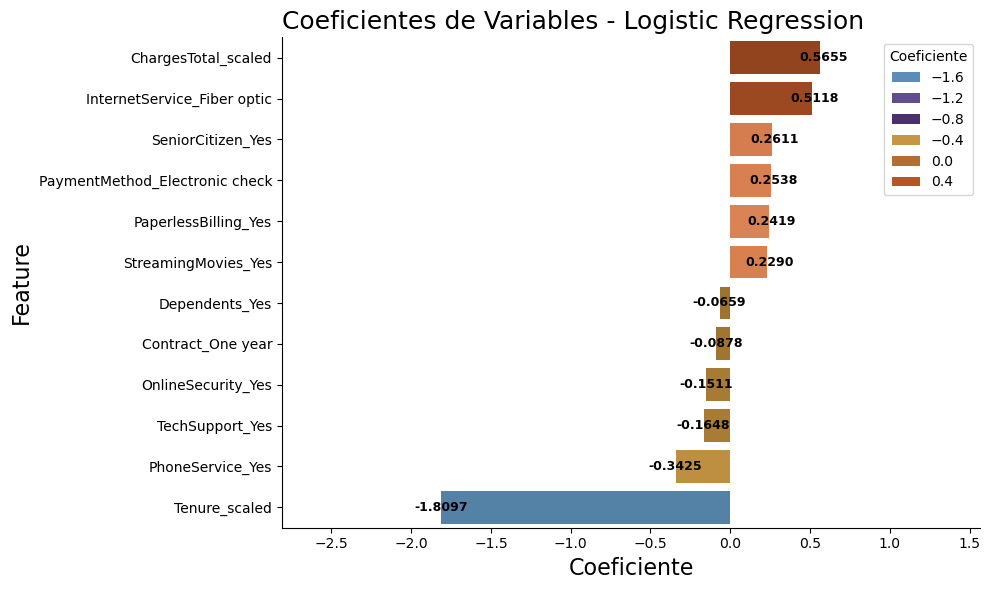

In [268]:
plot_analisis_variables(df=df_coeficientes_logreg, 
                        analisis='Coeficiente',
                        nombre_modelo='Logistic Regression',
                        n_vars=12,
                        save='LogReg_best_coef')

In [269]:
df1 = df_coeficientes_logreg.head(6)
df2 = df_coeficientes_logreg.tail(6)
df_best_coef_logreg = pd.concat([df1, df2]).reset_index(drop=True)
df_best_coef_logreg

,Feature,Coeficiente,Odds Ratio,Interpretación
0,ChargesTotal_scaled,0.565458,1.7603,Aumenta las chances en: 76.03%
1,InternetService_Fiber optic,0.511846,1.6684,Aumenta las chances en: 66.84%
2,SeniorCitizen_Yes,0.261071,1.2983,Aumenta las chances en: 29.83%
3,PaymentMethod_Electronic check,0.253774,1.2889,Aumenta las chances en: 28.89%
4,PaperlessBilling_Yes,0.241873,1.2736,Aumenta las chances en: 27.36%
5,StreamingMovies_Yes,0.229005,1.2573,Aumenta las chances en: 25.73%
6,Dependents_Yes,-0.065943,0.9362,Disminuye las chances en: 6.38%
7,Contract_One year,-0.087822,0.9159,Disminuye las chances en: 8.41%
8,OnlineSecurity_Yes,-0.151131,0.8597,Disminuye las chances en: 14.03%
9,TechSupport_Yes,-0.164814,0.8481,Disminuye las chances en: 15.19%


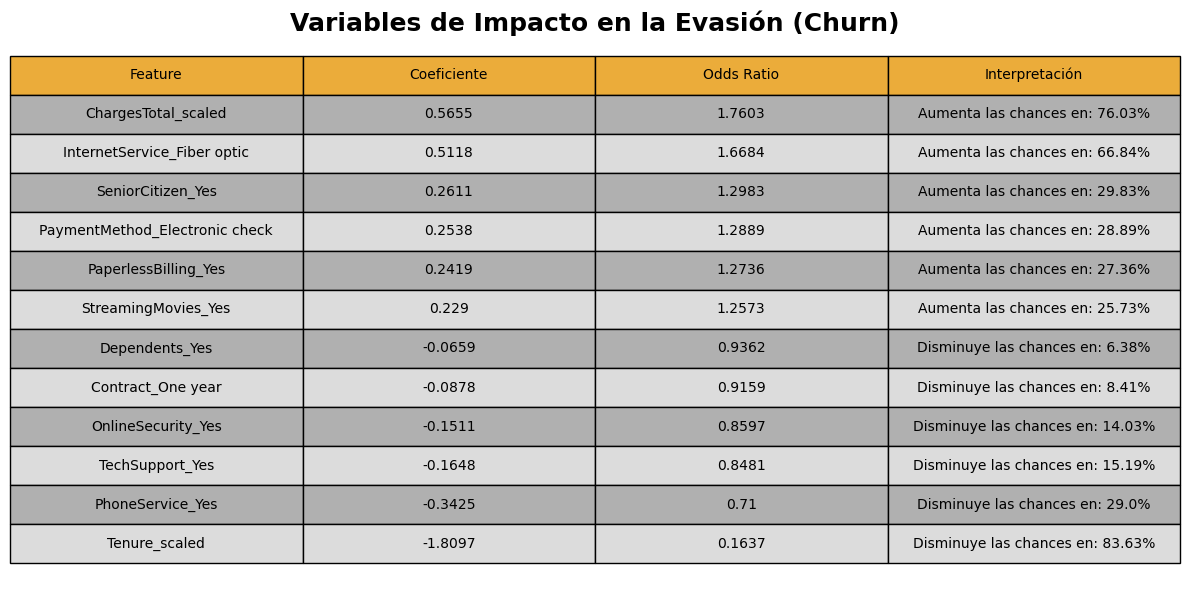

In [270]:
generar_tabla(df_best_coef_logreg,
              title='Variables de Impacto en la Evasión (Churn)',
              save='tabla_coef_logreg',
              figsize=(12,6))

#### Unidad Robusta ChargesTotal

In [271]:
cols_robust_scaler = robust_scaler.feature_names_in_.tolist()

In [272]:
index = cols_robust_scaler.index('ChargesTotal')

mediana = robust_scaler.center_[index]
iqr = robust_scaler.scale_[index]

print(f"Una unidad escalada en ChargesTotal equivale a {iqr:.2f} unidades monetarias reales.")
print(f"La mediana de ChargesTotal es de {mediana:.2f}.")

Una unidad escalada en ChargesTotal equivale a 3538.74 unidades monetarias reales.
La mediana de ChargesTotal es de 1424.45.


#### Unidad Robusta Tenure

In [273]:
index = cols_robust_scaler.index('Tenure')

mediana = robust_scaler.center_[index]
iqr = robust_scaler.scale_[index]

print(f"Una unidad escalada en Tenure equivale a {int(iqr)} meses.")
print(f"La mediana de Tenure es de {int(mediana)}.")

Una unidad escalada en Tenure equivale a 47 meses.
La mediana de Tenure es de 30.


### <font color='#f07c3e'>**Best K-Nearest Neighbors - Importancias**</font>

El modelo **K-Nearest Neighbors (KNN)** no trabaja con coeficientes ni con medidas directas de importancia, ya que su funcionamiento se basa en calcular la **distancia entre observaciones** y clasificar cada punto según la mayoría de los **K vecinos más cercanos**.

Sin embargo, mediante la técnica de **permutación de variables**, es posible estimar la importancia relativa de cada atributo. Esta técnica evalúa cuánto se deteriora el rendimiento del modelo al desordenar aleatoriamente los valores de una variable. Las variables cuya permutación más perjudica el desempeño general del modelo son consideradas las más relevantes para la separación de clases.

In [274]:
importancias = permutation_importance(
    knn,
    X_scaled_test,
    y_scaled_test,
    scoring='f1',
    n_repeats=10,
    random_state=42)

In [275]:
df_importancias_knn = pd.DataFrame({'Feature': X_scaled_test.columns,
                                    'Importancia': importancias['importances_mean']}).sort_values('Importancia', ascending=False)
df_importancias_knn

,Feature,Importancia
23,Tenure_scaled,0.059769
25,ChargesTotal_scaled,0.051487
24,ChargesMonthly_scaled,0.029854
5,MultipleLines_Yes,0.022713
18,PaperlessBilling_Yes,0.020796
14,StreamingMovies_Yes,0.018159
13,StreamingTV_Yes,0.017484
12,TechSupport_Yes,0.013854
9,OnlineSecurity_Yes,0.008003
21,PaymentMethod_Electronic check,0.005207


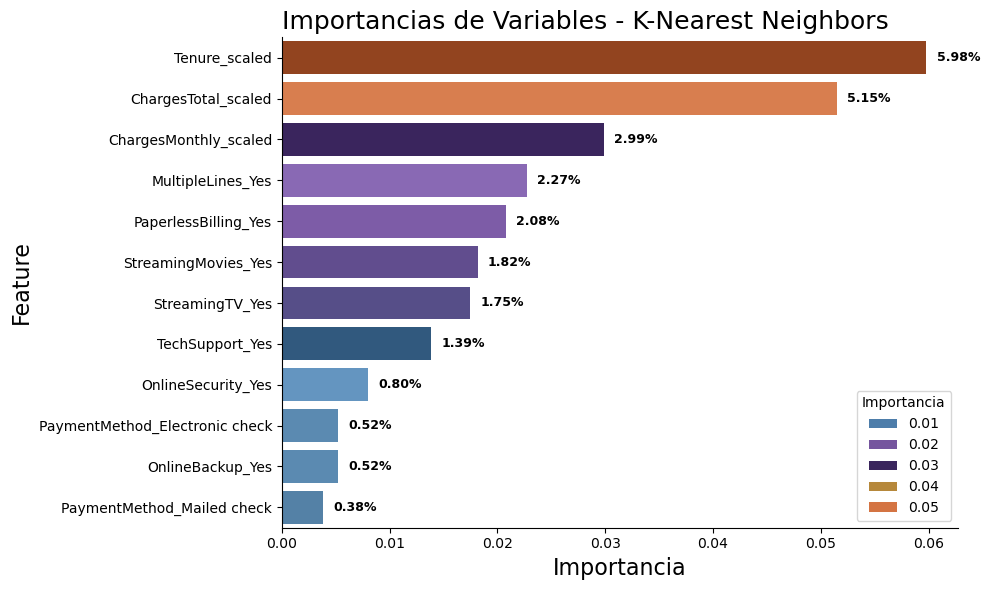

In [276]:
plot_analisis_variables(df=df_importancias_knn, 
                        analisis='Importancia',
                        nombre_modelo='K-Nearest Neighbors',
                        save='KNN',
                        n_vars=12)

In [277]:
df_importancias_knn['Feature'].head(12)

23                     Tenure_scaled
25               ChargesTotal_scaled
24             ChargesMonthly_scaled
5                  MultipleLines_Yes
18              PaperlessBilling_Yes
14               StreamingMovies_Yes
13                   StreamingTV_Yes
12                   TechSupport_Yes
9                 OnlineSecurity_Yes
21    PaymentMethod_Electronic check
10                  OnlineBackup_Yes
22        PaymentMethod_Mailed check
Name: Feature, dtype: object

### <font color='#8b5fc4'>**Observaciones: Best K-Nearest Neighbors - Importancias**</font>

La manera de interpretar la importancia de las variables determinada mediante **permutación** (`permutation_importance`) es la siguiente:

Cuando se **desordena aleatoriamente** una variable $X_i$, el desempeño del modelo —medido en este caso con el **F1-score**— **disminuye en promedio un valor $y_i$**.

Esto indica que dicha variable es relevante para el modelo: **cuanto mayor la caída del rendimiento al desordenarla, mayor su importancia**.

Por lo tanto, al tomar las **12 variables más importantes** determinadas por el modelo KNN, aquellas que tienen **mayor impacto** en la decisión final (a través de la proximidad con sus vecinos más cercanos) son, en orden descendente:

- `ChargesTotal_scaled`
- `Tenure_scaled`
- `TechSupport_Yes`
- `MultipleLines_Yes`
- `ChargesMonthly_scaled`
- `PaymentMethod_Mailed check`
- `Partner_Yes`
- `DeviceProtection_Yes`
- `SeniorCitizen_Yes`
- `StreamingMovies_Yes`
- `PaymentMethod_Bank transfer (automatic)`
- `InternetService_DSL`

Este tipo de análisis, al igual que con **Random Forest**, **no permite evaluar el signo ni la magnitud del impacto** de cada variable sobre la **probabilidad de Evasión (Churn)**.  
En cambio, solo indica **cuán útil es cada variable** para mejorar la clasificación correcta dentro del modelo.

### <font color='#f07c3e'>**Best XGBoost Classifier - Importancias**</font>

In [278]:
xgb_best = xgb.best_estimator_
importancias_xgb = xgb_best.feature_importances_ #xgb_best.feature_importances_
features = X_test.columns

df_importancias_xgb = pd.DataFrame({'Feature': features,
                                    'Importancia': importancias_xgb}).sort_values('Importancia', ascending=False)

df_importancias_xgb

,Feature,Importancia
15,Contract_Month-to-month,0.464798
7,InternetService_Fiber optic,0.128080
23,Tenure,0.074275
4,PhoneService_Yes,0.045834
16,Contract_One year,0.027582
12,TechSupport_Yes,0.023645
18,PaperlessBilling_Yes,0.019848
24,ChargesMonthly,0.019723
3,Dependents_Yes,0.017596
9,OnlineSecurity_Yes,0.015065


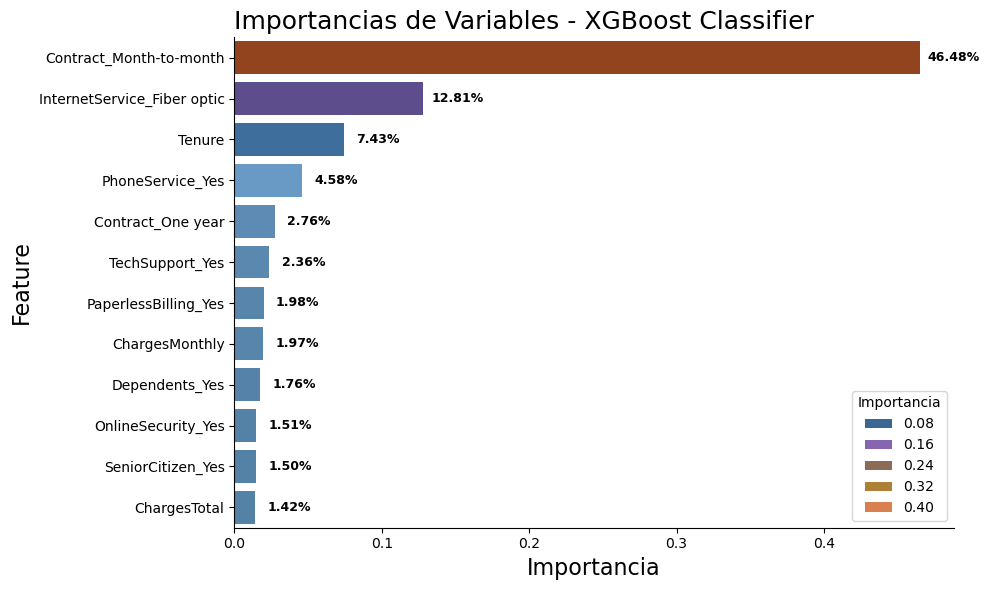

In [279]:
plot_analisis_variables(df=df_importancias_xgb, 
                        analisis='Importancia',
                        nombre_modelo='XGBoost Classifier',
                        save='XGB',
                        n_vars=12)

In [280]:
sum_importancias_xgb = np.round(df_importancias_xgb['Importancia'].head(12).sum(), 4)

In [281]:
sum_importancias_xgb

0.8656

### <font color='#8b5fc4'>**Observaciones: Best XGBoost Classifier - Importancias**</font>

Las **12 variables** más importantes según el modelo `Best XGB Classifier` representan el **80.1%** de las decisiones tomadas por los árboles de decisión que lo componen. Esto indica que, en promedio, los árboles basaron la mayor parte de sus **criterios de ramificación** en las siguientes variables:

* `Contract_Month-to-month`
* `InternetService_Fiber optic`
* `Tenure`
* `PhoneService_Yes`
* `PaymentMethod_Electronic check`
* `Contract_One year`
* `Dependents_Yes`
* `NoInternetService`
* `Contract_Two year`
* `OnlineSecurity_Yes`
* `SeniorCitizen_Yes`
* `ChargesMonthly`


Sin embargo, los modelos de arquitectura de árbol no permiten cuantificar el impacto de cada una de ellas, sino solo entender que tanto ayudan a reducir la impureza entre clases.

### <font color='#f07c3e'>**Best Support Vector Machine - Coeficientes**</font>

In [282]:
svm_coeficientes = svm.best_estimator_.coef_[0]
features = X_linear_train.columns

df_coeficientes_svm = pd.DataFrame({'Feature': features,
                                    'Coeficiente': svm_coeficientes}).sort_values('Coeficiente', ascending=False)

AttributeError: coef_ is only available when using a linear kernel

In [ ]:
df_coeficientes_svm

### <font color='#8b5fc4'>**Observaciones: Best Support Vector Machine - Coeficientes**</font>

A diferencia de la **Regresión Logística**, los coeficientes de **Suport Vector Machine** no tienen interpretabilidad probabilística.
En este caso:

El signo del coeficiente indica la dirección del impacto sobre la clase positiva (Churn = 1), es decir, coeficientes negativos reducen la probabilidad de Churn y coeficientes positivos aumentan la probabilidad de Churn. Pero no es cuantificable como en `Logistic Regression` que es posible entender el impacto que cada variable tiene, sino que aquí la magnitud del coeficiente refleja la importancia relativa.

El modelo determina que:

#### 6 Variables que ofrecen mayor protección contra la Evasión (Churn):

|Variable         | Coeficiente|
|-----------------|------------|
|Tenure_scaled	  |-2.624387   |
|Contract_Two year|-1.097956   |
|Contract_One year|-0.782270   |
|PhoneService_Yes |-0.541890   |
|OnlineSecurity_Yes|-0.511930  |
|TechSupport_Yes  |-0.500149   |

#### 6 Variables de mayor riesgo de Evasión (Churn):

|Variable                       | Coeficiente|
|-------------------------------|------------|
|ChargesTotal_scaled            |2.034655    |
|InternetService_Fiber optic    |0.430108    |
|PaperlessBilling_Yes           |0.288181    |
|PaymentMethod_Electronic check |0.235187    |
|StreamingMovies_Yes	        |0.120351    |
|StreamingTV_Yes	            |0.053764    |



In [ ]:
plot_analisis_variables(df=df_coeficientes_svm, 
                        analisis='Coeficiente',
                        nombre_modelo='Support Vector Machine',
                        save='SVM',
                        n_vars=12)

# <font color='#5a9bd4'>**6. Champion Model**</font>

In [283]:
pd.DataFrame(metricas_eval)

,Model,Accuracy,Precision,Recall,F1-score
0,Best Random Forest,0.7612,0.5521,0.7222,0.6258
1,Best Logistic Regression,0.7542,0.5505,0.6061,0.5769
2,Best K-Nearest Neighbors,0.7053,0.4755,0.6364,0.5443
3,Best XGBoost Classifier,0.7556,0.5466,0.6818,0.6067
4,Best Support Vector Machine,0.7402,0.5261,0.6111,0.5654


In [284]:
pd.DataFrame(metricas_val)

,Model,Accuracy,Precision,Recall,F1-score
0,Best Random Forest,0.7814,0.5817,0.7417,0.6520
1,Best Logistic Regression,0.7814,0.5984,0.6333,0.6154
2,Best K-Nearest Neighbors,0.7066,0.4747,0.5875,0.5251
3,Best XGBoost Classifier,0.7583,0.5475,0.7208,0.6223
4,Best Support Vector Machine,0.7560,0.5500,0.6417,0.5923


Después de los experimentos realizados y las conclusiones inferidas, se seleccionará a `Best Logistic Regression` como **Champion Model** para su uso en entorno productivo.

El objetivo principal del negocio es **predecir de forma anticipada qué clientes tienen mayor probabilidad de cancelar el servicio**, permitiendo accionar campañas de retención a tiempo.  
Por ello, la métrica prioritaria es el **Recall**, que mide la proporción de verdaderos positivos detectados correctamente.

Si bien `Best Support Vector Machine` cuenta con un **Recall 3% mayor** en relación a `Best Logistic Regression`, la elección de este último está basada en el hecho de que el conjunto de datos total contaba con 7152 observaciones, lo que implicaría una diferencia de apenas 30 clientes mal identificados por cada 1000, un margen que no justifica sacrificar estabilidad y generalización. Sin embargo, la estabilidad de `Best Logistic Regression` lo convierte, a mi parecer, en el modelo más confiable para entorno productivo. Si el volumen de
clientes aumenta considerablemente, se deberá reevaluar cuál es el mejor modelo para el problema en cuestión.

### <font color='#f07c3e'>Comparación Best Models</font>

| Modelo                    | Recall (Validación) | Recall (Test) | Variación (%) | F1-score (Test)  |
|---------------------------|---------------------|---------------|----------------|-----------------|
| **Random Forest**         | **0.7417**          | **0.7222**    | **-1.95%**     | **0.6258**      |
| Logistic Regression       | 0.6333              | 0.6061        | -2.72%         | 0.5769          |
| K-Nearest Neighbors       | 0.5875              | 0.6364        | +4.89%         | 0.5443          |
| XGBoost Classifier        | 0.7208              | 0.6818        | -3.90%         | 0.6067          |
| Support Vector Machine    | 0.6417              | 0.6111        | -3.06%         | 0.5654          |


### <font color='#f07c3e'>Razones para Seleccionar Random Forest</font>

- Menor caída de rendimiento entre validación y datos no vistos (test).
- Mejor F1-score general en test, lo que indica un buen balance entre Recall y Precisión.


### <font color='#f07c3e'>Recomendación Final</font>

Se recomienda **Random Forest** como modelo de producción, dado que:

- Presenta el **mejor equilibrio entre rendimiento y generalización**.
- Es **más fácil de mantener**.
- **Escala mejor en entornos de producción con datos limitados**.

Este modelo podrá ser reevaluado cuando la empresa cuente con **mayor volumen de datos** o requiera modelos más sofisticados. 

In [285]:
with open(CHAMPION_PATH / 'robust_scaler.pkl', 'wb') as f:
    pickle.dump(robust_scaler, f)

assert hasattr(one_hot_linear, 'transformers_')  # Esto solo existe si fue fiteado

with open(CHAMPION_PATH / 'linear_one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot_linear, f)

with open(CHAMPION_PATH / 'target_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
    
with open(CHAMPION_PATH / 'champion_model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

with open(CHAMPION_PATH / 'columns_order.pkl', 'wb') as f:
    pickle.dump(X_linear.columns.to_list(), f)

# <font color='#5a9bd4'>**7. Pipeline de prueba en entorno productivo**</font>

Se generará una pipeline de entorno productivo recibiendo un archivo json con datos crudos (generados artificialmente con `SMOTENC` a partir de una muestra de los datos originales).
Esto permitirá evaluar el proceso de ETL, predicción, y comunicación de resultados en un archivo simple de visualizar o analizar.

## <font color='#ebac3a'>**Generación de datos artificiales**</font>

In [286]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

df_smote = pd.read_json(URL)
df_smote.head()

try:
    URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    df_smote = pd.concat([df_smote, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    df_smote = df_smote.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [287]:
df_smote

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,8562-GHPPI,Female,No,No,No,1,Yes,No,No,No,...,No,No,No,Month-to-month,No,Credit card (automatic),0.66,19.80,19.80,No
1,5196-WPYOW,Male,No,Yes,Yes,67,Yes,No,DSL,Yes,...,Yes,No,No,One year,No,Mailed check,2.00,60.05,3994.05,No
2,8785-CJSHH,Female,No,Yes,No,60,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.33,99.80,5985.75,No
3,3594-KADLU,Male,No,Yes,No,3,No,No,DSL,Yes,...,Yes,No,No,Month-to-month,No,Mailed check,1.17,35.10,101.10,No
4,4671-VJLCL,Female,No,No,No,63,Yes,Yes,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Credit card (automatic),2.66,79.85,4861.45,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7147,5310-NOOVA,Male,No,No,No,46,Yes,No,No,No,...,No,No,No,Two year,No,Electronic check,0.66,19.95,907.05,No
7148,7302-ZHMHP,Female,No,No,No,1,Yes,No,No,No,...,No,No,No,Month-to-month,No,Mailed check,0.64,19.15,19.15,No
7149,7356-AYNJP,Female,No,No,No,4,Yes,Yes,No,No,...,No,No,No,One year,No,Electronic check,0.80,23.90,97.50,No
7150,7601-WFVZV,Male,No,No,No,1,Yes,No,No,No,...,No,No,No,Month-to-month,No,Mailed check,0.65,19.55,19.55,No


In [288]:
# Seleccionar muestra del 40% de observaciones para generar datos artificiales
sample = int(df_smote.shape[0] * 0.4)

In [289]:
sample_smote = df_smote.sample(sample)

In [290]:
sample_smote.shape

(2860, 22)

In [291]:
sample_smote.columns

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'ChargesDaily', 'ChargesMonthly', 'ChargesTotal',
       'Churn'],
      dtype='object')

In [292]:
cat_cols = sample_smote.select_dtypes(include='object').columns.tolist()
num_cols = sample_smote.select_dtypes(include=['int','float'], exclude='object').columns.tolist()
cat_cols.remove('CustomerID')
cat_cols.remove('Churn')
target = 'Churn'

In [293]:
le_dict = {}

for col in cat_cols + [target]:
    le = LabelEncoder()
    sample_smote[col] = le.fit_transform(sample_smote[col])
    le_dict[col] = le

In [294]:
X_smote = sample_smote.drop(['CustomerID', target], axis=1)
y_smote = sample_smote[target]

cat_indices = [X_smote.columns.get_loc(col) for col in cat_cols]

In [295]:
X_smote.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal'],
      dtype='object')

In [296]:
cat_indices

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [297]:
smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_os, y_os = smote.fit_resample(X_smote, y_smote)

In [298]:
X_os[target] = y_os

In [299]:
df_artificial = X_os.copy()

In [300]:
for col in cat_cols + [target]:
    df_artificial[col] = le_dict[col].inverse_transform(df_artificial[col])

In [301]:
df_artificial.sample(10)

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
136,Female,No,No,No,11,Yes,No,No,No,No,...,No,No,No,Month-to-month,No,Bank transfer (automatic),0.680000,20.300000,246.300000,No
1723,Female,No,No,No,2,Yes,No,No,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,0.670000,20.000000,40.900000,No
3264,Female,No,Yes,No,58,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Electronic check,3.561237,106.787106,6253.506947,Yes
3859,Male,No,No,No,3,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,3.043059,91.341757,256.204073,Yes
2003,Female,No,No,No,1,Yes,No,No,No,No,...,No,No,No,Month-to-month,No,Credit card (automatic),0.650000,19.400000,19.400000,No
494,Male,No,No,No,1,Yes,Yes,DSL,No,No,...,No,No,No,Month-to-month,No,Electronic check,1.810000,54.350000,54.350000,Yes
2581,Female,No,Yes,No,70,No,No,DSL,Yes,Yes,...,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),2.150000,64.550000,4504.900000,No
2565,Female,No,No,No,25,No,No,DSL,Yes,Yes,...,No,Yes,Yes,One year,No,Electronic check,2.030000,61.050000,1540.200000,No
2930,Male,No,Yes,Yes,66,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Electronic check,3.688549,110.540816,7501.575189,Yes
2999,Female,No,Yes,Yes,3,Yes,No,No,No,No,...,No,No,No,Month-to-month,No,Mailed check,1.250685,37.582616,126.863893,Yes


In [302]:
df_artificial['CustomerID'] = [f'99999-AD{i}' for i in range(len(df_artificial))]

In [303]:
df_artificial.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal', 'Churn',
       'CustomerID'],
      dtype='object')

In [304]:
order = ['CustomerID','Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal', 'Churn']

df_artificial = df_artificial[order]
df_artificial.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,ChargesDaily,ChargesMonthly,ChargesTotal,Churn
0,99999-AD0,Female,No,Yes,No,56,Yes,No,Fiber optic,Yes,...,No,No,No,Two year,No,Bank transfer (automatic),2.68,80.30,4513.65,No
1,99999-AD1,Male,No,Yes,Yes,4,Yes,Yes,No,No,...,No,No,No,One year,No,Credit card (automatic),0.80,24.10,73.10,No
2,99999-AD2,Male,No,No,Yes,13,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Credit card (automatic),1.74,52.10,670.65,No
3,99999-AD3,Male,Yes,Yes,No,64,Yes,Yes,Fiber optic,No,...,No,No,Yes,Month-to-month,Yes,Electronic check,3.14,94.25,6081.40,No
4,99999-AD4,Female,No,No,No,12,Yes,Yes,Fiber optic,No,...,No,No,Yes,Month-to-month,Yes,Electronic check,2.88,86.55,1066.90,No


In [305]:
df_artificial.shape

(4156, 22)

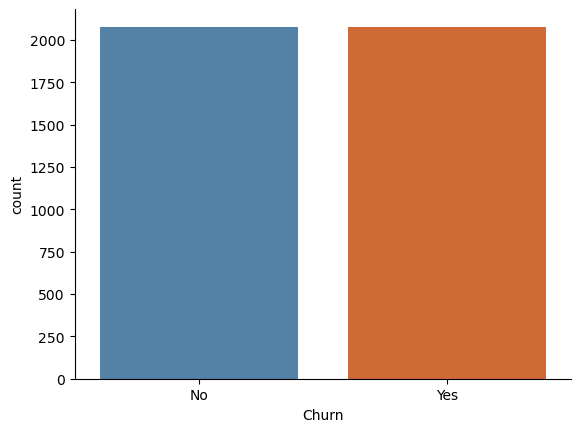

In [306]:
counts = df_artificial.groupby('Churn')['Churn'].value_counts().reset_index()
sns.barplot(data=counts, x='Churn', y='count', hue='Churn', palette=churn_colors)
sns.despine()

In [307]:
counts

,Churn,count
0,No,2078
1,Yes,2078


In [308]:
df_artificial.to_json(DATA_PATH / 'datos_artificiales_labeled.json', orient='records')

In [309]:
df_artificial_proba = df_artificial.drop('Churn', axis=1)
df_artificial_proba.to_json(DATA_PATH / 'datos_artificiales_proba.json', orient='records')

In [310]:
with open(CHAMPION_PATH / 'cat_cols.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

In [311]:
num_cols = df_artificial.select_dtypes(include=['float', 'int'], exclude='object').columns.tolist()
num_cols

['Tenure', 'ChargesDaily', 'ChargesMonthly', 'ChargesTotal']

In [312]:
with open(CHAMPION_PATH / 'num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)

#### **Nota**:

Se conservarán también los datos originales dentro de la carpeta del proyecto por razones de completitud ya que fueron tomados a partir del URL del proyecto anterior.

In [313]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/preprocessed_TelecomX_data.json'

df_smote = pd.read_json(URL)
df_smote.to_json(DATA_PATH /'preprocessed_TelecomX_data.json', orient='records')

try:
    URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX/refs/heads/main/src/clientes_altovalor_abandonan.json'
    outliers = pd.read_json(URL)
    outliers.to_json(DATA_PATH / 'clientes_altovalor_abandonan.json', orient='records')
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

## <font color='#ebac3a'>**Pipeline de prueba**</font>

Con los datos artificiales generados anteriormente, se creará una función (pipeline) utilizando los artefactos construidos a lo largo del proyecto que permita realizar predicciones sobre nuevos clientes.
A su vez, la función tendrá la opción de monitorear el modelo para observar su desempeño en producción, lo que permitirá mantener un registro de sus métricas en caso de necesitar ajustar, reentrenar, o incluso considerar un cambio de modelo.

In [314]:
def run_pipeline(file: str, mode: str='production'):

    """
    Función para correr pipeline en producción, el cual puede ser utilizado para predicciones o monitoreo del desempeño del modelo.
    ---------------------------------------------------------------------
    Parámetros:
        file: str
            Recibe URL o nombre del archivo JSON utilizado por el modelo champion para realizar las predicciones
        mode: str
            Modo de ejecutar el pipeline. Recibe dos opciones: 
                'production' -> devuelve [CustomerID, Probabilidad de Churn, Etiqueta Churn] | 
                'monitor' -> devuelve métricas de evaluación del modelo: [Accuracy, Precision, Recall, F1-score]
    ---------------------------------------------------------------------
    Returns:
        Archivo JSON con resultados del modo seleccionado (logs)
        En notebook:
            'production': pandas.core.frame.DataFrame -> DataFrame con las predicciones obtenidas
            'monitor': Dict -> Diccionario con métricas de evaluación obtenidas
    """


    start_time = timer()
    with open(CHAMPION_PATH / 'robust_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open(CHAMPION_PATH / 'one_hot_encoder.pkl', 'rb') as f:
        one_hot = pickle.load(f)
    
    with open(CHAMPION_PATH / 'target_encoder.pkl', 'rb') as f:
        target_encoder = pickle.load(f)
        
    with open(CHAMPION_PATH / 'champion_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open(CHAMPION_PATH / 'columns_order.pkl', 'rb') as f:
       order_cols = pickle.load(f)
    
    with open(CHAMPION_PATH / 'cat_cols.pkl', 'rb') as f:
       cat_cols = pickle.load(f)
    
    with open(CHAMPION_PATH / 'num_cols.pkl', 'rb') as f:
       num_cols = pickle.load(f)
    if 'ChargesDaily' in num_cols:
        num_cols.remove('ChargesDaily')

    data = pd.read_json(file)
    
    
    log = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    if mode == 'production':
        # Conservar IDs de clientes
        customers_ids = data['CustomerID']
        # Descartar columnas no utilizadas por el modelo
        data = data.drop(['CustomerID', 'ChargesDaily'], axis=1)
        # Codificar variables categoricas
        data = one_hot.transform(data)
        # Nombre de columnas antes de escalar
        cols_names = order_cols[:-3] + num_cols
        # Generar data frame
        df = pd.DataFrame(data, columns=cols_names)
        # Escalar columnas numéricas
        df[num_cols] = scaler.transform(df[num_cols])
        # Renombrar columnas del DataFrame
        df.columns = order_cols
        # Obtener probabilidad de churn con el modelo champion
        pred_proba = model.predict_proba(df)[:, 1]
        # Obtener churn label con el modelo champion
        pred_labels = model.predict(df)
        # Generar DataFrame con los resultados
        results = pd.DataFrame({'CustomerID': customers_ids,
                                'Probabilidad Churn': np.round(pred_proba, 4),
                                'Churn': pred_labels})
        # Guardar los resultados del modelo en archivo JSON
        results.to_json(PRODUCTION_PATH / f'pipeline_results_{log}.json')
        return results
        
    elif mode == 'monitor':
        # Descartar columnas no utilizadas por el modelo
        data = data.drop(['CustomerID', 'ChargesDaily'], axis=1)
        # Separar labels para evaluación del modelo
        y = data['Churn']
        # Codificar variable respuesta
        y = label_encoder.transform(y).ravel()
        # Preparar datos para realizar predicciones
        data = data.drop('Churn', axis=1)
        # Codificar variables categóricas
        data = one_hot.transform(data)
        # Nombre de columnas antes de escalar
        cols_names = order_cols[:-3] + num_cols
        # Generar DataFrame
        df = pd.DataFrame(data, columns=cols_names)
        # Escalar columnas numéricas
        df[num_cols] = scaler.transform(df[num_cols])
        # Renombrar columnas
        df.columns = order_cols
        # Realizar predicciones con el modelo
        y_pred = model.predict(df)
        # Obtener métricas de evaluación
        metricas = metricas_generales(model, df, y, f'Champion_{log}')
        # Finalizar timer
        end_time = timer()
        # Guardar tiempo de predicción
        metricas['prediction_time'] = np.round(end_time - start_time)
        # Lista para guardar las metricas
        df_metricas = []
        # Agregar metricas a la lista para generar DataFrame
        df_metricas.append(metricas)

        df_metricas = pd.DataFrame(df_metricas)
        df_metricas.to_json(MONITOR_PATH / f'monitor_results_{log}.json')
        return df_metricas
    else:
        raise ValueError('Esta función recibe solo mode = "production" o "monitor"')

In [315]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX_parte_2/refs/heads/main/src/datos_artificiales_proba.json'

run_pipeline(file=URL, mode='production')

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ChargesMonthly_scaled
- ChargesTotal_scaled
- Tenure_scaled
Feature names seen at fit time, yet now missing:
- ChargesMonthly
- ChargesTotal
- Contract_Month-to-month
- InternetService_DSL
- PaymentMethod_Bank transfer (automatic)
- ...


In [ ]:
URL = 'https://raw.githubusercontent.com/ignaciomajo/proyecto_TelecomX_parte_2/refs/heads/main/src/datos_artificiales_labeled.json'

run_pipeline(file=URL, mode='monitor')